***
## Table of Contents
<br>
<ol>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;"> 50:50 Uninfected:Infected Users</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. 80:20 Train Test Split </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. 70:30 Train Test Split </h3></a>
            </ul>
        <ul>
            <a href='#1.C' style="text-decoration : none; color : #000000;"><h3>B. 80:20 Train Test Split with PCA </h3></a>
           </ul>
        <ul>
            <a href='#1.D' style="text-decoration : none; color : #000000;"><h3>D. 70:30 Train Test Split with PCA </h3></a>
            </ul>
     </ol>
<br>

In [2]:
### Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pprint
from tabulate import tabulate
import warnings

%matplotlib inline
pd.set_option("display.max_columns",40)
warnings.filterwarnings("ignore")

from IPython.display import HTML


import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier


from sklearn.metrics import confusion_matrix,accuracy_score,auc,roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,binarize



Using TensorFlow backend.


In [2]:
from pandas_ml import ConfusionMatrix

### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

###  <a id='1.A' style="text-decoration : none; color : #000000;">A. 80:20 Train Test Split</a>
#### Random State 0

In [3]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     4    1.00000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  9326  236.40564   

                                                           PAS        LEN  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...    1.000000  31.000000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  130.825005  78.920437   

                                                             BYS  \
Source_User                                                        
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     77.500000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  16523.837122   

                                                              BYR      SP  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     225.750000     4.0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  308234.733219  7070.0   

                                                      DP  NAPP  SIP   DIP  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...   1.0     1    1     1   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  26.0    47   74  1610   

                                                          TDIF  0000  0100  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...    0.250000     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  796.853957   528   582   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   519   540   512   417   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   421   626   360   346   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   223   308   207   272   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   844   136   298   175   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     4     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   259   359   259   323   

                                                    2200  2300  
Source_User                                                     
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0  
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   397   415

In [4]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1193b2d05e46c2e870    0
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c1f6ca9d117f8b3530    1
c2cf660ad094544b4bb8f01efb417804cfa5d53624783c2f784faac2b244c029    1
3fcd1179a650c2cfc6b6d23aa0193f8247ea56691044389f53a1e771431e2862    0
55394724a0a52464de210c953c5e6bee779e0f0a163aa4787087024004caeb82    1
327686c9e4533b14641208d230f5d01b93dcdd21d71360fbcac0d78d487c58ab    0
bc72f41bcdc4b3e5ee020baae91eb97b6c4ca7a1209ed7a69f4f0915de990aa2    0
d49890688b35443d361df19e2bfeaeddeda4d5572c03cf5678f9b36e01cf5415    1
01c615bd6e5026eb8f8ce76567d9f00c3eec2b1752da1854ece27439da4c0fe9    0
469c1c634cf9e6412e08bda889e471ef6af563097f737223a09ad50e7364cfa9    0
Name: Target, dtype: int64

In [5]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [6]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          2007     0     2007
1             0  1962     1962
__all__    2007  1962     3969

Accuracy of the  KNN  model for test data is: 0.792547834844

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          374  100      474
1          106  413      519
__all__    480  513      993

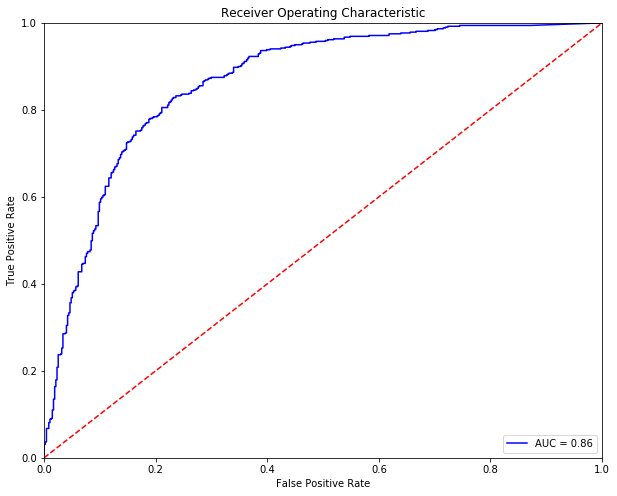

Optimal Threshold is 0.50519310045
Accuracy of Logistic Model on training data is: 0.792547834844


Predicted  0.0  1.0  __all__
Actual                      
0.0        376   98      474
1.0        108  411      519
__all__    484  509      993

In [8]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [9]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [10]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50          ovr   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  1e-05

Accuracy of the  Logistic  model for the training data is: 0.794658604182

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1595   412     2007
1           403  1559     1962
__all__    1998  1971     3969

Accuracy of the  Logistic  model for test data is: 0.788519637462

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          376   98      474
1          112  407      519
__all__    488  505      993

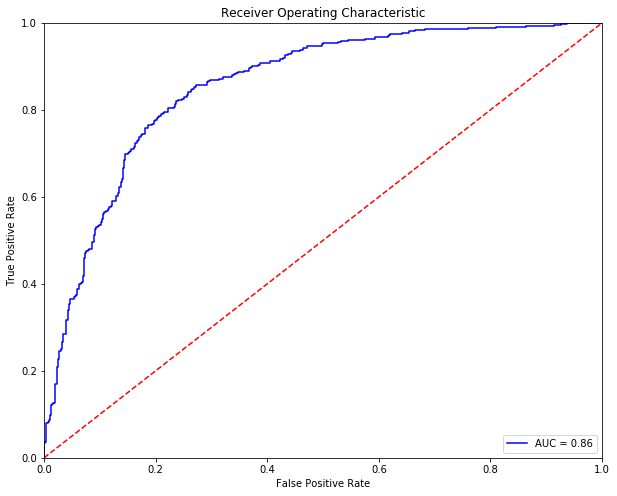

Optimal Threshold is 0.491375421249
Accuracy of Logistic Model on training data is: 0.789526686808


Predicted  0.0  1.0  __all__
Actual                      
0.0        375   99      474
1.0        110  409      519
__all__    485  508      993

In [11]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [12]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [13]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.800201562106

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1556   451     2007
1           342  1620     1962
__all__    1898  2071     3969

Accuracy of the  Random Forest Trees  model for test data is: 0.792547834844

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          370  104      474
1          102  417      519
__all__    472  521      993

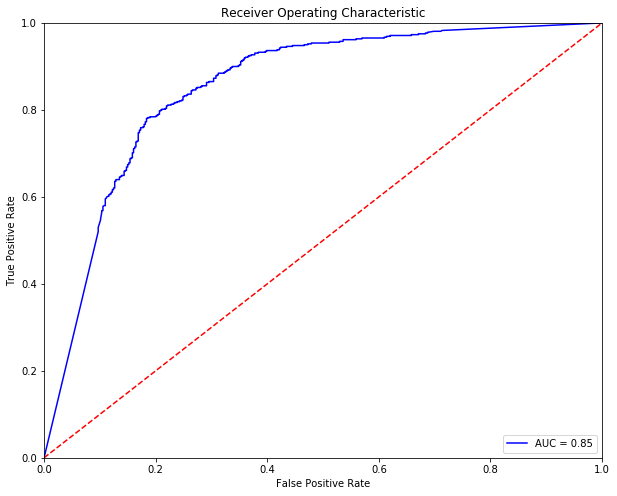

Optimal Threshold is 0.554235720167
Accuracy of Logistic Model on training data is: 0.792547834844


Predicted  0.0  1.0  __all__
Actual                      
0.0        377   97      474
1.0        109  410      519
__all__    486  507      993

In [14]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [15]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

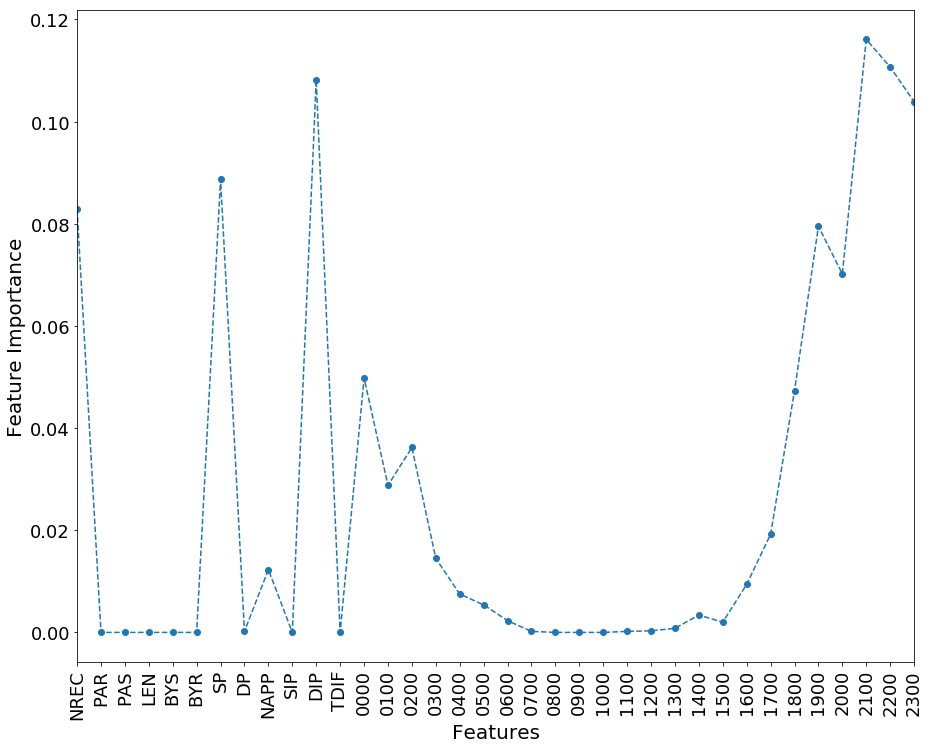

In [16]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [17]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            1.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.808767951625

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1499   508     2007
1           251  1711     1962
__all__    1750  2219     3969

Accuracy of the  AdaBoostClassifier  model for test data is: 0.789526686808

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          347  127      474
1           82  437      519
__all__    429  564      993

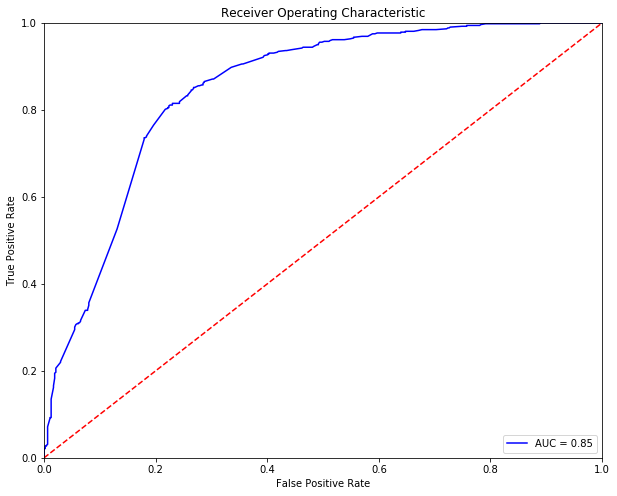

Optimal Threshold is 0.509184714864
Accuracy of Logistic Model on training data is: 0.783484390735


Predicted  0.0  1.0  __all__
Actual                      
0.0        381   93      474
1.0        122  397      519
__all__    503  490      993

In [18]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [19]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

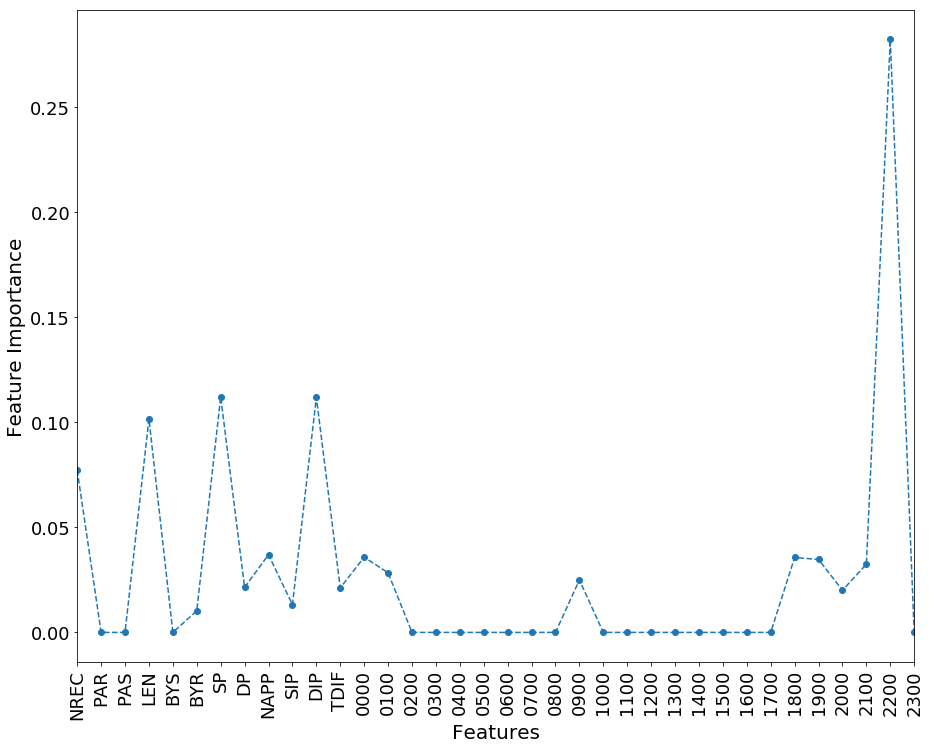

In [20]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [21]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.05  deviance                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.3           150             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.811287477954

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1539   468     2007
1           281  1681     1962
__all__    1820  2149     3969

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.791540785498

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          361  113      474
1           94  425      519
__all__    455  538      993

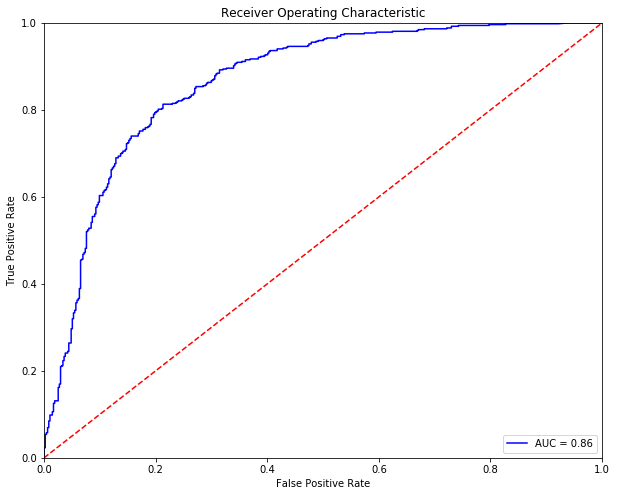

Optimal Threshold is 0.573272172426
Accuracy of Logistic Model on training data is: 0.796576032226


Predicted  0.0  1.0  __all__
Actual                      
0.0        378   96      474
1.0        106  413      519
__all__    484  509      993

In [22]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [23]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

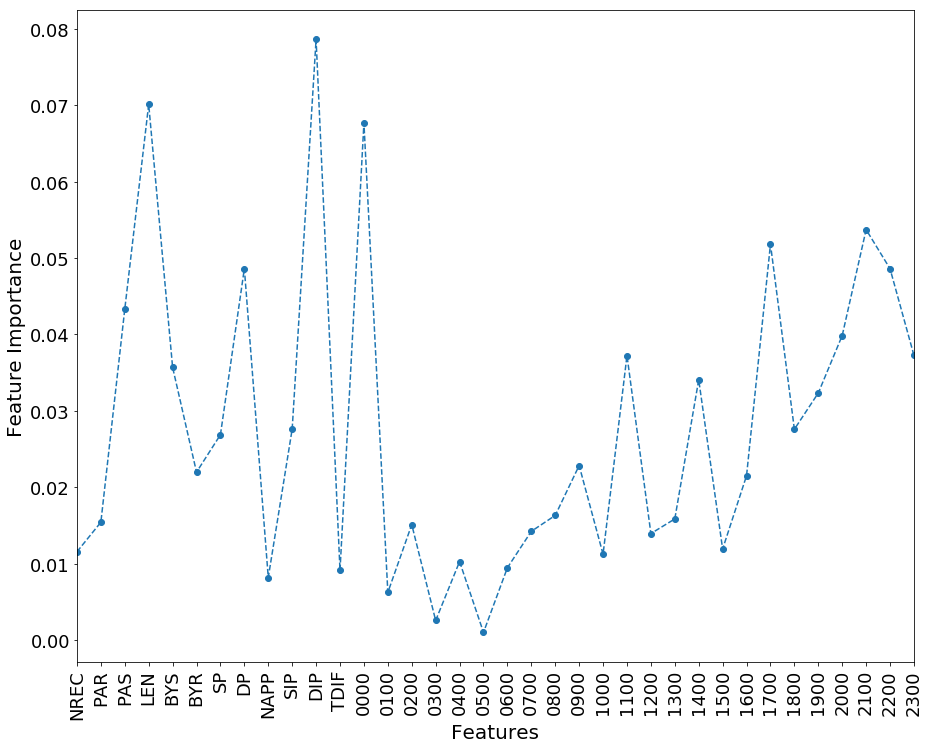

In [24]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [25]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                    0.1   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.796674225246

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1563   444     2007
1           363  1599     1962
__all__    1926  2043     3969

Accuracy of the  Extra Decision Tree  model for test data is: 0.787512588117

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          362  112      474
1           99  420      519
__all__    461  532      993

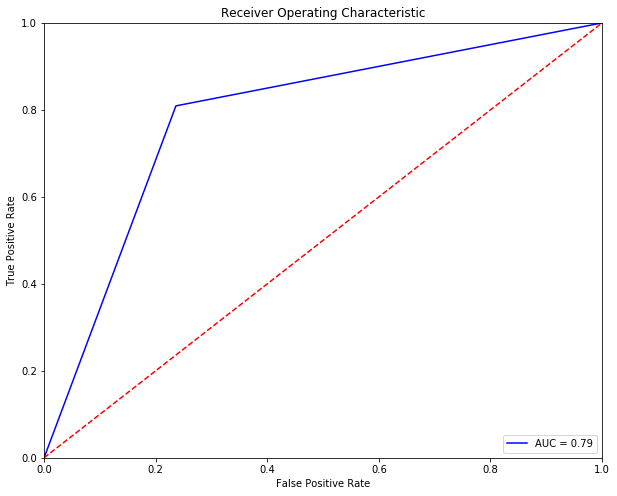

Optimal Threshold is 0.782672540382
Accuracy of Logistic Model on training data is: 0.477341389728


Predicted  0.0  1.0  __all__
Actual                      
0.0        474    0      474
1.0        519    0      519
__all__    993    0      993

In [26]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [27]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [28]:
%%capture
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

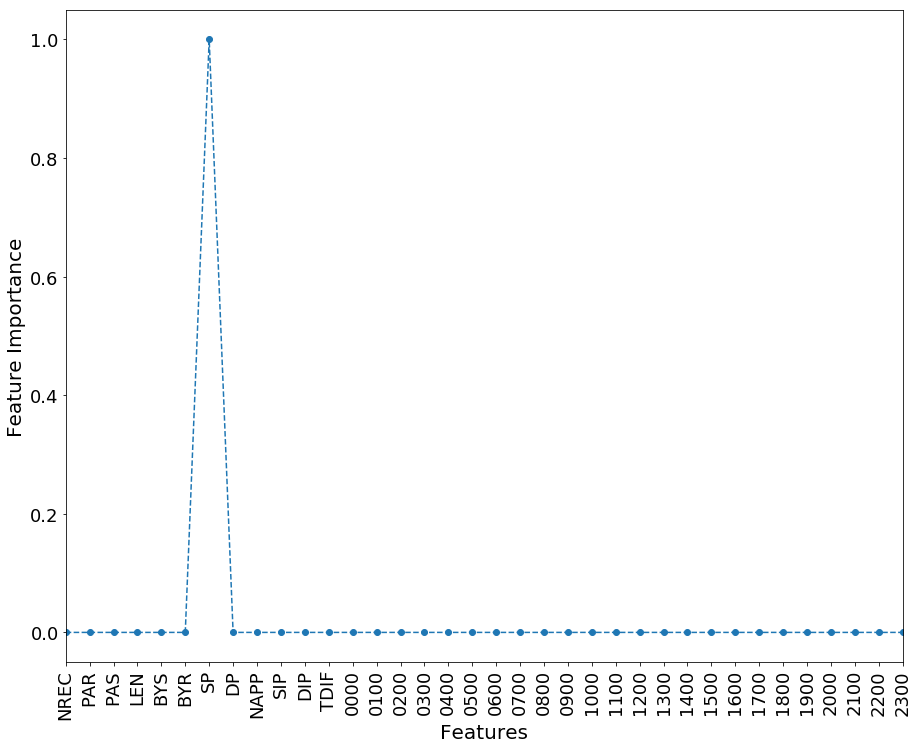

In [29]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [30]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.4          0.6           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.989669942051

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1988    19     2007
1            22  1940     1962
__all__    2010  1959     3969

Accuracy of the  Bagging  model for test data is: 0.799597180262

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          362  112      474
1           87  432      519
__all__    449  544      993

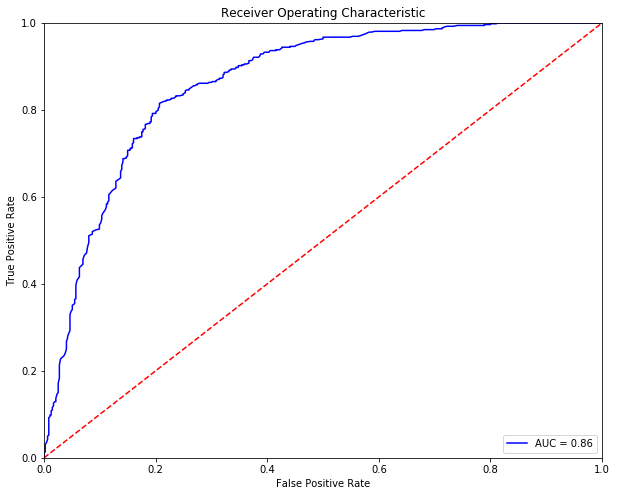

Optimal Threshold is 0.542
Accuracy of Logistic Model on training data is: 0.796576032226


Predicted  0.0  1.0  __all__
Actual                      
0.0        379   95      474
1.0        107  412      519
__all__    486  507      993

In [31]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [32]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [33]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.9019904258


Predicted     0     1  __all__
Actual                        
0          1768   239     2007
1           150  1812     1962
__all__    1918  2051     3969

The test accuracy is: 0.793554884189


Predicted    0    1  __all__
Actual                      
0          367  107      474
1           98  421      519
__all__    465  528      993

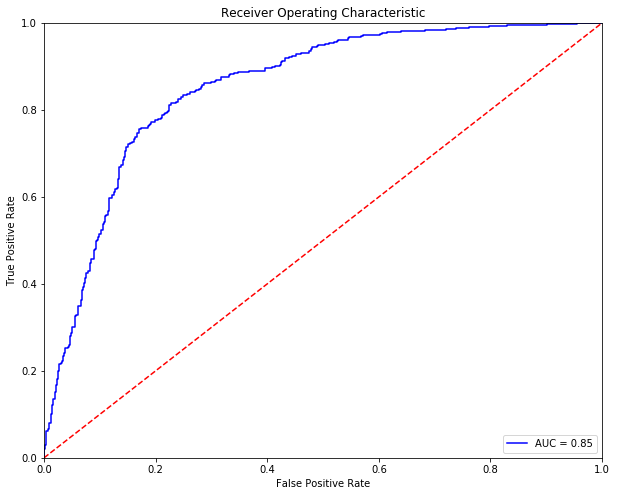

Optimal Threshold is 0.525522452803
Accuracy of Logistic Model on training data is: 0.787512588117


Predicted  0.0  1.0  __all__
Actual                      
0.0        374  100      474
1.0        111  408      519
__all__    485  508      993

In [34]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [35]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [36]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.924414210128


Predicted     0     1  __all__
Actual                        
0          1867   140     2007
1           160  1802     1962
__all__    2027  1942     3969

The accuracy of the model on test data is: 0.736153071501


Predicted    0    1  __all__
Actual                      
0          339  135      474
1          127  392      519
__all__    466  527      993

 32/993 [..............................] - ETA: 0s

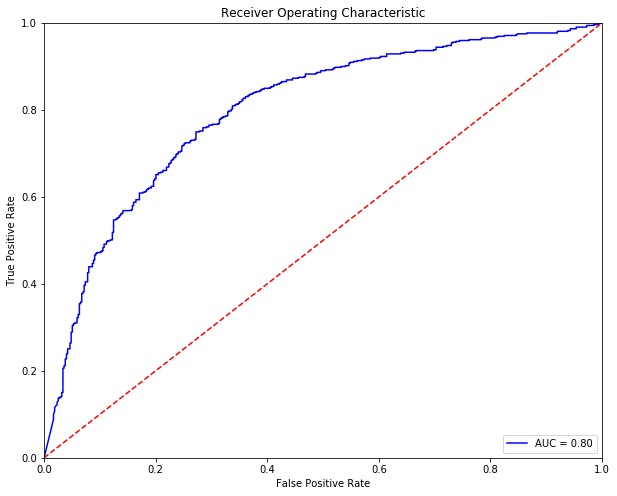

Optimal Threshold is 0.527469
Accuracy of Logistic Model on training data is: 0.731117824773


Predicted  0.0  1.0  __all__
Actual                      
0.0        347  127      474
1.0        140  379      519
__all__    487  506      993

In [37]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [38]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [39]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.2min finished


The accuracy of the model on training data is: 0.809271856891


Predicted     0     1  __all__
Actual                        
0          1572   435     2007
1           322  1640     1962
__all__    1894  2075     3969

The accuracy of the model on test data is: 0.785498489426


Predicted    0    1  __all__
Actual                      
0          364  110      474
1          103  416      519
__all__    467  526      993

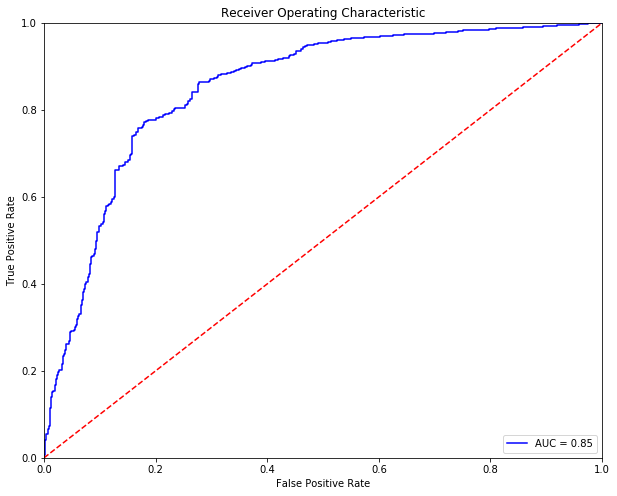

Optimal Threshold is 0.54083
Accuracy of Logistic Model on training data is: 0.786505538771


Predicted  0.0  1.0  __all__
Actual                      
0.0        373  101      474
1.0        111  408      519
__all__    484  509      993

In [40]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [41]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [42]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1962.0  2007.0    0.0    0.0  0.000000   
LogisticRegression          0.794659  1559.0  1595.0  412.0  403.0  0.205282   
RandomForestClassifier      0.800202  1620.0  1556.0  451.0  342.0  0.224714   
AdaBoostClassifier          0.808768  1711.0  1499.0  508.0  251.0  0.253114   
GradientBoostingClassifier  0.811287  1681.0  1539.0  468.0  281.0  0.233184   
ExtraTreeClassifier         0.796674  1599.0  1563.0  444.0  363.0  0.221226   
BaggingClassifier           0.989670  1940.0  1988.0   19.0   22.0  0.009467   
VotingClassifier            0.901990  1812.0  1768.0  239.0  150.0  0.119083   
Neural Network-1            0.924414  1802.0  1867.0  140.0  160.0  0.069756   
Neural-Network-2            0.809272  1640.0  1572.0  435.0  322.0  0.216741   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.205403  
RandomForestClassifier      0.174312  
AdaBoostClassifier          0.127931  
GradientBoostingClassifier  0.143221  
ExtraTreeClassifier         0.185015  
BaggingClassifier           0.011213  
VotingClassifier            0.076453  
Neural Network-1            0.081549  
Neural-Network-2            0.164118

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.792548  413.0  374.0  100.0  106.0  0.210970   
LogisticRegression          0.788520  407.0  376.0   98.0  112.0  0.206751   
RandomForestClassifier      0.792548  417.0  370.0  104.0  102.0  0.219409   
AdaBoostClassifier          0.789527  437.0  347.0  127.0   82.0  0.267932   
GradientBoostingClassifier  0.791541  425.0  361.0  113.0   94.0  0.238397   
ExtraTreeClassifier         0.787513  420.0  362.0  112.0   99.0  0.236287   
BaggingClassifier           0.799597  432.0  362.0  112.0   87.0  0.236287   
VotingClassifier            0.793555  421.0  367.0  107.0   98.0  0.225738   
Neural Network-1            0.736153  392.0  339.0  135.0  127.0  0.284810   
Neural-Network-2            0.785498  416.0  364.0  110.0  103.0  0.232068   

                                 FNR  
index                                 
KNeighborsClassifier        0.204239  
LogisticRegression          0.215800  
RandomForestClassifier      0.196532  
AdaBoostClassifier          0.157996  
GradientBoostingClassifier  0.181118  
ExtraTreeClassifier         0.190751  
BaggingClassifier           0.167630  
VotingClassifier            0.188825  
Neural Network-1            0.244701  
Neural-Network-2            0.198459

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy          TP          TN          FP  \
index                                                                      
KNeighborsClassifier        0.792548  411.000000  376.000000   98.000000   
LogisticRegression          0.789527  409.000000  375.000000   99.000000   
RandomForestClassifier      0.792548  410.000000  377.000000   97.000000   
AdaBoostClassifier          0.783484  397.000000  381.000000   93.000000   
GradientBoostingClassifier  0.796576  413.000000  378.000000   96.000000   
ExtraTreeClassifier         0.477341  226.259819  247.740181  247.740181   
BaggingClassifier           0.796576  412.000000  379.000000   95.000000   
VotingClassifier            0.787513  408.000000  374.000000  100.000000   
Neural Network-1            0.731118  379.000000  347.000000  127.000000   
Neural-Network-2            0.786506  408.000000  373.000000  101.000000   

                                    FN       FPR       FNR  threshold  \
index                                                                   
KNeighborsClassifier        108.000000  0.206751  0.208092   0.505193   
LogisticRegression          110.000000  0.208861  0.211946   0.491375   
RandomForestClassifier      109.000000  0.204641  0.210019   0.554236   
AdaBoostClassifier          122.000000  0.196203  0.235067   0.509185   
GradientBoostingClassifier  106.000000  0.202532  0.204239   0.573272   
ExtraTreeClassifier         271.259819  0.477341  0.522659   0.782673   
BaggingClassifier           107.000000  0.200422  0.206166   0.542000   
VotingClassifier            111.000000  0.210970  0.213873   0.525522   
Neural Network-1            140.000000  0.267932  0.269750   0.527469   
Neural-Network-2            111.000000  0.213080  0.213873   0.540830   

                                 auc  
index                                 
KNeighborsClassifier        0.864896  
LogisticRegression          0.855666  
RandomForestClassifier      0.853772  
AdaBoostClassifier          0.847577  
GradientBoostingClassifier  0.864678  
ExtraTreeClassifier         0.786481  
BaggingClassifier           0.863587  
VotingClassifier            0.852654  
Neural Network-1            0.797844  
Neural-Network-2            0.851808

#### Random State 10

In [43]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...   558  87.706093   
384ed706777916e315308d41eb2efc086edc768b6392e14...     3  29.333333   

                                                          PAS         LEN  \
Source_User                                                                 
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  25.094982  106.747312   
384ed706777916e315308d41eb2efc086edc768b6392e14...  22.000000  363.000000   

                                                            BYS  \
Source_User                                                       
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  3436.492832   
384ed706777916e315308d41eb2efc086edc768b6392e14...  5405.333333   

                                                              BYR     SP  \
Source_User                                                                
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  103496.745520  539.0   
384ed706777916e315308d41eb2efc086edc768b6392e14...    3980.666667    3.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  20.0    42   47  230   
384ed706777916e315308d41eb2efc086edc768b6392e14...   1.0     2    1    2   

                                                           TDIF  0000  0100  \
Source_User                                                                   
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  7309.743728     5     4   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0.000000     0     0   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     0     0     0     0   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     4    31    14     3   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     3   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     3     4    16    18   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...    20    74    81    71   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...   116    42    32    10   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    2200  2300  
Source_User                                                     
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     4     6  
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0

In [44]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7ec769d861466ae859    0
384ed706777916e315308d41eb2efc086edc768b6392e14751b4d9bca760a59e    0
25fbc1afa01f04686e25d7cffb238ca43ffeb865a4e6c1d07029f2fd8dcfcd32    1
b522e1c3ad002eddf9145e38f7f0a2be9c45895d718c7977e0a6a2a7becb3a10    1
8eba4debb95ef877faed7041269483166a3145a7a590cba966da0a5aa394f2f3    1
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
8389fdb8a5b9d6fff6c3eb065c2f0eeaeb6931647d7ff91de731a82a98c197c5    0
d0d0439bceb5f83d975bd909d12ad0f8a13766371c2a092a446febf0f7b08f5c    1
2587a851f09c2bb4d22b7daf8ec30af164ad94a7f5d1620d60d271b85fff6f64    1
841bc27abf403835526548adc7b881573c654cc78cb11b9e064c7b9682a89709    0
Name: Target, dtype: int64

In [45]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [46]:
## Table to store training and test measures
table_80_50_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          2000     0     2000
1             0  1969     1969
__all__    2000  1969     3969

Accuracy of the  KNN  model for test data is: 0.799597180262

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          386   95      481
1          104  408      512
__all__    490  503      993

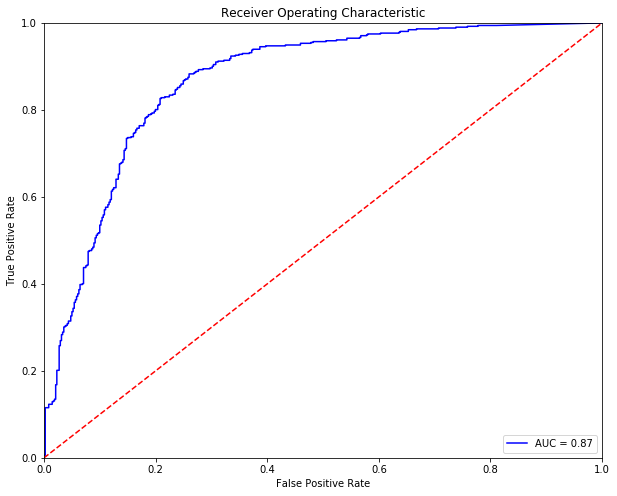

Optimal Threshold is 0.496383228971
Accuracy of Logistic Model on training data is: 0.799597180262


Predicted  0.0  1.0  __all__
Actual                      
0.0        385   96      481
1.0        103  409      512
__all__    488  505      993

In [48]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [49]:
table_80_50_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [50]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.798941798942

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1599   401     2000
1           397  1572     1969
__all__    1996  1973     3969

Accuracy of the  Logistic  model for test data is: 0.786505538771

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          391   90      481
1          122  390      512
__all__    513  480      993

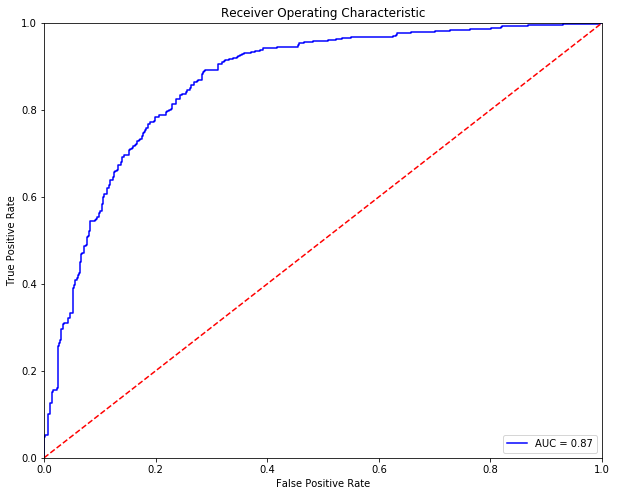

Optimal Threshold is 0.481272336093
Accuracy of Logistic Model on training data is: 0.790533736153


Predicted  0.0  1.0  __all__
Actual                      
0.0        382   99      481
1.0        109  403      512
__all__    491  502      993

In [51]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [52]:
table_80_50_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [53]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0        entropy         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.800453514739

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1552   448     2000
1           344  1625     1969
__all__    1896  2073     3969

Accuracy of the  Random Forest Trees  model for test data is: 0.802618328298

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          383   98      481
1           98  414      512
__all__    481  512      993

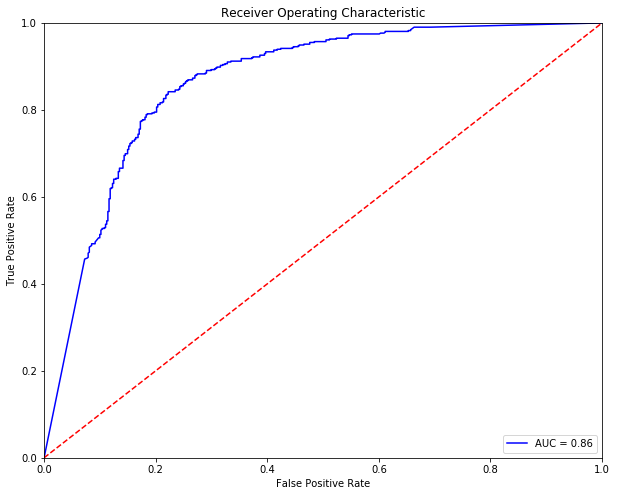

Optimal Threshold is 0.532989613168
Accuracy of Logistic Model on training data is: 0.797583081571


Predicted  0.0  1.0  __all__
Actual                      
0.0        385   96      481
1.0        105  407      512
__all__    490  503      993

In [54]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [55]:
table_80_50_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

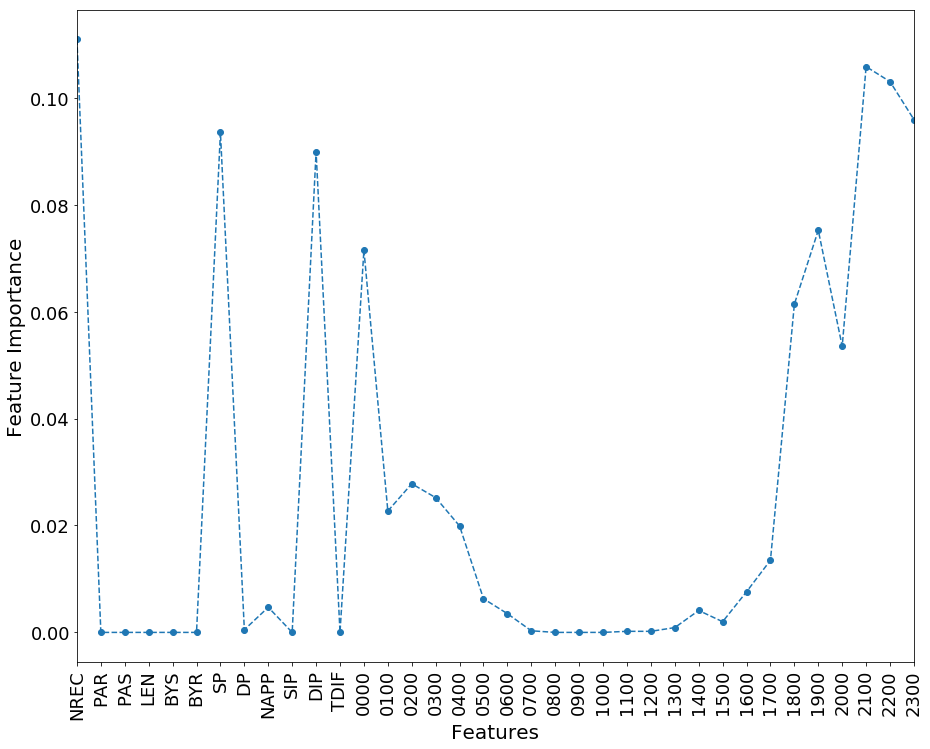

In [56]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [57]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0        SAMME.R            0.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.804736709499

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1576   424     2000
1           351  1618     1969
__all__    1927  2042     3969

Accuracy of the  AdaBoostClassifier  model for test data is: 0.804632426989

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          380  101      481
1           93  419      512
__all__    473  520      993

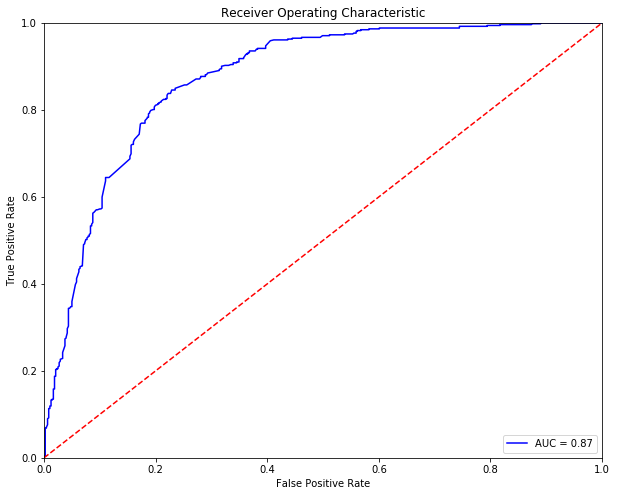

Optimal Threshold is 0.502206502994
Accuracy of Logistic Model on training data is: 0.802618328298


Predicted  0.0  1.0  __all__
Actual                      
0.0        387   94      481
1.0        102  410      512
__all__    489  504      993

In [58]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [59]:
table_80_50_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

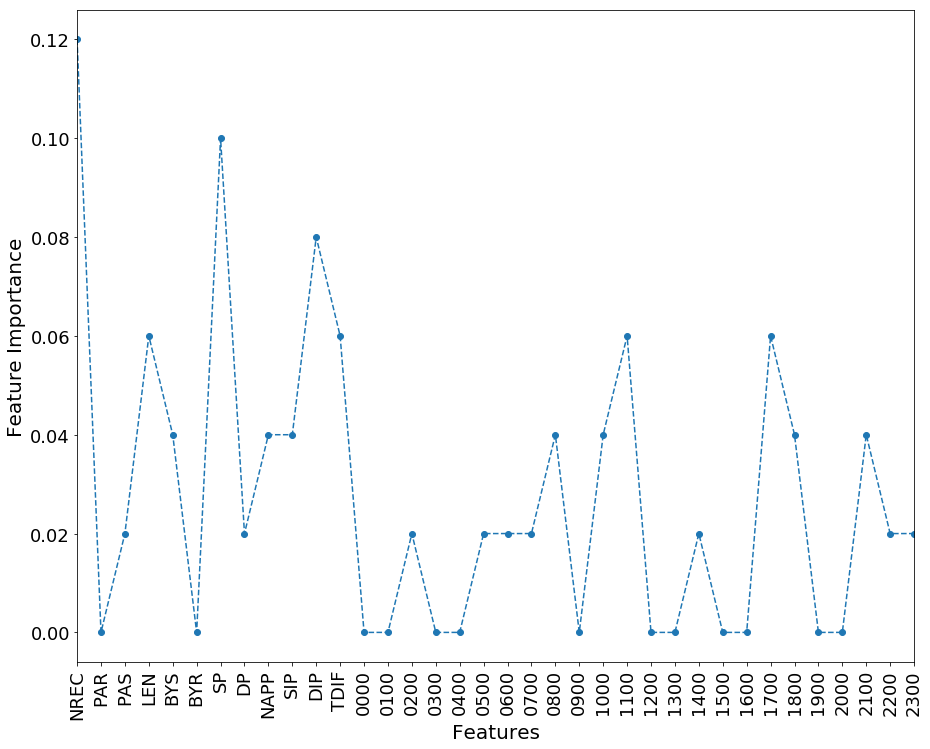

In [60]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [61]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.03  deviance                 5   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           100             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.812799193752

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1561   439     2000
1           304  1665     1969
__all__    1865  2104     3969

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.808660624371

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          381  100      481
1           90  422      512
__all__    471  522      993

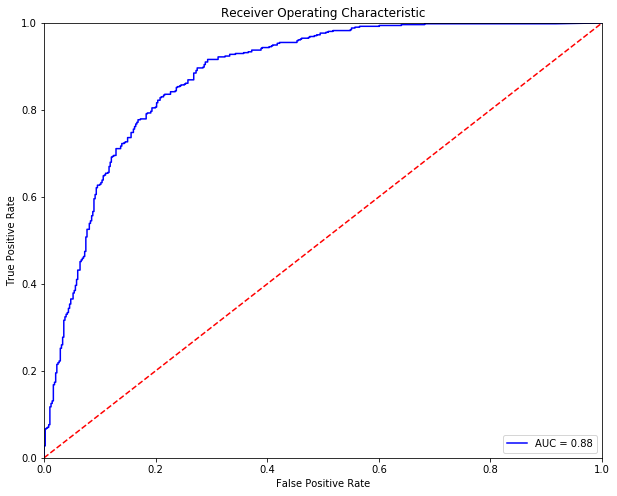

Optimal Threshold is 0.554782223897
Accuracy of Logistic Model on training data is: 0.804632426989


Predicted  0.0  1.0  __all__
Actual                      
0.0        388   93      481
1.0        101  411      512
__all__    489  504      993

In [62]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [63]:
table_80_50_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

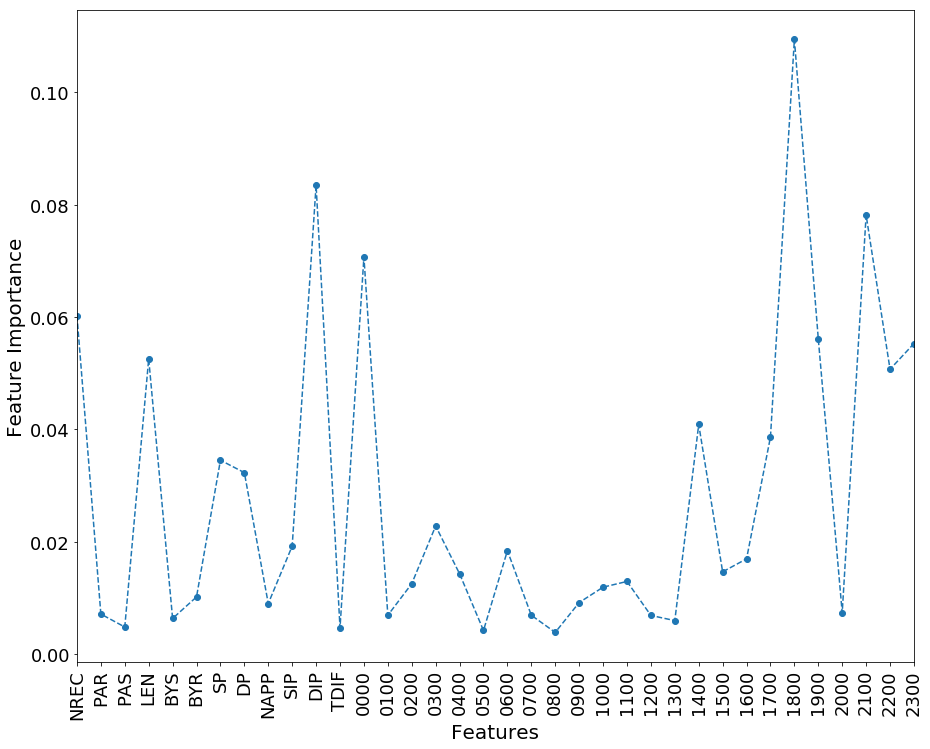

In [64]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [65]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                    0.1   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.797682035777

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1596   404     2000
1           399  1570     1969
__all__    1995  1974     3969

Accuracy of the  Extra Decision Tree  model for test data is: 0.796576032226

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          386   95      481
1          107  405      512
__all__    493  500      993

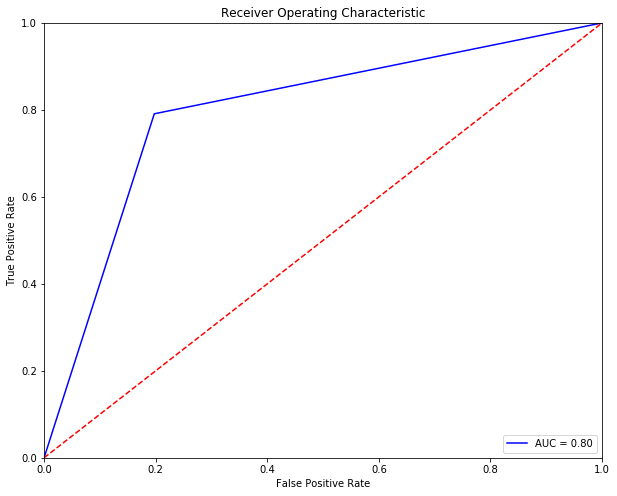

Optimal Threshold is 0.795339412361
Accuracy of Logistic Model on training data is: 0.484390735146


Predicted  0.0  1.0  __all__
Actual                      
0.0        481    0      481
1.0        512    0      512
__all__    993    0      993

In [66]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [67]:
table_80_50_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [68]:
%%capture
table_80_50_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

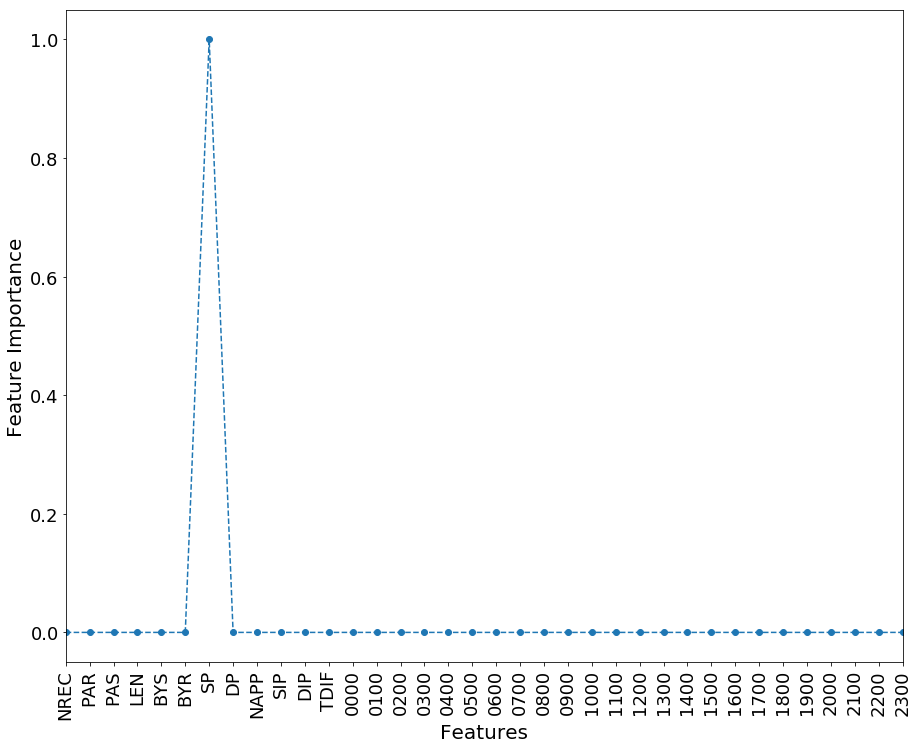

In [69]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [70]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.4          0.4          1500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.919879062736

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1790   210     2000
1           108  1861     1969
__all__    1898  2071     3969

Accuracy of the  Bagging  model for test data is: 0.810674723061

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          383   98      481
1           90  422      512
__all__    473  520      993

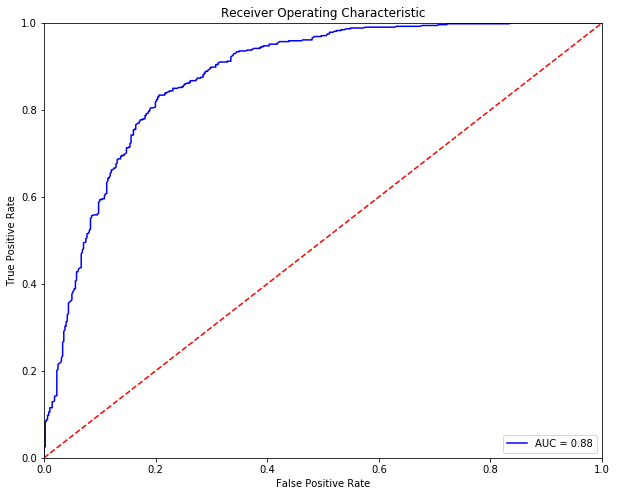

Optimal Threshold is 0.523333333333
Accuracy of Logistic Model on training data is: 0.805639476334


Predicted  0.0  1.0  __all__
Actual                      
0.0        388   93      481
1.0        100  412      512
__all__    488  505      993

In [71]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [72]:
table_80_50_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [73]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.900982615268


Predicted     0     1  __all__
Actual                        
0          1762   238     2000
1           155  1814     1969
__all__    1917  2052     3969

The test accuracy is: 0.807653575025


Predicted    0    1  __all__
Actual                      
0          382   99      481
1           92  420      512
__all__    474  519      993

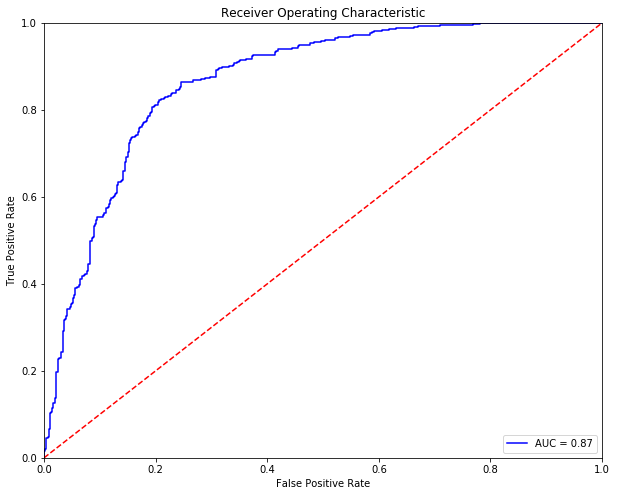

Optimal Threshold is 0.515485891672
Accuracy of Logistic Model on training data is: 0.805639476334


Predicted  0.0  1.0  __all__
Actual                      
0.0        388   93      481
1.0        100  412      512
__all__    488  505      993

In [74]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [75]:
table_80_50_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [76]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.909549004787


Predicted     0     1  __all__
Actual                        
0          1899   101     2000
1           258  1711     1969
__all__    2157  1812     3969

The accuracy of the model on test data is: 0.769385699899


Predicted    0    1  __all__
Actual                      
0          396   85      481
1          144  368      512
__all__    540  453      993

 32/993 [..............................] - ETA: 0s

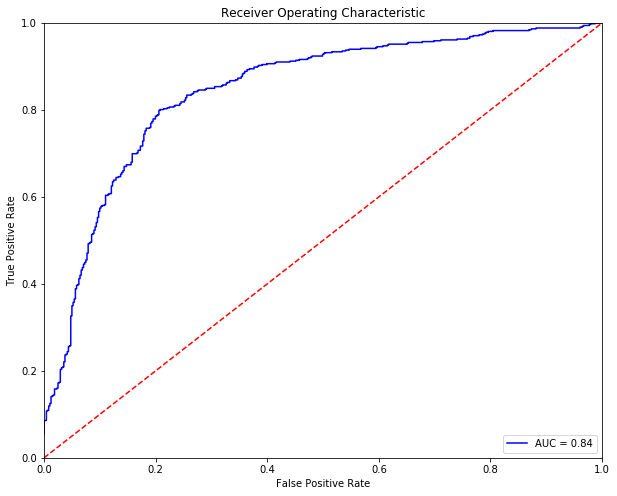

Optimal Threshold is 0.358544
Accuracy of Logistic Model on training data is: 0.79556898288


Predicted  0.0  1.0  __all__
Actual                      
0.0        382   99      481
1.0        104  408      512
__all__    486  507      993

In [77]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [78]:
table_80_50_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [79]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.6min finished


The accuracy of the model on training data is: 0.805996472663


Predicted     0     1  __all__
Actual                        
0          1648   352     2000
1           418  1551     1969
__all__    2066  1903     3969

The accuracy of the model on test data is: 0.796576032226


Predicted    0    1  __all__
Actual                      
0          399   82      481
1          120  392      512
__all__    519  474      993

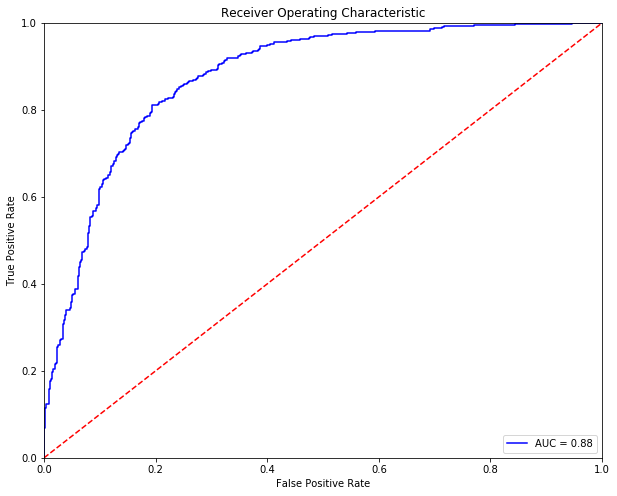

Optimal Threshold is 0.389501
Accuracy of Logistic Model on training data is: 0.807653575025


Predicted  0.0  1.0  __all__
Actual                      
0.0        388   93      481
1.0         98  414      512
__all__    486  507      993

In [80]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [81]:
table_80_50_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [82]:
table_80_50_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_10_test.set_index(['index'],drop=True,inplace=True)
table_80_50_10_train.set_index(['index'],drop=True,inplace=True)
table_80_50_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_10_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_10_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN     FPR  \
index                                                                        
KNeighborsClassifier        1.000000  1969.0  2000.0    0.0    0.0  0.0000   
LogisticRegression          0.798942  1572.0  1599.0  401.0  397.0  0.2005   
RandomForestClassifier      0.800454  1625.0  1552.0  448.0  344.0  0.2240   
AdaBoostClassifier          0.804737  1618.0  1576.0  424.0  351.0  0.2120   
GradientBoostingClassifier  0.812799  1665.0  1561.0  439.0  304.0  0.2195   
ExtraTreeClassifier         0.797682  1570.0  1596.0  404.0  399.0  0.2020   
BaggingClassifier           0.919879  1861.0  1790.0  210.0  108.0  0.1050   
VotingClassifier            0.900983  1814.0  1762.0  238.0  155.0  0.1190   
Neural Network-1            0.909549  1711.0  1899.0  101.0  258.0  0.0505   
Neural-Network-2            0.805996  1551.0  1648.0  352.0  418.0  0.1760   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.201625  
RandomForestClassifier      0.174708  
AdaBoostClassifier          0.178263  
GradientBoostingClassifier  0.154393  
ExtraTreeClassifier         0.202641  
BaggingClassifier           0.054850  
VotingClassifier            0.078720  
Neural Network-1            0.131031  
Neural-Network-2            0.212291

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.799597  408.0  386.0   95.0  104.0  0.197505   
LogisticRegression          0.786506  390.0  391.0   90.0  122.0  0.187110   
RandomForestClassifier      0.802618  414.0  383.0   98.0   98.0  0.203742   
AdaBoostClassifier          0.804632  419.0  380.0  101.0   93.0  0.209979   
GradientBoostingClassifier  0.808661  422.0  381.0  100.0   90.0  0.207900   
ExtraTreeClassifier         0.796576  405.0  386.0   95.0  107.0  0.197505   
BaggingClassifier           0.810675  422.0  383.0   98.0   90.0  0.203742   
VotingClassifier            0.807654  420.0  382.0   99.0   92.0  0.205821   
Neural Network-1            0.769386  368.0  396.0   85.0  144.0  0.176715   
Neural-Network-2            0.796576  392.0  399.0   82.0  120.0  0.170478   

                                 FNR  
index                                 
KNeighborsClassifier        0.203125  
LogisticRegression          0.238281  
RandomForestClassifier      0.191406  
AdaBoostClassifier          0.181641  
GradientBoostingClassifier  0.175781  
ExtraTreeClassifier         0.208984  
BaggingClassifier           0.175781  
VotingClassifier            0.179688  
Neural Network-1            0.281250  
Neural-Network-2            0.234375

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy          TP          TN          FP  \
index                                                                      
KNeighborsClassifier        0.799597  409.000000  385.000000   96.000000   
LogisticRegression          0.790534  403.000000  382.000000   99.000000   
RandomForestClassifier      0.797583  407.000000  385.000000   96.000000   
AdaBoostClassifier          0.802618  410.000000  387.000000   94.000000   
GradientBoostingClassifier  0.804632  411.000000  388.000000   93.000000   
ExtraTreeClassifier         0.484391  232.991944  248.008056  248.008056   
BaggingClassifier           0.805639  412.000000  388.000000   93.000000   
VotingClassifier            0.805639  412.000000  388.000000   93.000000   
Neural Network-1            0.795569  408.000000  382.000000   99.000000   
Neural-Network-2            0.807654  414.000000  388.000000   93.000000   

                                    FN       FPR       FNR  threshold  \
index                                                                   
KNeighborsClassifier        103.000000  0.199584  0.201172   0.496383   
LogisticRegression          109.000000  0.205821  0.212891   0.481272   
RandomForestClassifier      105.000000  0.199584  0.205078   0.532990   
AdaBoostClassifier          102.000000  0.195426  0.199219   0.502207   
GradientBoostingClassifier  101.000000  0.193347  0.197266   0.554782   
ExtraTreeClassifier         263.991944  0.484391  0.515609   0.795339   
BaggingClassifier           100.000000  0.193347  0.195312   0.523333   
VotingClassifier            100.000000  0.193347  0.195312   0.515486   
Neural Network-1            104.000000  0.205821  0.203125   0.358544   
Neural-Network-2             98.000000  0.193347  0.191406   0.389501   

                                 auc  
index                                 
KNeighborsClassifier        0.868432  
LogisticRegression          0.866034  
RandomForestClassifier      0.864043  
AdaBoostClassifier          0.873317  
GradientBoostingClassifier  0.881446  
ExtraTreeClassifier         0.796755  
BaggingClassifier           0.878009  
VotingClassifier            0.866627  
Neural Network-1            0.844097  
Neural-Network-2            0.877018

#### Random State 20

In [83]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  3728  132.185891   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...    81   31.061728   

                                                           PAS         LEN  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  103.969421  135.190987   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...   25.246914  109.395062   

                                                            BYS  \
Source_User                                                       
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  8652.968348   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...  3871.506173   

                                                              BYR      SP  \
Source_User                                                                 
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  178992.604882  3096.0   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...   17973.666667    80.0   

                                                       DP  NAPP  SIP  DIP  \
Source_User                                                                 
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  264.0    44  114  784   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...    3.0    10   12   28   

                                                            TDIF  0000  0100  \
Source_User                                                                    
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   2041.380633    72    81   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...  88488.987654     1     0   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   115   106   131   116   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0     0   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   100   355   279   152   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0     0   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   196   153   135   443   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0    10   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   243   195   185   132   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     1    25    32   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   152   107    90   107   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     2     8     0     0   

                                                    2200  2300  
Source_User                                                     
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...    38    45  
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     2     0

In [84]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
1da09acf8ddc082a297329856e8512e0aa25eef1650894f3e39d24006b3b9900    1
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8ddc3d1beabef89096b    0
c7ae13801caa67d372db28e31fe24146a34866c75fdaa7a8f3dd2e52c8feadbf    0
d7a31b1f8a1b6229ffc4f3d615d4847d8844645ed5bc9d4f016352ccde33eeef    0
2e8858be6011eed9b63eb701eda4575a43151dcedbd12b1e87e9707f1355e52d    1
aef14742e536c93ce48a00a70bc5c429ff5973e95f029488785eeda1778ea086    1
0930d98b6033a246eaecdf425d4fe74341a505bb2ffb83a09d4e489b29dea307    1
3f716f2fcc54a3eac07cc68af79773e6e32cc680c5f1b1e44ad527af39210d58    1
655f71c7531f608b3aa19880786cc023e26286b3bef2ad9917e379ddcead4e43    1
5957761ffa31d8e6cf65bb4540565c1ebd6e030e40b744a5c21d4d4b7c0d7d63    1
Name: Target, dtype: int64

In [85]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [86]:
## Table to store training and test measures
table_80_50_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           20  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1950     0     1950
1             0  2019     2019
__all__    1950  2019     3969

Accuracy of the  KNN  model for test data is: 0.786505538771

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          408  123      531
1           89  373      462
__all__    497  496      993

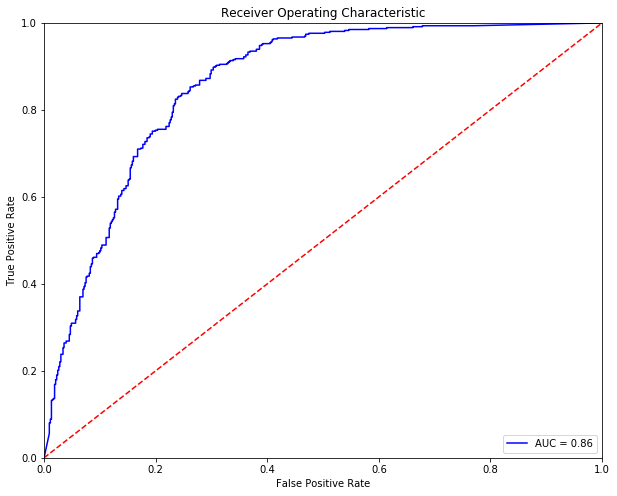

Optimal Threshold is 0.543267283209
Accuracy of Logistic Model on training data is: 0.774420946626


Predicted  0.0  1.0  __all__
Actual                      
0.0        411  120      531
1.0        104  358      462
__all__    515  478      993

In [88]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [89]:
table_80_50_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [90]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False           True                0.7       100  multinomial   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  1e-05

Accuracy of the  Logistic  model for the training data is: 0.790627362056

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1545   405     1950
1           426  1593     2019
__all__    1971  1998     3969

Accuracy of the  Logistic  model for test data is: 0.780463242699

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          406  125      531
1           93  369      462
__all__    499  494      993

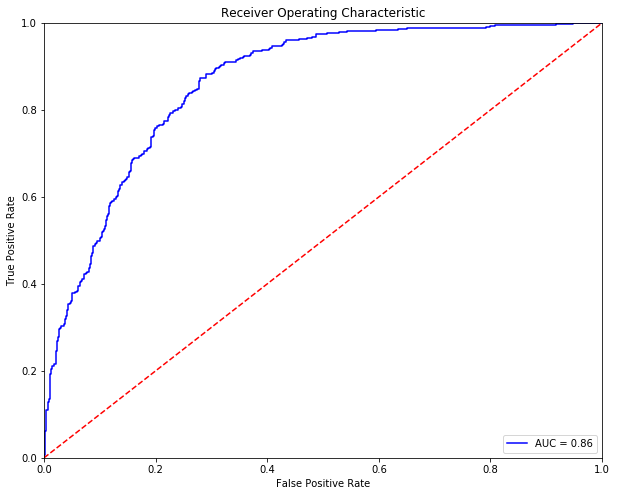

Optimal Threshold is 0.518694763309
Accuracy of Logistic Model on training data is: 0.777442094663


Predicted  0.0  1.0  __all__
Actual                      
0.0        414  117      531
1.0        104  358      462
__all__    518  475      993

In [91]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [92]:
table_80_50_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [93]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0        entropy         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.798437893676

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1521   429     1950
1           371  1648     2019
__all__    1892  2077     3969

Accuracy of the  Random Forest Trees  model for test data is: 0.788519637462

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          404  127      531
1           83  379      462
__all__    487  506      993

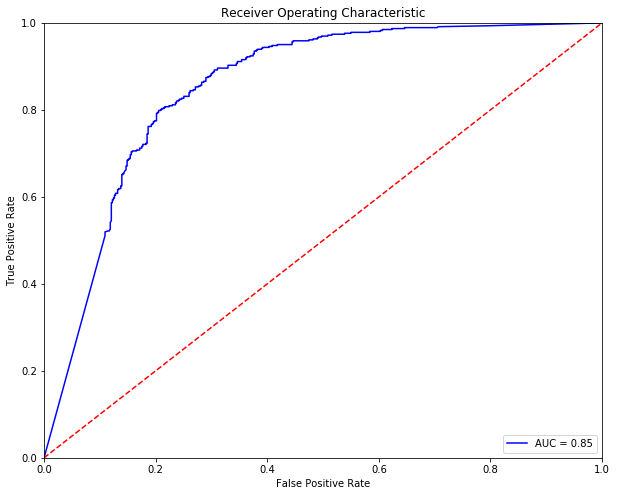

Optimal Threshold is 0.6534482181
Accuracy of Logistic Model on training data is: 0.79556898288


Predicted  0.0  1.0  __all__
Actual                      
0.0        423  108      531
1.0         95  367      462
__all__    518  475      993

In [94]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [95]:
table_80_50_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

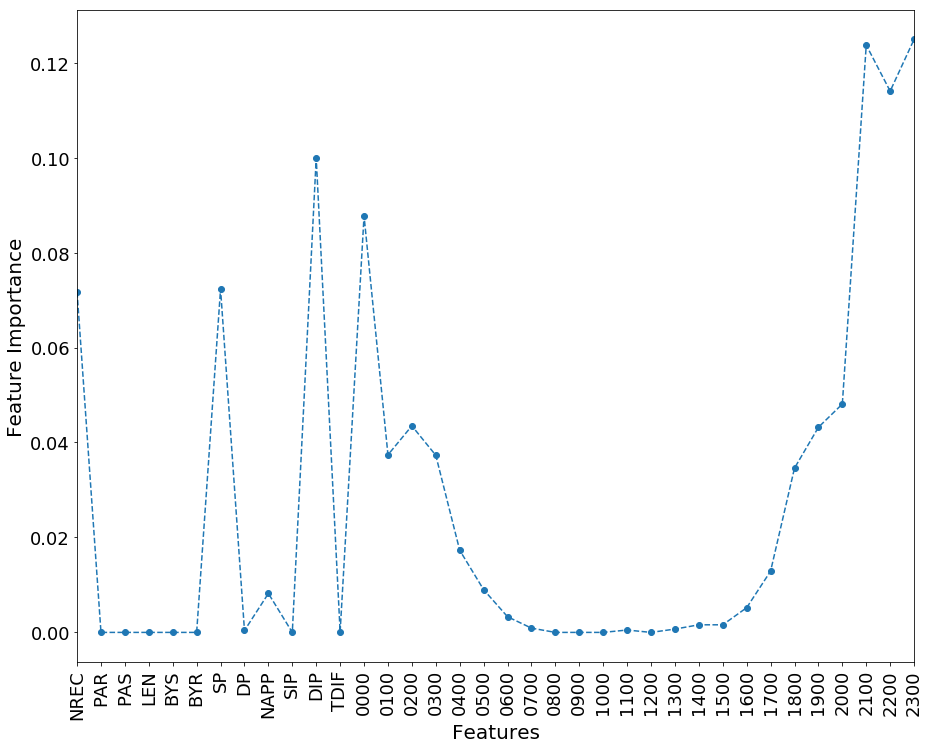

In [96]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [97]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0        SAMME.R            0.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.805240614764

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1508   442     1950
1           331  1688     2019
__all__    1839  2130     3969

Accuracy of the  AdaBoostClassifier  model for test data is: 0.793554884189

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          402  129      531
1           76  386      462
__all__    478  515      993

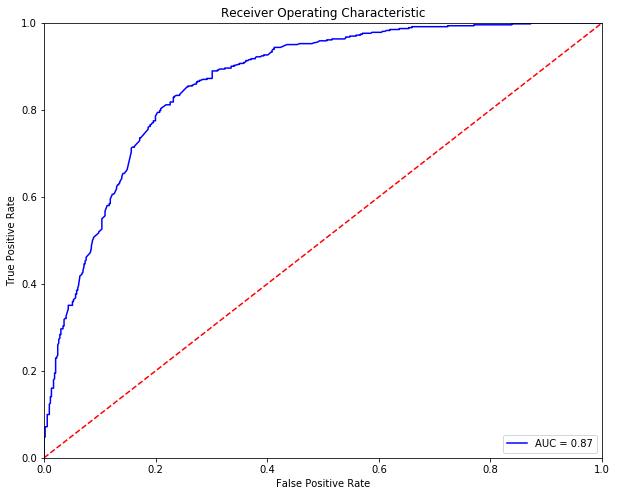

Optimal Threshold is 0.505051831886
Accuracy of Logistic Model on training data is: 0.794561933535


Predicted  0.0  1.0  __all__
Actual                      
0.0        422  109      531
1.0         95  367      462
__all__    517  476      993

In [98]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [99]:
table_80_50_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

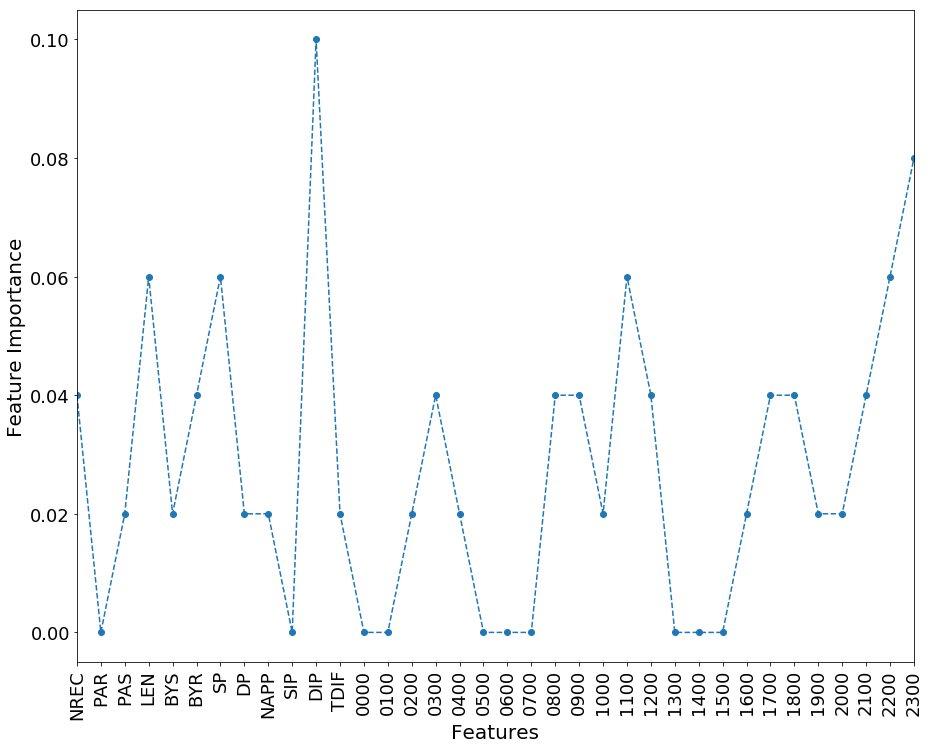

In [100]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [101]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse            0.1  exponential                15   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1            50             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.814814814815

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1522   428     1950
1           307  1712     2019
__all__    1829  2140     3969

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.780463242699

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          388  143      531
1           75  387      462
__all__    463  530      993

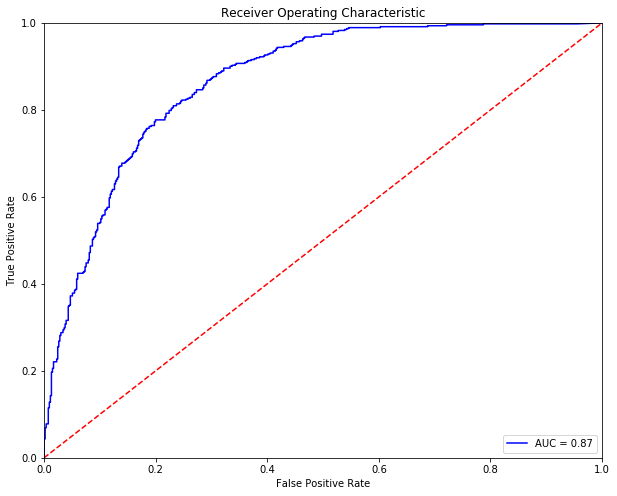

Optimal Threshold is 0.589090648742
Accuracy of Logistic Model on training data is: 0.78247734139


Predicted  0.0  1.0  __all__
Actual                      
0.0        416  115      531
1.0        101  361      462
__all__    517  476      993

In [102]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [103]:
table_80_50_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

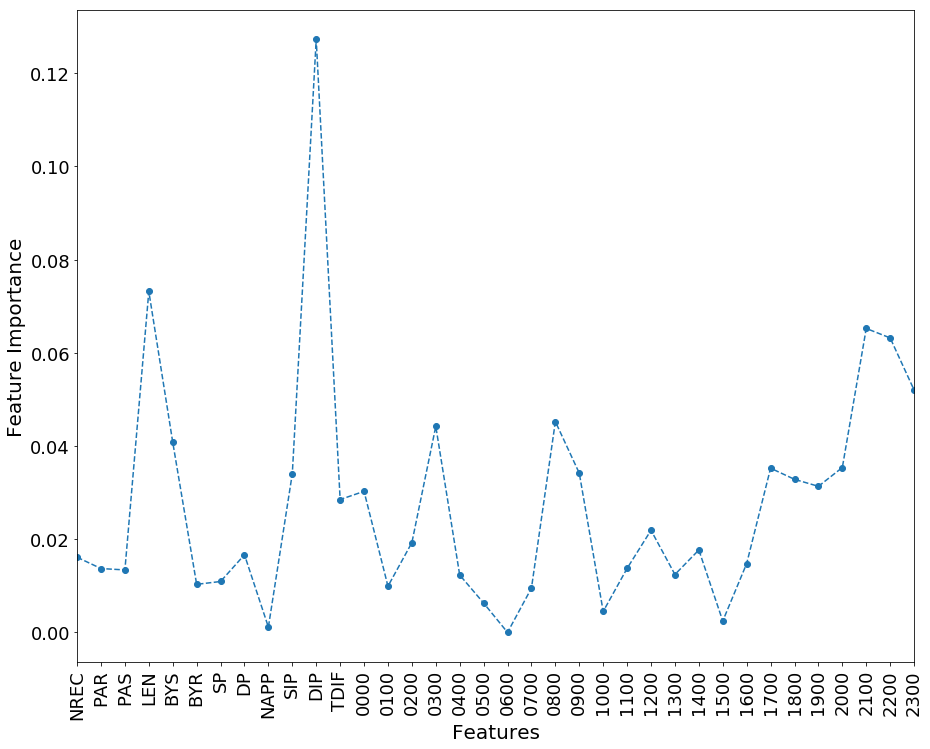

In [104]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [105]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     5                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.804484756866

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1545   405     1950
1           371  1648     2019
__all__    1916  2053     3969

Accuracy of the  Extra Decision Tree  model for test data is: 0.778449144008

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          400  131      531
1           89  373      462
__all__    489  504      993

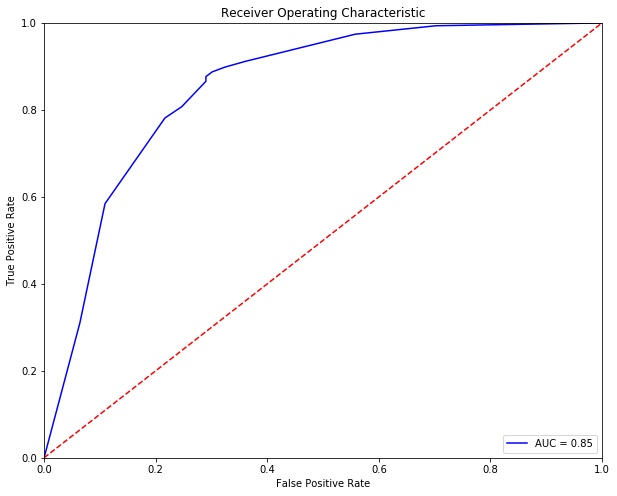

Optimal Threshold is 0.691358024691
Accuracy of Logistic Model on training data is: 0.748237663646


Predicted  0.0  1.0  __all__
Actual                      
0.0        473   58      531
1.0        192  270      462
__all__    665  328      993

In [106]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [107]:
table_80_50_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [108]:
%%capture
table_80_50_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

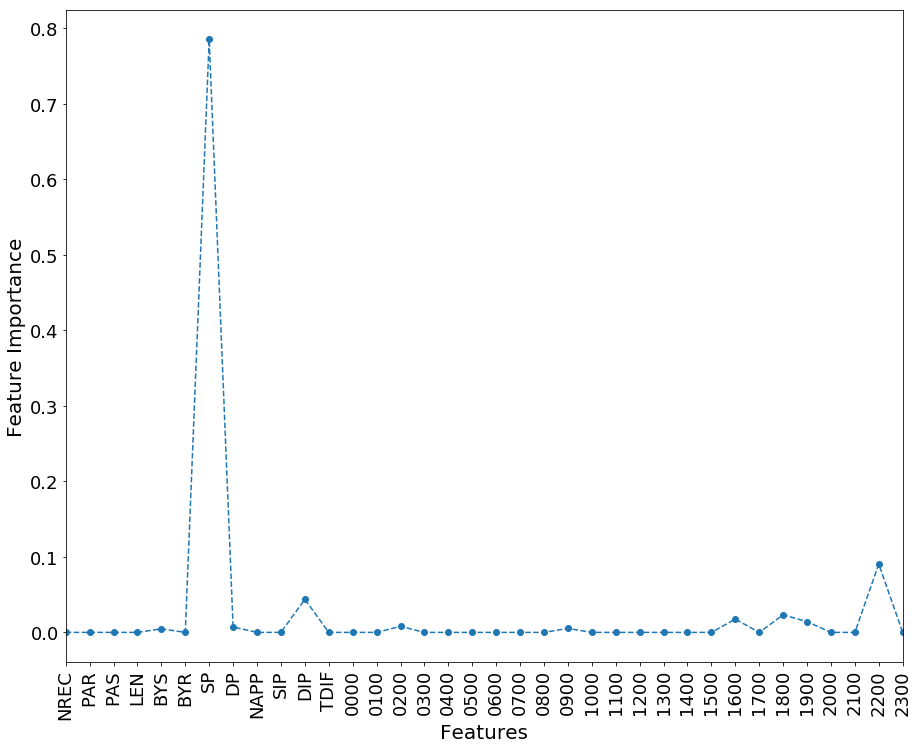

In [109]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [110]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.2          0.4          1500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.920634920635

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1741   209     1950
1           106  1913     2019
__all__    1847  2122     3969

Accuracy of the  Bagging  model for test data is: 0.790533736153

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          403  128      531
1           80  382      462
__all__    483  510      993

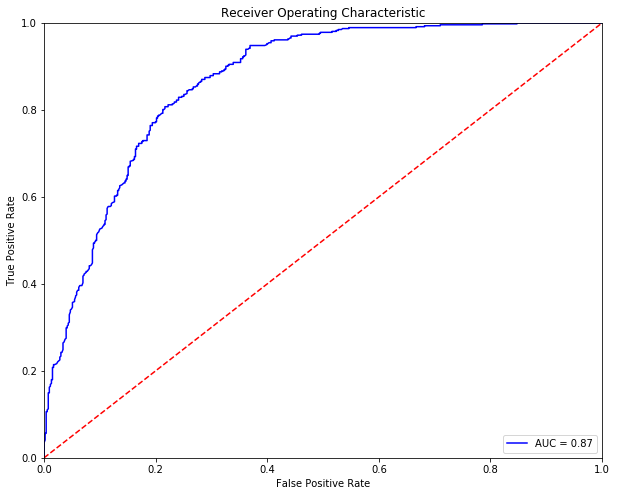

Optimal Threshold is 0.575333333333
Accuracy of Logistic Model on training data is: 0.790533736153


Predicted  0.0  1.0  __all__
Actual                      
0.0        420  111      531
1.0         97  365      462
__all__    517  476      993

In [111]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [112]:
table_80_50_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [113]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.907281431091


Predicted     0     1  __all__
Actual                        
0          1726   224     1950
1           144  1875     2019
__all__    1870  2099     3969

The test accuracy is: 0.774420946626


Predicted    0    1  __all__
Actual                      
0          394  137      531
1           87  375      462
__all__    481  512      993

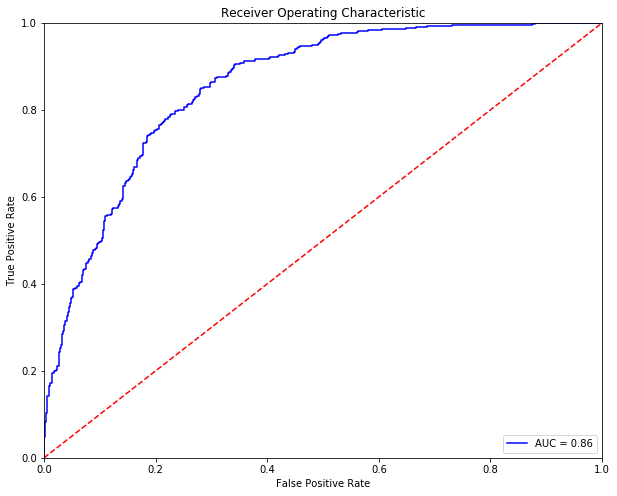

Optimal Threshold is 0.562232288257
Accuracy of Logistic Model on training data is: 0.779456193353


Predicted  0.0  1.0  __all__
Actual                      
0.0        414  117      531
1.0        102  360      462
__all__    516  477      993

In [114]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [115]:
table_80_50_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [116]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.928697404888


Predicted     0     1  __all__
Actual                        
0          1848   102     1950
1           181  1838     2019
__all__    2029  1940     3969

The accuracy of the model on test data is: 0.744209466264


Predicted    0    1  __all__
Actual                      
0          388  143      531
1          111  351      462
__all__    499  494      993

 32/993 [..............................] - ETA: 0s

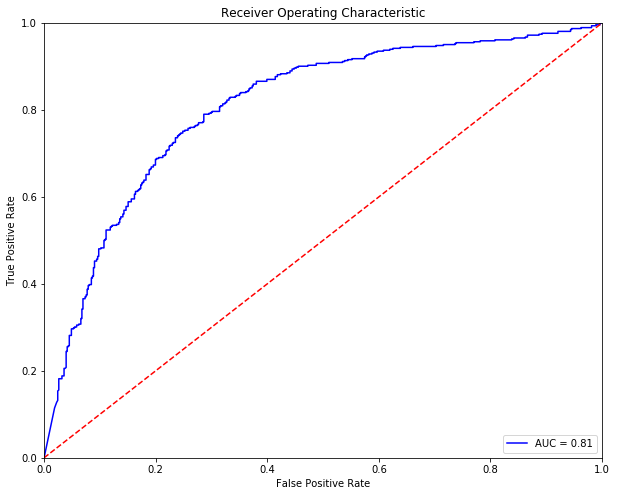

Optimal Threshold is 0.544007
Accuracy of Logistic Model on training data is: 0.750251762336


Predicted  0.0  1.0  __all__
Actual                      
0.0        399  132      531
1.0        116  346      462
__all__    515  478      993

In [117]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [118]:
table_80_50_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [119]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.0min finished


The accuracy of the model on training data is: 0.808012093726


Predicted     0     1  __all__
Actual                        
0          1477   473     1950
1           289  1730     2019
__all__    1766  2203     3969

The accuracy of the model on test data is: 0.790533736153


Predicted    0    1  __all__
Actual                      
0          392  139      531
1           69  393      462
__all__    461  532      993

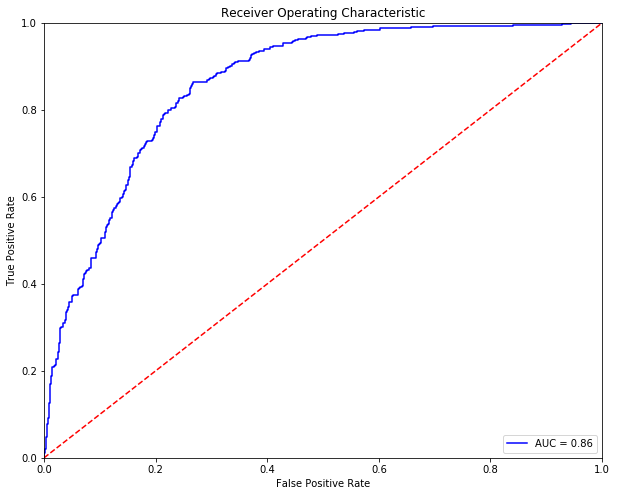

Optimal Threshold is 0.595109
Accuracy of Logistic Model on training data is: 0.786505538771


Predicted  0.0  1.0  __all__
Actual                      
0.0        418  113      531
1.0         99  363      462
__all__    517  476      993

In [120]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [121]:
table_80_50_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [122]:
table_80_50_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_20_test.set_index(['index'],drop=True,inplace=True)
table_80_50_20_train.set_index(['index'],drop=True,inplace=True)
table_80_50_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_20_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_20_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  2019.0  1950.0    0.0    0.0  0.000000   
LogisticRegression          0.790627  1593.0  1545.0  405.0  426.0  0.207692   
RandomForestClassifier      0.798438  1648.0  1521.0  429.0  371.0  0.220000   
AdaBoostClassifier          0.805241  1688.0  1508.0  442.0  331.0  0.226667   
GradientBoostingClassifier  0.814815  1712.0  1522.0  428.0  307.0  0.219487   
ExtraTreeClassifier         0.804485  1648.0  1545.0  405.0  371.0  0.207692   
BaggingClassifier           0.920635  1913.0  1741.0  209.0  106.0  0.107179   
VotingClassifier            0.907281  1875.0  1726.0  224.0  144.0  0.114872   
Neural Network-1            0.928697  1838.0  1848.0  102.0  181.0  0.052308   
Neural-Network-2            0.808012  1730.0  1477.0  473.0  289.0  0.242564   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.210996  
RandomForestClassifier      0.183754  
AdaBoostClassifier          0.163943  
GradientBoostingClassifier  0.152055  
ExtraTreeClassifier         0.183754  
BaggingClassifier           0.052501  
VotingClassifier            0.071322  
Neural Network-1            0.089648  
Neural-Network-2            0.143140

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.786506  373.0  408.0  123.0   89.0  0.231638   
LogisticRegression          0.780463  369.0  406.0  125.0   93.0  0.235405   
RandomForestClassifier      0.788520  379.0  404.0  127.0   83.0  0.239171   
AdaBoostClassifier          0.793555  386.0  402.0  129.0   76.0  0.242938   
GradientBoostingClassifier  0.780463  387.0  388.0  143.0   75.0  0.269303   
ExtraTreeClassifier         0.778449  373.0  400.0  131.0   89.0  0.246704   
BaggingClassifier           0.790534  382.0  403.0  128.0   80.0  0.241055   
VotingClassifier            0.774421  375.0  394.0  137.0   87.0  0.258004   
Neural Network-1            0.744209  351.0  388.0  143.0  111.0  0.269303   
Neural-Network-2            0.790534  393.0  392.0  139.0   69.0  0.261770   

                                 FNR  
index                                 
KNeighborsClassifier        0.192641  
LogisticRegression          0.201299  
RandomForestClassifier      0.179654  
AdaBoostClassifier          0.164502  
GradientBoostingClassifier  0.162338  
ExtraTreeClassifier         0.192641  
BaggingClassifier           0.173160  
VotingClassifier            0.188312  
Neural Network-1            0.240260  
Neural-Network-2            0.149351

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.774421  358.0  411.0  120.0  104.0  0.225989   
LogisticRegression          0.777442  358.0  414.0  117.0  104.0  0.220339   
RandomForestClassifier      0.795569  367.0  423.0  108.0   95.0  0.203390   
AdaBoostClassifier          0.794562  367.0  422.0  109.0   95.0  0.205273   
GradientBoostingClassifier  0.782477  361.0  416.0  115.0  101.0  0.216573   
ExtraTreeClassifier         0.748238  270.0  473.0   58.0  192.0  0.109228   
BaggingClassifier           0.790534  365.0  420.0  111.0   97.0  0.209040   
VotingClassifier            0.779456  360.0  414.0  117.0  102.0  0.220339   
Neural Network-1            0.750252  346.0  399.0  132.0  116.0  0.248588   
Neural-Network-2            0.786506  363.0  418.0  113.0   99.0  0.212806   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.225108   0.543267  0.859185  
LogisticRegression          0.225108   0.518695  0.862572  
RandomForestClassifier      0.205628   0.653448  0.853592  
AdaBoostClassifier          0.205628   0.505052  0.865122  
GradientBoostingClassifier  0.218615   0.589091  0.866321  
ExtraTreeClassifier         0.415584   0.691358  0.851746  
BaggingClassifier           0.209957   0.575333  0.867073  
VotingClassifier            0.220779   0.562232  0.856927  
Neural Network-1            0.251082   0.544007  0.807343  
Neural-Network-2            0.214286   0.595109  0.860832

###  <a id='1.B' style="text-decoration : none; color : #000000;">B. 70:30 Train Test Split</a>
#### Random State 0

In [123]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     4    1.00000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  9326  236.40564   

                                                           PAS        LEN  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...    1.000000  31.000000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  130.825005  78.920437   

                                                             BYS  \
Source_User                                                        
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     77.500000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  16523.837122   

                                                              BYR      SP  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     225.750000     4.0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  308234.733219  7070.0   

                                                      DP  NAPP  SIP   DIP  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...   1.0     1    1     1   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  26.0    47   74  1610   

                                                          TDIF  0000  0100  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...    0.250000     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  796.853957   528   582   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   519   540   512   417   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   421   626   360   346   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   223   308   207   272   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   844   136   298   175   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     4     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   259   359   259   323   

                                                    2200  2300  
Source_User                                                     
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0  
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   397   415

In [124]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1193b2d05e46c2e870    0
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c1f6ca9d117f8b3530    1
c2cf660ad094544b4bb8f01efb417804cfa5d53624783c2f784faac2b244c029    1
3fcd1179a650c2cfc6b6d23aa0193f8247ea56691044389f53a1e771431e2862    0
55394724a0a52464de210c953c5e6bee779e0f0a163aa4787087024004caeb82    1
327686c9e4533b14641208d230f5d01b93dcdd21d71360fbcac0d78d487c58ab    0
bc72f41bcdc4b3e5ee020baae91eb97b6c4ca7a1209ed7a69f4f0915de990aa2    0
d49890688b35443d361df19e2bfeaeddeda4d5572c03cf5678f9b36e01cf5415    1
01c615bd6e5026eb8f8ce76567d9f00c3eec2b1752da1854ece27439da4c0fe9    0
469c1c634cf9e6412e08bda889e471ef6af563097f737223a09ad50e7364cfa9    0
Name: Target, dtype: int64

In [125]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [126]:
## Table to store training and test measures
table_70_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [127]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3        4
index  algorithm  leaf_size     metric  n_neighbors  weights
0           auto          2  manhattan           30  uniform

Accuracy of the  KNN  model for the training data is: 0.805067664843

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1425   341     1766
1           336  1371     1707
__all__    1761  1712     3473

Accuracy of the  KNN  model for test data is: 0.793149764943

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          580  135      715
1          173  601      774
__all__    753  736     1489

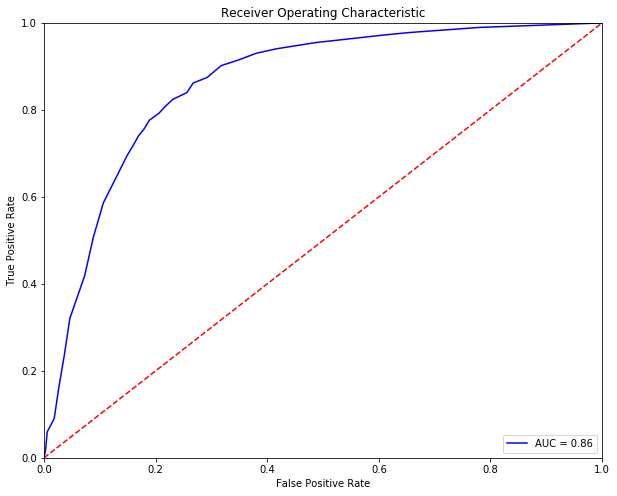

Optimal Threshold is 0.5
Accuracy of Logistic Model on training data is: 0.793149764943


Predicted  0.0  1.0  __all__
Actual                      
0.0        580  135      715
1.0        173  601      774
__all__    753  736     1489

In [128]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [129]:
table_70_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [130]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False           True                0.7       100  multinomial   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.793550244745

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1428   338     1766
1           379  1328     1707
__all__    1807  1666     3473

Accuracy of the  Logistic  model for test data is: 0.781061114842

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          582  133      715
1          193  581      774
__all__    775  714     1489

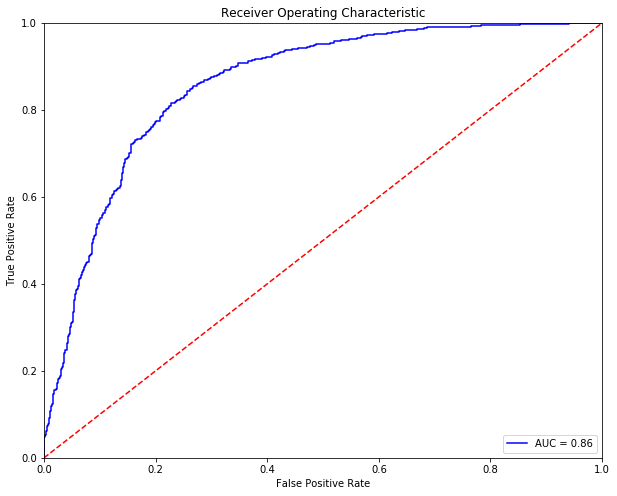

Optimal Threshold is 0.475578606565
Accuracy of Logistic Model on training data is: 0.787777031565


Predicted  0.0  1.0  __all__
Actual                      
0.0        564  151      715
1.0        165  609      774
__all__    729  760     1489

In [131]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [132]:
table_70_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [133]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.801900374316

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1389   377     1766
1           311  1396     1707
__all__    1700  1773     3473

Accuracy of the  Random Forest Trees  model for test data is: 0.789791806582

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          558  157      715
1          156  618      774
__all__    714  775     1489

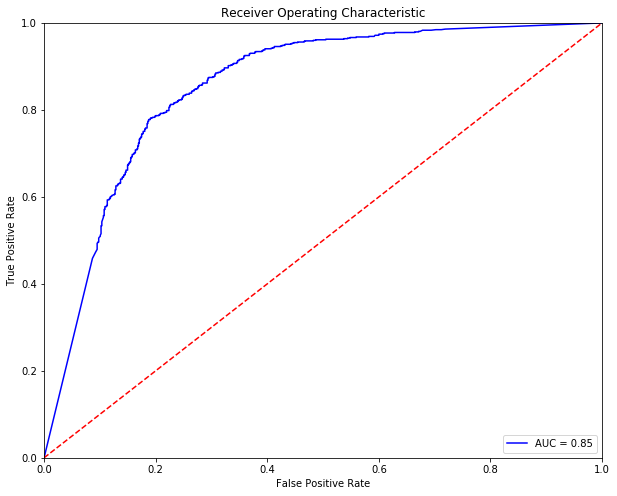

Optimal Threshold is 0.541031836758
Accuracy of Logistic Model on training data is: 0.791134989926


Predicted  0.0  1.0  __all__
Actual                      
0.0        566  149      715
1.0        162  612      774
__all__    728  761     1489

In [134]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [135]:
table_70_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

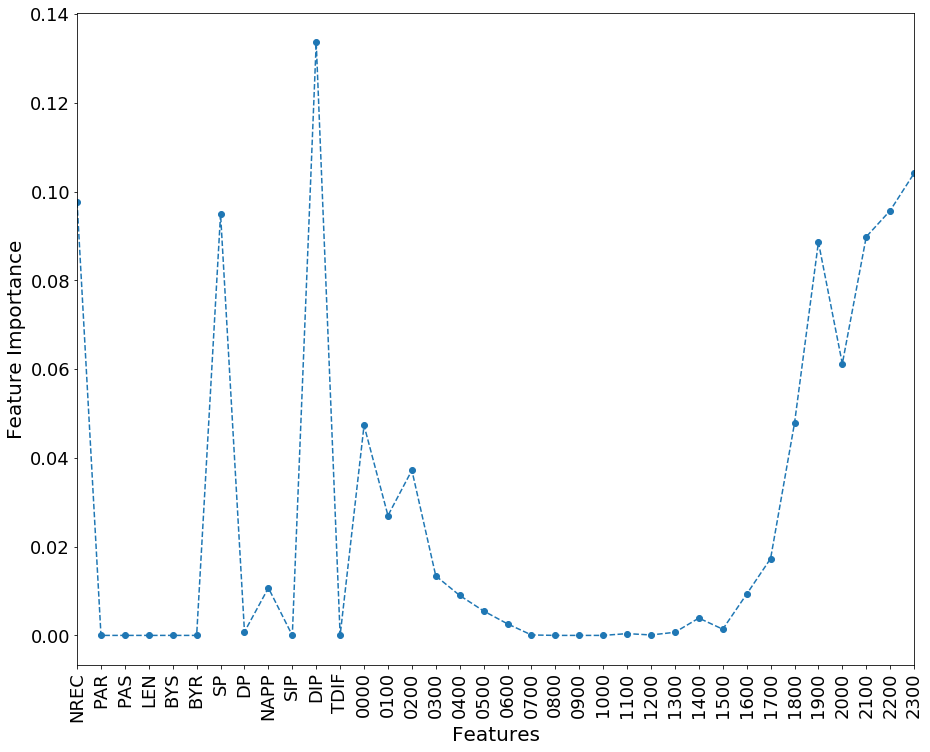

In [136]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [137]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0        SAMME.R            0.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.804779729341

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1390   376     1766
1           302  1405     1707
__all__    1692  1781     3473

Accuracy of the  AdaBoostClassifier  model for test data is: 0.791806581598

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          556  159      715
1          151  623      774
__all__    707  782     1489

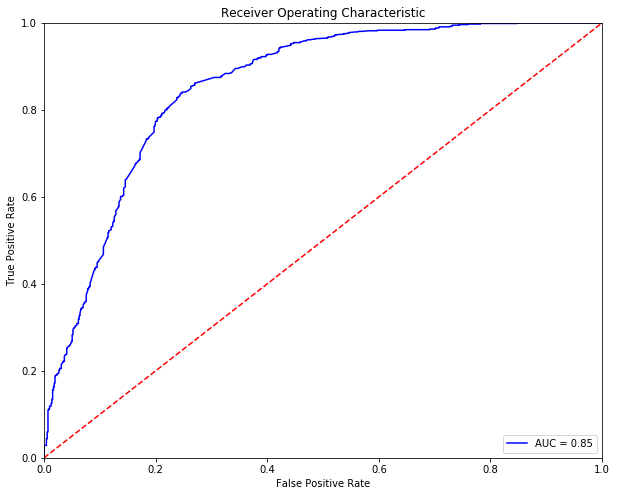

Optimal Threshold is 0.502770617659
Accuracy of Logistic Model on training data is: 0.788448623237


Predicted  0.0  1.0  __all__
Actual                      
0.0        564  151      715
1.0        164  610      774
__all__    728  761     1489

In [138]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [139]:
table_70_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

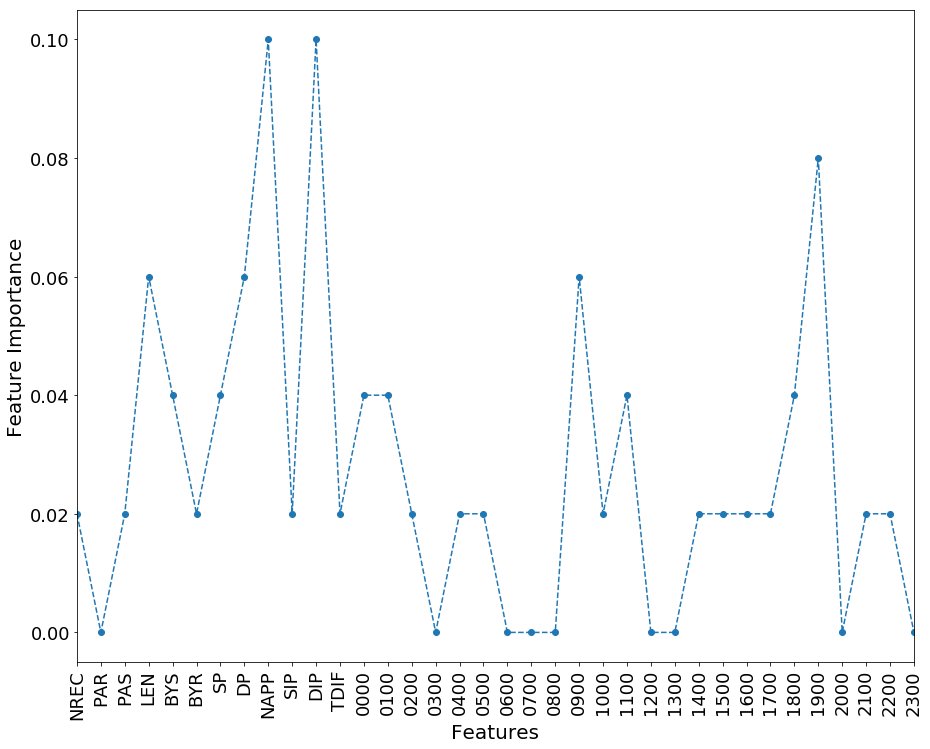

In [140]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [141]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse            0.2  exponential                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.3            50             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.816009213936

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1364   402     1766
1           237  1470     1707
__all__    1601  1872     3473

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.793821356615

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          542  173      715
1          134  640      774
__all__    676  813     1489

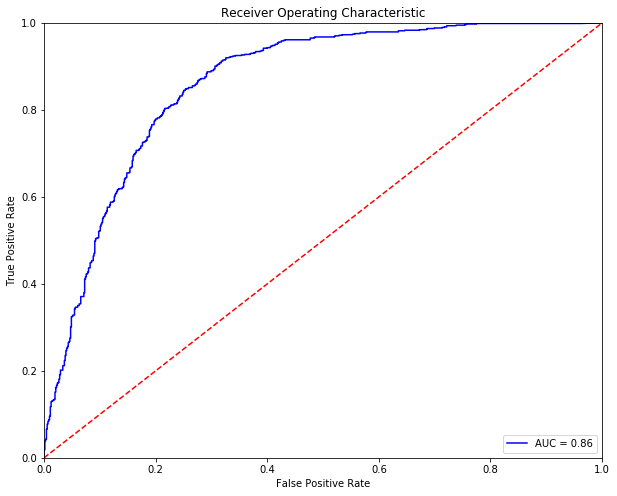

Optimal Threshold is 0.583567073183
Accuracy of Logistic Model on training data is: 0.788448623237


Predicted  0.0  1.0  __all__
Actual                      
0.0        564  151      715
1.0        164  610      774
__all__    728  761     1489

In [142]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [143]:
table_70_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

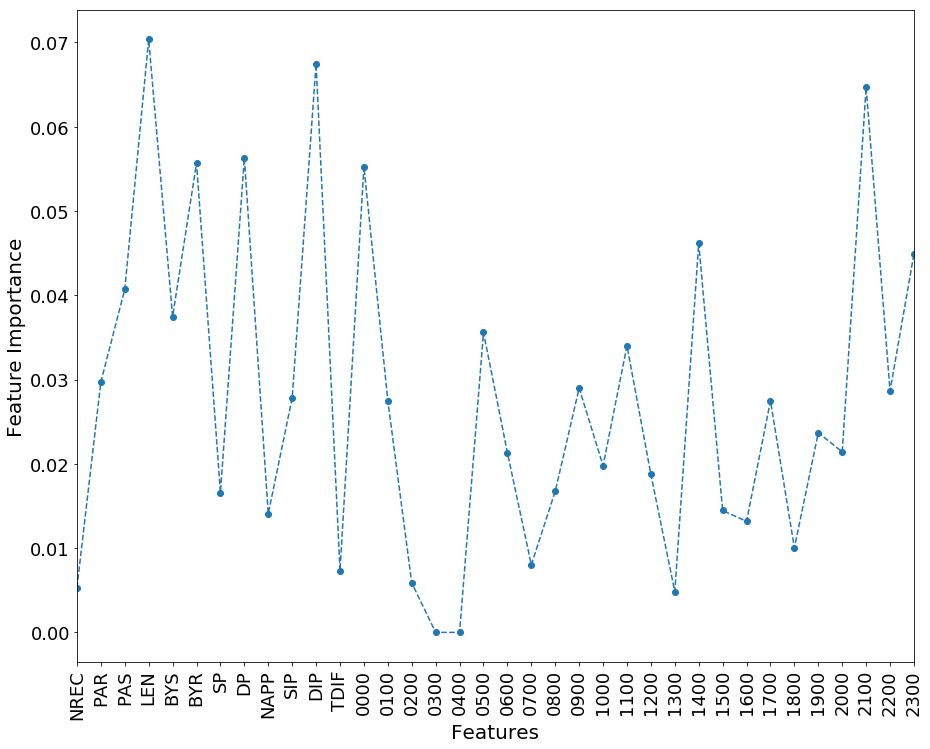

In [144]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [145]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                    0.1   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.798733083789

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1389   377     1766
1           322  1385     1707
__all__    1711  1762     3473

Accuracy of the  Extra Decision Tree  model for test data is: 0.785762256548

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          554  161      715
1          158  616      774
__all__    712  777     1489

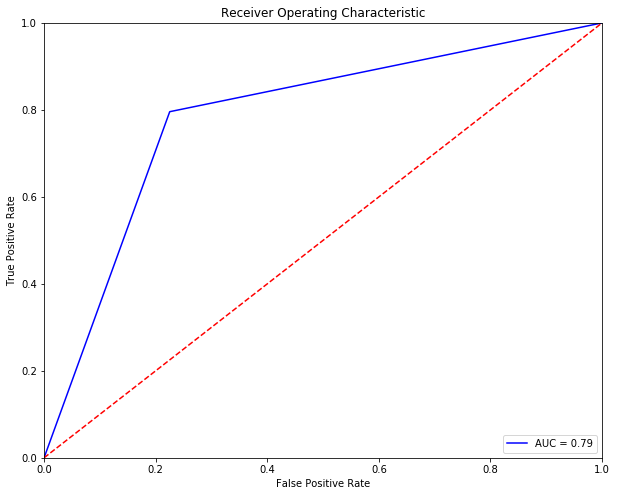

Optimal Threshold is 0.786038592509
Accuracy of Logistic Model on training data is: 0.480188045668


Predicted   0.0  1.0  __all__
Actual                       
0.0         715    0      715
1.0         774    0      774
__all__    1489    0     1489

In [146]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [147]:
table_70_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [148]:
%%capture
table_70_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

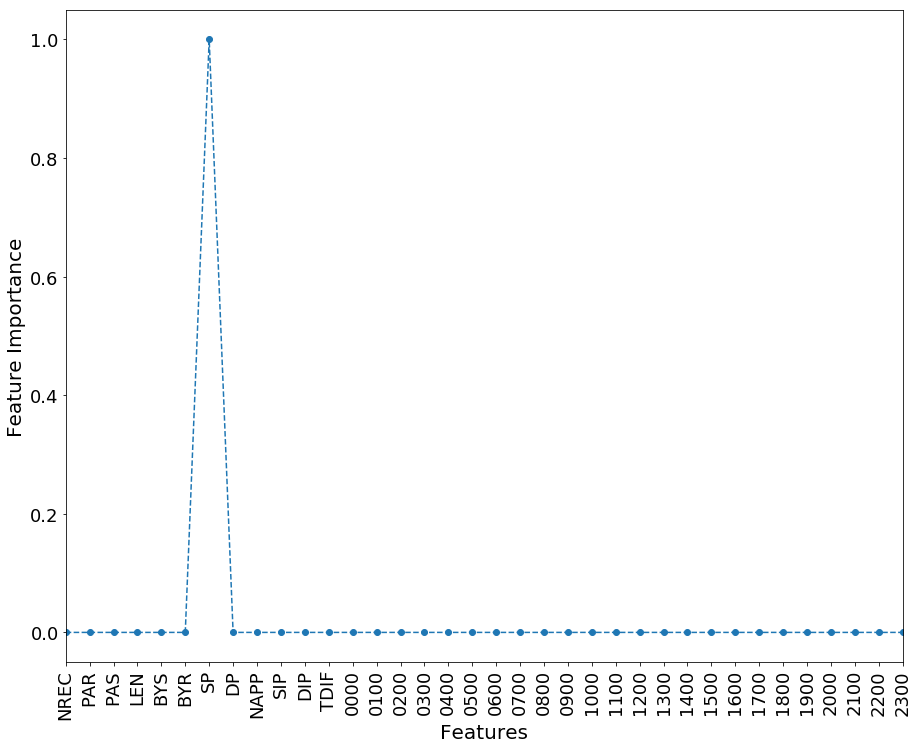

In [149]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [150]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.3          1000   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.884825799021

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1494   272     1766
1           128  1579     1707
__all__    1622  1851     3473

Accuracy of the  Bagging  model for test data is: 0.799194089993

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          552  163      715
1          136  638      774
__all__    688  801     1489

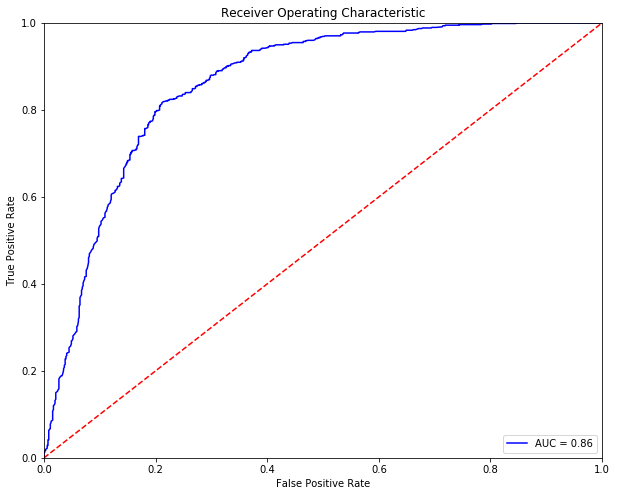

Optimal Threshold is 0.54
Accuracy of Logistic Model on training data is: 0.797850906649


Predicted  0.0  1.0  __all__
Actual                      
0.0        571  144      715
1.0        157  617      774
__all__    728  761     1489

In [151]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [152]:
table_70_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [153]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.904405413187


Predicted     0     1  __all__
Actual                        
0          1561   205     1766
1           127  1580     1707
__all__    1688  1785     3473

The test accuracy is: 0.78643384822


Predicted    0    1  __all__
Actual                      
0          549  166      715
1          152  622      774
__all__    701  788     1489

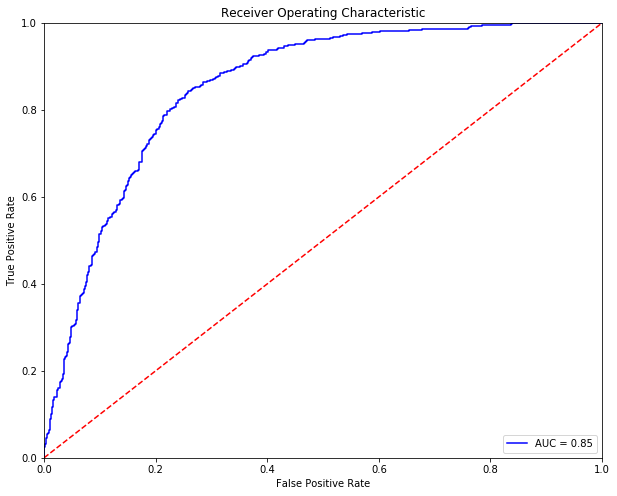

Optimal Threshold is 0.531002442151
Accuracy of Logistic Model on training data is: 0.785762256548


Predicted  0.0  1.0  __all__
Actual                      
0.0        562  153      715
1.0        166  608      774
__all__    728  761     1489

In [154]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [155]:
table_70_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [156]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.944428448045


Predicted     0     1  __all__
Actual                        
0          1712    54     1766
1           139  1568     1707
__all__    1851  1622     3473

The accuracy of the model on test data is: 0.73002014775


Predicted    0    1  __all__
Actual                      
0          541  174      715
1          228  546      774
__all__    769  720     1489

1408/1489 [===========================>..] - ETA: 0s

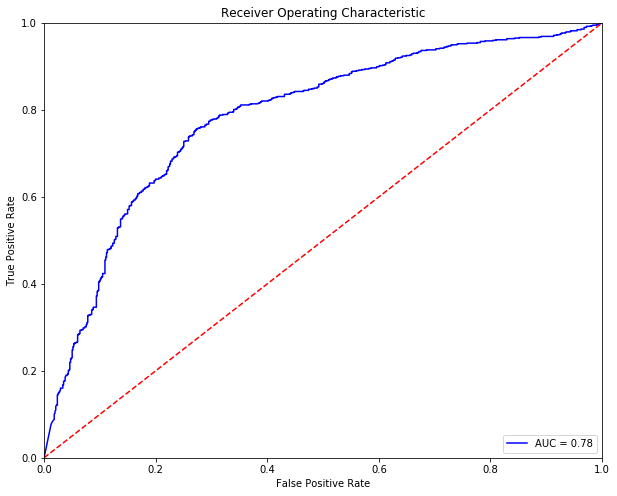

Optimal Threshold is 0.415238
Accuracy of Logistic Model on training data is: 0.739422431162


Predicted  0.0  1.0  __all__
Actual                      
0.0        529  186      715
1.0        202  572      774
__all__    731  758     1489

In [157]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [158]:
table_70_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [159]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.1min finished


The accuracy of the model on training data is: 0.811402245897


Predicted     0     1  __all__
Actual                        
0          1387   379     1766
1           276  1431     1707
__all__    1663  1810     3473

The accuracy of the model on test data is: 0.790463398254


Predicted    0    1  __all__
Actual                      
0          545  170      715
1          142  632      774
__all__    687  802     1489

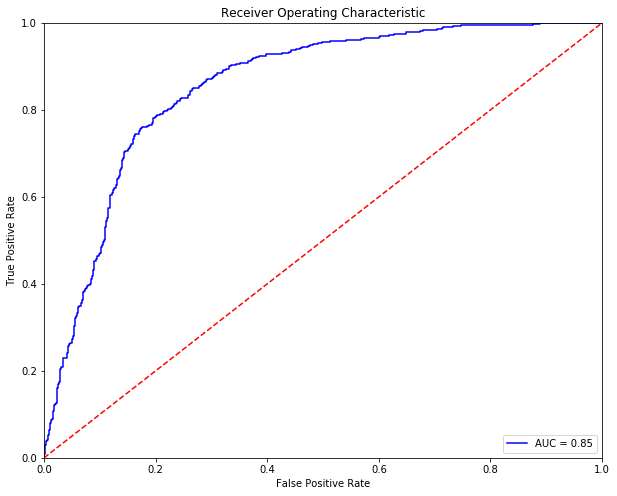

Optimal Threshold is 0.53339
Accuracy of Logistic Model on training data is: 0.790463398254


Predicted  0.0  1.0  __all__
Actual                      
0.0        566  149      715
1.0        163  611      774
__all__    729  760     1489

In [160]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [161]:
table_70_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [162]:
table_70_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_50_test.set_index(['index'],drop=True,inplace=True)
table_70_50_train.set_index(['index'],drop=True,inplace=True)
table_70_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_50_train)

print("Comparision Table for Test Accuracies:")
display(table_70_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_50_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        0.805068  1371.0  1425.0  341.0  336.0  0.193092   
LogisticRegression          0.793550  1328.0  1428.0  338.0  379.0  0.191393   
RandomForestClassifier      0.801900  1396.0  1389.0  377.0  311.0  0.213477   
AdaBoostClassifier          0.804780  1405.0  1390.0  376.0  302.0  0.212911   
GradientBoostingClassifier  0.816009  1470.0  1364.0  402.0  237.0  0.227633   
ExtraTreeClassifier         0.798733  1385.0  1389.0  377.0  322.0  0.213477   
BaggingClassifier           0.884826  1579.0  1494.0  272.0  128.0  0.154020   
VotingClassifier            0.904405  1580.0  1561.0  205.0  127.0  0.116082   
Neural Network-1            0.944428  1568.0  1712.0   54.0  139.0  0.030578   
Neural-Network-2            0.811402  1431.0  1387.0  379.0  276.0  0.214609   

                                 FNR  
index                                 
KNeighborsClassifier        0.196837  
LogisticRegression          0.222027  
RandomForestClassifier      0.182191  
AdaBoostClassifier          0.176919  
GradientBoostingClassifier  0.138840  
ExtraTreeClassifier         0.188635  
BaggingClassifier           0.074985  
VotingClassifier            0.074400  
Neural Network-1            0.081429  
Neural-Network-2            0.161687

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.793150  601.0  580.0  135.0  173.0  0.188811   
LogisticRegression          0.781061  581.0  582.0  133.0  193.0  0.186014   
RandomForestClassifier      0.789792  618.0  558.0  157.0  156.0  0.219580   
AdaBoostClassifier          0.791807  623.0  556.0  159.0  151.0  0.222378   
GradientBoostingClassifier  0.793821  640.0  542.0  173.0  134.0  0.241958   
ExtraTreeClassifier         0.785762  616.0  554.0  161.0  158.0  0.225175   
BaggingClassifier           0.799194  638.0  552.0  163.0  136.0  0.227972   
VotingClassifier            0.786434  622.0  549.0  166.0  152.0  0.232168   
Neural Network-1            0.730020  546.0  541.0  174.0  228.0  0.243357   
Neural-Network-2            0.790463  632.0  545.0  170.0  142.0  0.237762   

                                 FNR  
index                                 
KNeighborsClassifier        0.223514  
LogisticRegression          0.249354  
RandomForestClassifier      0.201550  
AdaBoostClassifier          0.195090  
GradientBoostingClassifier  0.173127  
ExtraTreeClassifier         0.204134  
BaggingClassifier           0.175711  
VotingClassifier            0.196382  
Neural Network-1            0.294574  
Neural-Network-2            0.183463

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy          TP          TN          FP  \
index                                                                      
KNeighborsClassifier        0.793150  601.000000  580.000000  135.000000   
LogisticRegression          0.787777  609.000000  564.000000  151.000000   
RandomForestClassifier      0.791135  612.000000  566.000000  149.000000   
AdaBoostClassifier          0.788449  610.000000  564.000000  151.000000   
GradientBoostingClassifier  0.788449  610.000000  564.000000  151.000000   
ExtraTreeClassifier         0.480188  343.334453  371.665547  371.665547   
BaggingClassifier           0.797851  617.000000  571.000000  144.000000   
VotingClassifier            0.785762  608.000000  562.000000  153.000000   
Neural Network-1            0.739422  572.000000  529.000000  186.000000   
Neural-Network-2            0.790463  611.000000  566.000000  149.000000   

                                    FN       FPR       FNR  threshold  \
index                                                                   
KNeighborsClassifier        173.000000  0.188811  0.223514   0.500000   
LogisticRegression          165.000000  0.211189  0.213178   0.475579   
RandomForestClassifier      162.000000  0.208392  0.209302   0.541032   
AdaBoostClassifier          164.000000  0.211189  0.211886   0.502771   
GradientBoostingClassifier  164.000000  0.211189  0.211886   0.583567   
ExtraTreeClassifier         402.334453  0.480188  0.519812   0.786039   
BaggingClassifier           157.000000  0.201399  0.202842   0.540000   
VotingClassifier            166.000000  0.213986  0.214470   0.531002   
Neural Network-1            202.000000  0.260140  0.260982   0.415238   
Neural-Network-2            163.000000  0.208392  0.210594   0.533390   

                                 auc  
index                                 
KNeighborsClassifier        0.861029  
LogisticRegression          0.858718  
RandomForestClassifier      0.854947  
AdaBoostClassifier          0.853550  
GradientBoostingClassifier  0.861302  
ExtraTreeClassifier         0.785345  
BaggingClassifier           0.861161  
VotingClassifier            0.852724  
Neural Network-1            0.783227  
Neural-Network-2            0.854341

#### Random State 10

In [163]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...   558  87.706093   
384ed706777916e315308d41eb2efc086edc768b6392e14...     3  29.333333   

                                                          PAS         LEN  \
Source_User                                                                 
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  25.094982  106.747312   
384ed706777916e315308d41eb2efc086edc768b6392e14...  22.000000  363.000000   

                                                            BYS  \
Source_User                                                       
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  3436.492832   
384ed706777916e315308d41eb2efc086edc768b6392e14...  5405.333333   

                                                              BYR     SP  \
Source_User                                                                
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  103496.745520  539.0   
384ed706777916e315308d41eb2efc086edc768b6392e14...    3980.666667    3.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  20.0    42   47  230   
384ed706777916e315308d41eb2efc086edc768b6392e14...   1.0     2    1    2   

                                                           TDIF  0000  0100  \
Source_User                                                                   
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  7309.743728     5     4   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0.000000     0     0   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     0     0     0     0   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     4    31    14     3   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     3   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     3     4    16    18   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...    20    74    81    71   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...   116    42    32    10   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    2200  2300  
Source_User                                                     
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     4     6  
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0

In [164]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7ec769d861466ae859    0
384ed706777916e315308d41eb2efc086edc768b6392e14751b4d9bca760a59e    0
25fbc1afa01f04686e25d7cffb238ca43ffeb865a4e6c1d07029f2fd8dcfcd32    1
b522e1c3ad002eddf9145e38f7f0a2be9c45895d718c7977e0a6a2a7becb3a10    1
8eba4debb95ef877faed7041269483166a3145a7a590cba966da0a5aa394f2f3    1
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
8389fdb8a5b9d6fff6c3eb065c2f0eeaeb6931647d7ff91de731a82a98c197c5    0
d0d0439bceb5f83d975bd909d12ad0f8a13766371c2a092a446febf0f7b08f5c    1
2587a851f09c2bb4d22b7daf8ec30af164ad94a7f5d1620d60d271b85fff6f64    1
841bc27abf403835526548adc7b881573c654cc78cb11b9e064c7b9682a89709    0
Name: Target, dtype: int64

In [165]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [166]:
## Table to store training and test measures
table_70_50_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [167]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1743     0     1743
1             0  1730     1730
__all__    1743  1730     3473

Accuracy of the  KNN  model for test data is: 0.809939556749

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          596  142      738
1          141  610      751
__all__    737  752     1489

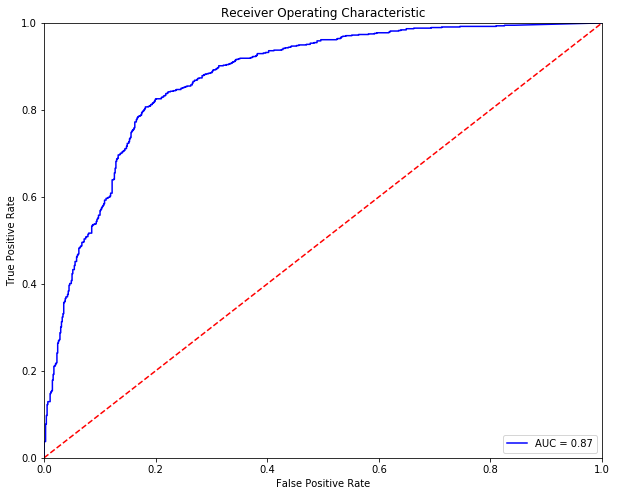

Optimal Threshold is 0.50514311629
Accuracy of Logistic Model on training data is: 0.809939556749


Predicted  0.0  1.0  __all__
Actual                      
0.0        598  140      738
1.0        143  608      751
__all__    741  748     1489

In [168]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [169]:
table_70_50_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [170]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.7  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.799021019292

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1387   356     1743
1           342  1388     1730
__all__    1729  1744     3473

Accuracy of the  Logistic  model for test data is: 0.791806581598

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          593  145      738
1          165  586      751
__all__    758  731     1489

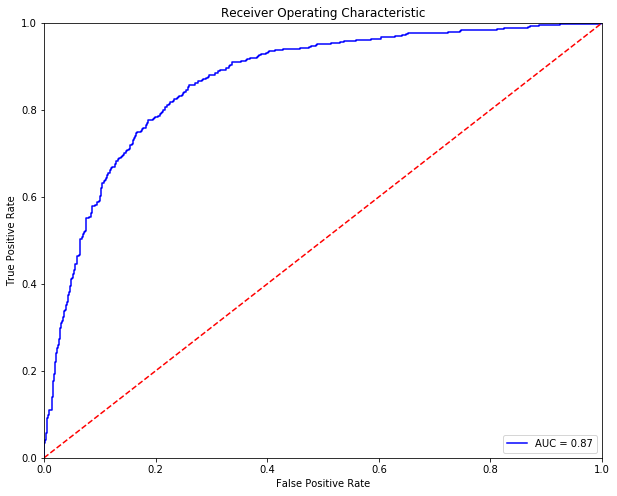

Optimal Threshold is 0.491667597534
Accuracy of Logistic Model on training data is: 0.791134989926


Predicted  0.0  1.0  __all__
Actual                      
0.0        584  154      738
1.0        157  594      751
__all__    741  748     1489

In [171]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [172]:
table_70_50_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [173]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0        entropy         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.802188309819

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1337   406     1743
1           281  1449     1730
__all__    1618  1855     3473

Accuracy of the  Random Forest Trees  model for test data is: 0.806581598388

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          574  164      738
1          124  627      751
__all__    698  791     1489

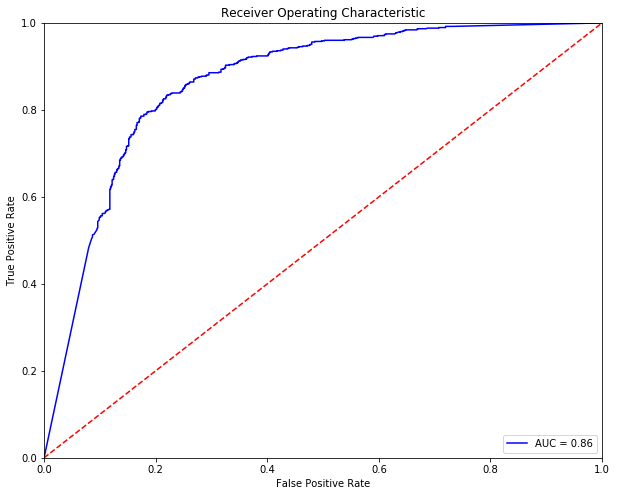

Optimal Threshold is 0.604238509255
Accuracy of Logistic Model on training data is: 0.799865681666


Predicted  0.0  1.0  __all__
Actual                      
0.0        591  147      738
1.0        151  600      751
__all__    742  747     1489

In [174]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [175]:
table_70_50_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

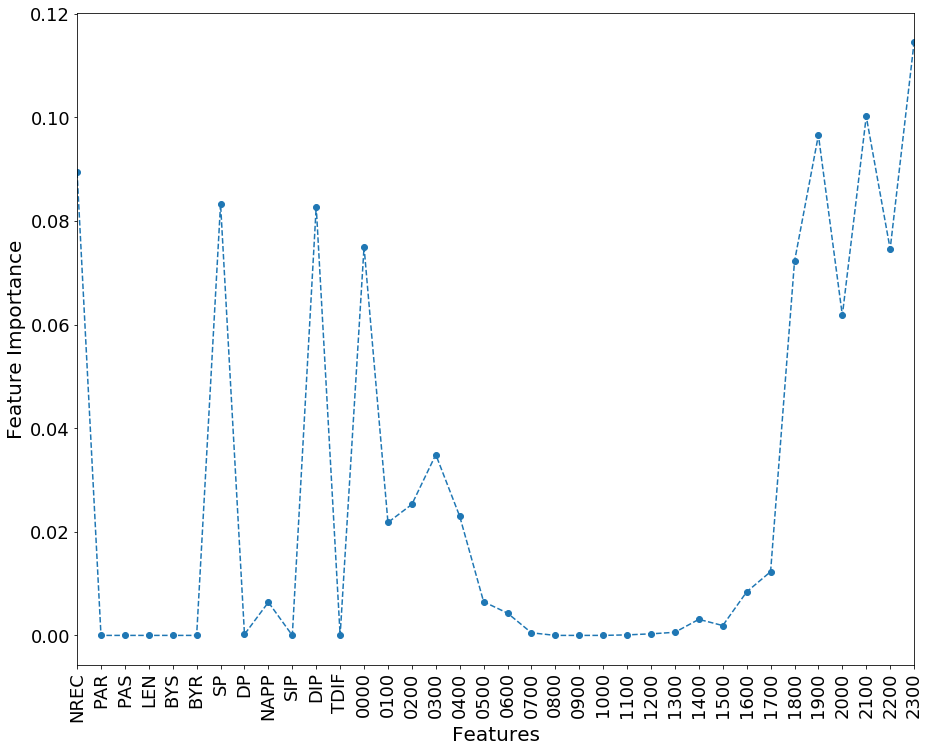

In [176]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [177]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME              1           150             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.802476245321

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1315   428     1743
1           258  1472     1730
__all__    1573  1900     3473

Accuracy of the  AdaBoostClassifier  model for test data is: 0.793149764943

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          559  179      738
1          129  622      751
__all__    688  801     1489

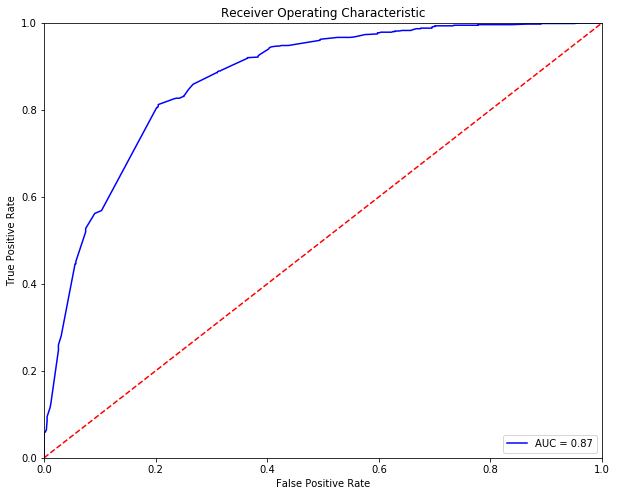

Optimal Threshold is 0.517695024614
Accuracy of Logistic Model on training data is: 0.731363331095


Predicted  0.0  1.0  __all__
Actual                      
0.0        662   76      738
1.0        324  427      751
__all__    986  503     1489

In [178]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [179]:
table_70_50_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

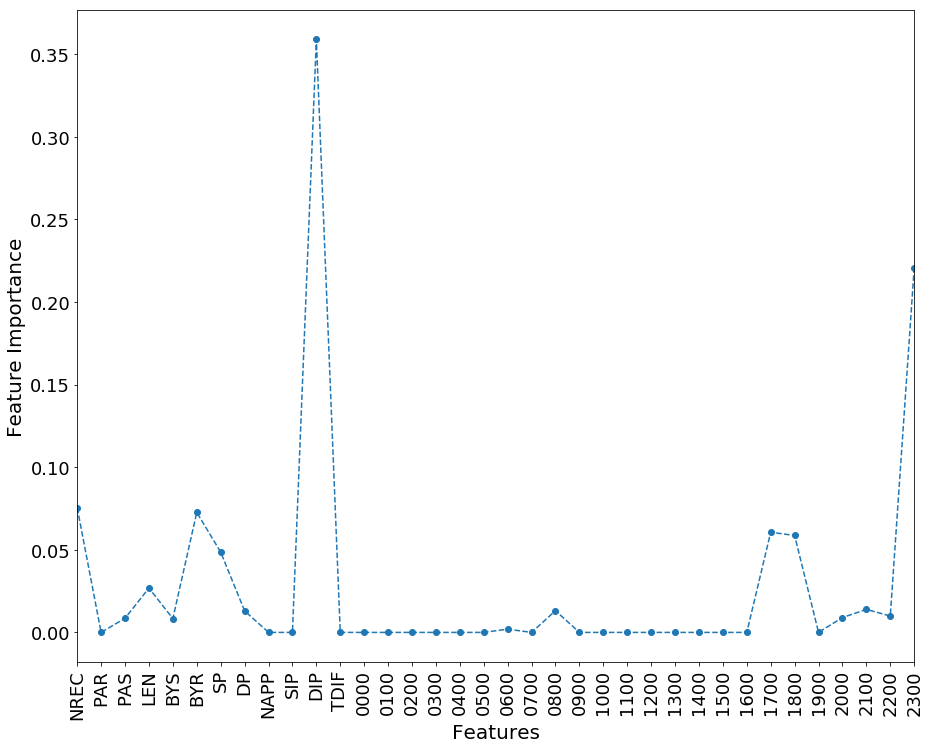

In [180]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [181]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.05  deviance                 5   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2            50             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.815145407429

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1347   396     1743
1           246  1484     1730
__all__    1593  1880     3473

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.805238415044

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          571  167      738
1          123  628      751
__all__    694  795     1489

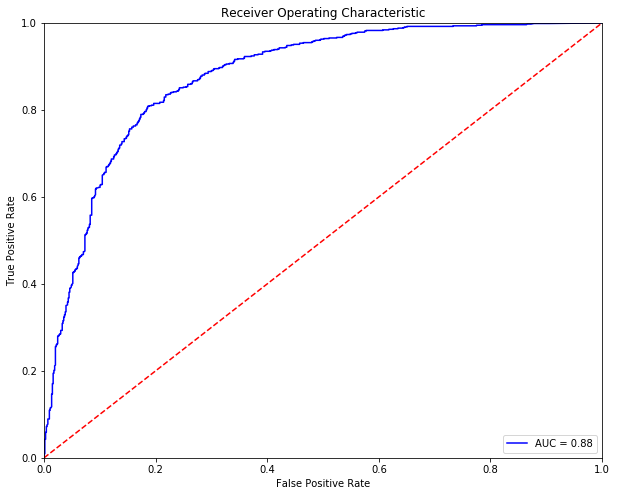

Optimal Threshold is 0.574582791363
Accuracy of Logistic Model on training data is: 0.809267965077


Predicted  0.0  1.0  __all__
Actual                      
0.0        597  141      738
1.0        143  608      751
__all__    740  749     1489

In [182]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [183]:
table_70_50_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

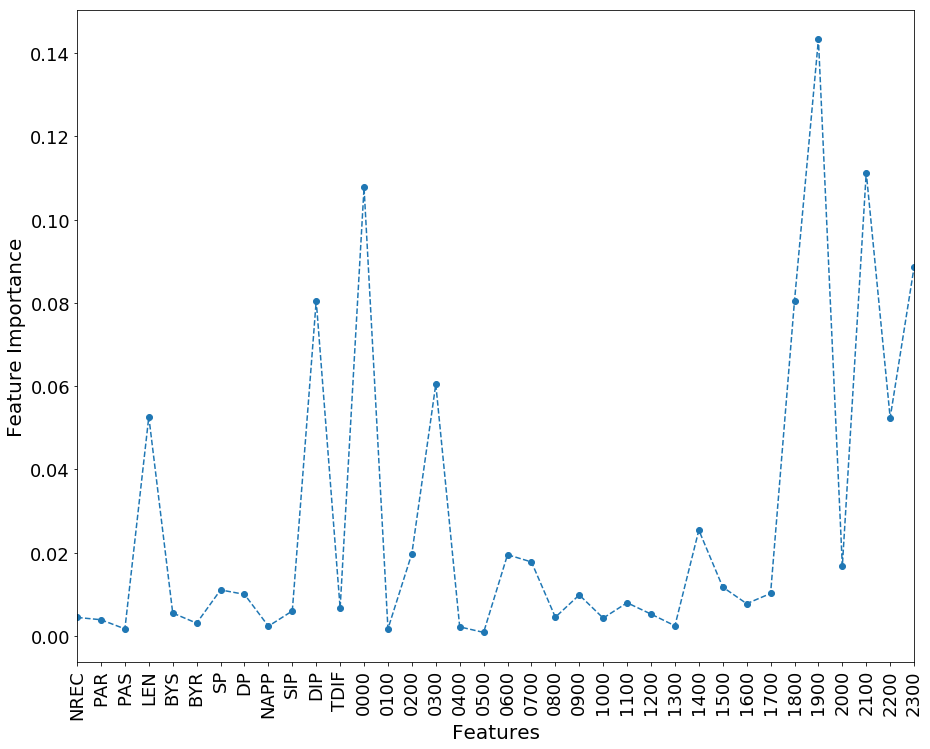

In [184]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [185]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         10          auto                    0.1   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.792110567233

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1255   488     1743
1           234  1496     1730
__all__    1489  1984     3473

Accuracy of the  Extra Decision Tree  model for test data is: 0.795836131632

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          530  208      738
1           96  655      751
__all__    626  863     1489

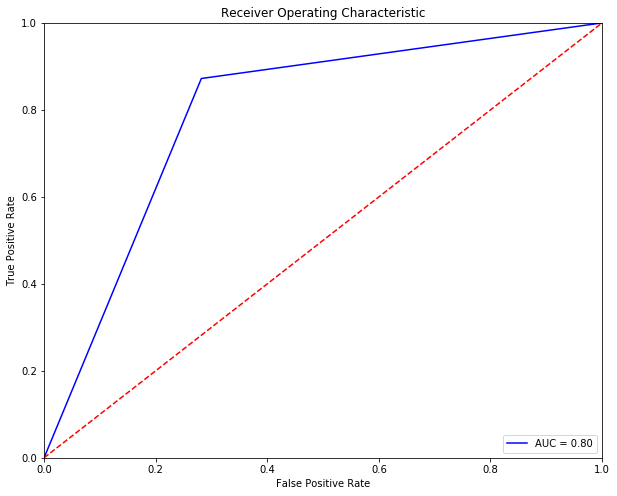

Optimal Threshold is 0.754032258065
Accuracy of Logistic Model on training data is: 0.49563465413


Predicted   0.0  1.0  __all__
Actual                       
0.0         738    0      738
1.0         751    0      751
__all__    1489    0     1489

In [186]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [187]:
table_70_50_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [188]:
%%capture
table_70_50_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

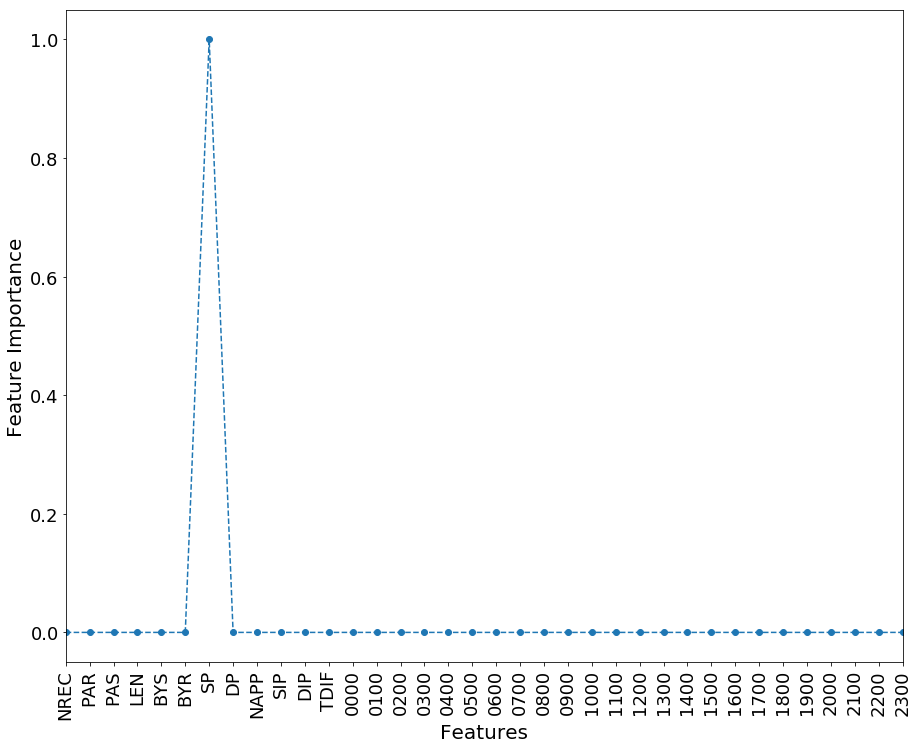

In [189]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [190]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.3          1500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.885401670026

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1479   264     1743
1           134  1596     1730
__all__    1613  1860     3473

Accuracy of the  Bagging  model for test data is: 0.80725319006

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          574  164      738
1          123  628      751
__all__    697  792     1489

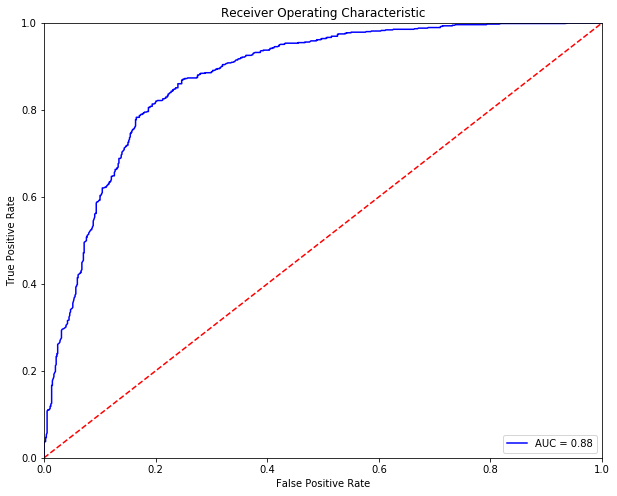

Optimal Threshold is 0.539333333333
Accuracy of Logistic Model on training data is: 0.808596373405


Predicted  0.0  1.0  __all__
Actual                      
0.0        598  140      738
1.0        145  606      751
__all__    743  746     1489

In [191]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [192]:
table_70_50_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [193]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.901526058163


Predicted     0     1  __all__
Actual                        
0          1520   223     1743
1           119  1611     1730
__all__    1639  1834     3473

The test accuracy is: 0.811954331766


Predicted    0    1  __all__
Actual                      
0          588  150      738
1          130  621      751
__all__    718  771     1489

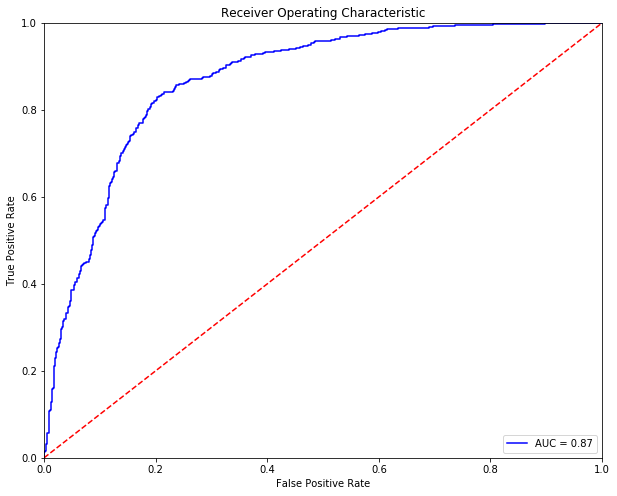

Optimal Threshold is 0.522851220285
Accuracy of Logistic Model on training data is: 0.808596373405


Predicted  0.0  1.0  __all__
Actual                      
0.0        597  141      738
1.0        144  607      751
__all__    741  748     1489

In [194]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [195]:
table_70_50_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [196]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.91534696228


Predicted     0     1  __all__
Actual                        
0          1639   104     1743
1           190  1540     1730
__all__    1829  1644     3473

The accuracy of the model on test data is: 0.746138347884


Predicted    0    1  __all__
Actual                      
0          578  160      738
1          218  533      751
__all__    796  693     1489

1152/1489 [======================>.......] - ETA: 0s

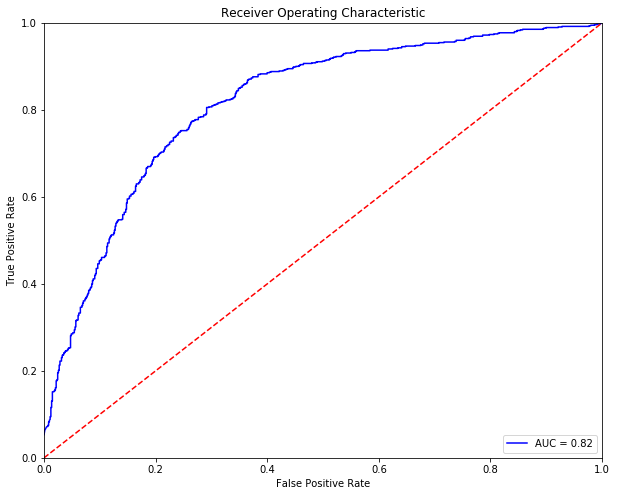

Optimal Threshold is 0.433046
Accuracy of Logistic Model on training data is: 0.752854264607


Predicted  0.0  1.0  __all__
Actual                      
0.0        557  181      738
1.0        187  564      751
__all__    744  745     1489

In [197]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [198]:
table_70_50_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [199]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.6min finished


The accuracy of the model on training data is: 0.812841923409


Predicted     0     1  __all__
Actual                        
0          1403   340     1743
1           310  1420     1730
__all__    1713  1760     3473

The accuracy of the model on test data is: 0.799194089993


Predicted    0    1  __all__
Actual                      
0          594  144      738
1          155  596      751
__all__    749  740     1489

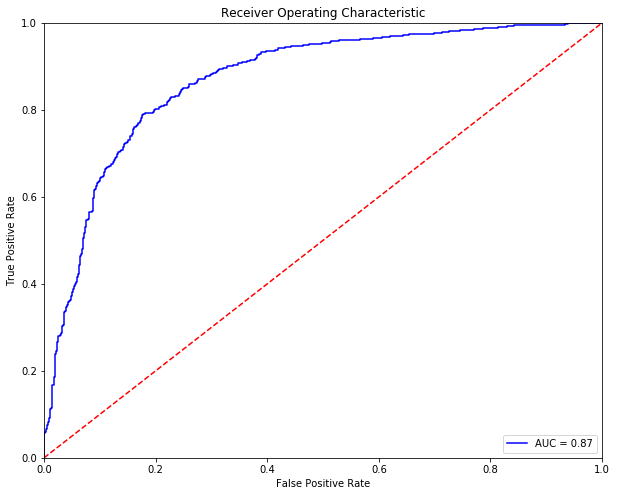

Optimal Threshold is 0.479126
Accuracy of Logistic Model on training data is: 0.80120886501


Predicted  0.0  1.0  __all__
Actual                      
0.0        592  146      738
1.0        150  601      751
__all__    742  747     1489

In [200]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [201]:
table_70_50_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [202]:
table_70_50_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_50_10_test.set_index(['index'],drop=True,inplace=True)
table_70_50_10_train.set_index(['index'],drop=True,inplace=True)
table_70_50_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_50_10_train)

print("Comparision Table for Test Accuracies:")
display(table_70_50_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_50_10_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1730.0  1743.0    0.0    0.0  0.000000   
LogisticRegression          0.799021  1388.0  1387.0  356.0  342.0  0.204246   
RandomForestClassifier      0.802188  1449.0  1337.0  406.0  281.0  0.232932   
AdaBoostClassifier          0.802476  1472.0  1315.0  428.0  258.0  0.245554   
GradientBoostingClassifier  0.815145  1484.0  1347.0  396.0  246.0  0.227194   
ExtraTreeClassifier         0.792111  1496.0  1255.0  488.0  234.0  0.279977   
BaggingClassifier           0.885402  1596.0  1479.0  264.0  134.0  0.151463   
VotingClassifier            0.901526  1611.0  1520.0  223.0  119.0  0.127940   
Neural Network-1            0.915347  1540.0  1639.0  104.0  190.0  0.059667   
Neural-Network-2            0.812842  1420.0  1403.0  340.0  310.0  0.195066   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.197688  
RandomForestClassifier      0.162428  
AdaBoostClassifier          0.149133  
GradientBoostingClassifier  0.142197  
ExtraTreeClassifier         0.135260  
BaggingClassifier           0.077457  
VotingClassifier            0.068786  
Neural Network-1            0.109827  
Neural-Network-2            0.179191

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.809940  610.0  596.0  142.0  141.0  0.192412   
LogisticRegression          0.791807  586.0  593.0  145.0  165.0  0.196477   
RandomForestClassifier      0.806582  627.0  574.0  164.0  124.0  0.222222   
AdaBoostClassifier          0.793150  622.0  559.0  179.0  129.0  0.242547   
GradientBoostingClassifier  0.805238  628.0  571.0  167.0  123.0  0.226287   
ExtraTreeClassifier         0.795836  655.0  530.0  208.0   96.0  0.281843   
BaggingClassifier           0.807253  628.0  574.0  164.0  123.0  0.222222   
VotingClassifier            0.811954  621.0  588.0  150.0  130.0  0.203252   
Neural Network-1            0.746138  533.0  578.0  160.0  218.0  0.216802   
Neural-Network-2            0.799194  596.0  594.0  144.0  155.0  0.195122   

                                 FNR  
index                                 
KNeighborsClassifier        0.187750  
LogisticRegression          0.219707  
RandomForestClassifier      0.165113  
AdaBoostClassifier          0.171771  
GradientBoostingClassifier  0.163782  
ExtraTreeClassifier         0.127830  
BaggingClassifier           0.163782  
VotingClassifier            0.173103  
Neural Network-1            0.290280  
Neural-Network-2            0.206391

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy          TP          TN          FP  \
index                                                                      
KNeighborsClassifier        0.809940  608.000000  598.000000  140.000000   
LogisticRegression          0.791135  594.000000  584.000000  154.000000   
RandomForestClassifier      0.799866  600.000000  591.000000  147.000000   
AdaBoostClassifier          0.731363  427.000000  662.000000   76.000000   
GradientBoostingClassifier  0.809268  608.000000  597.000000  141.000000   
ExtraTreeClassifier         0.495635  365.778375  372.221625  372.221625   
BaggingClassifier           0.808596  606.000000  598.000000  140.000000   
VotingClassifier            0.808596  607.000000  597.000000  141.000000   
Neural Network-1            0.752854  564.000000  557.000000  181.000000   
Neural-Network-2            0.801209  601.000000  592.000000  146.000000   

                                    FN       FPR       FNR  threshold  \
index                                                                   
KNeighborsClassifier        143.000000  0.189702  0.190413   0.505143   
LogisticRegression          157.000000  0.208672  0.209055   0.491668   
RandomForestClassifier      151.000000  0.199187  0.201065   0.604239   
AdaBoostClassifier          324.000000  0.102981  0.431425   0.517695   
GradientBoostingClassifier  143.000000  0.191057  0.190413   0.574583   
ExtraTreeClassifier         378.778375  0.495635  0.504365   0.754032   
BaggingClassifier           145.000000  0.189702  0.193076   0.539333   
VotingClassifier            144.000000  0.191057  0.191744   0.522851   
Neural Network-1            187.000000  0.245257  0.249001   0.433046   
Neural-Network-2            150.000000  0.197832  0.199734   0.479126   

                                 auc  
index                                 
KNeighborsClassifier        0.874152  
LogisticRegression          0.867321  
RandomForestClassifier      0.863418  
AdaBoostClassifier          0.869725  
GradientBoostingClassifier  0.878150  
ExtraTreeClassifier         0.795164  
BaggingClassifier           0.875364  
VotingClassifier            0.870465  
Neural Network-1            0.815932  
Neural-Network-2            0.870637

#### Random State 20

In [203]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  3728  132.185891   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...    81   31.061728   

                                                           PAS         LEN  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  103.969421  135.190987   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...   25.246914  109.395062   

                                                            BYS  \
Source_User                                                       
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  8652.968348   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...  3871.506173   

                                                              BYR      SP  \
Source_User                                                                 
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  178992.604882  3096.0   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...   17973.666667    80.0   

                                                       DP  NAPP  SIP  DIP  \
Source_User                                                                 
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  264.0    44  114  784   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...    3.0    10   12   28   

                                                            TDIF  0000  0100  \
Source_User                                                                    
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   2041.380633    72    81   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...  88488.987654     1     0   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   115   106   131   116   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0     0   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   100   355   279   152   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0     0   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   196   153   135   443   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0    10   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   243   195   185   132   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     1    25    32   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   152   107    90   107   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     2     8     0     0   

                                                    2200  2300  
Source_User                                                     
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...    38    45  
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     2     0

In [204]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
1da09acf8ddc082a297329856e8512e0aa25eef1650894f3e39d24006b3b9900    1
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8ddc3d1beabef89096b    0
c7ae13801caa67d372db28e31fe24146a34866c75fdaa7a8f3dd2e52c8feadbf    0
d7a31b1f8a1b6229ffc4f3d615d4847d8844645ed5bc9d4f016352ccde33eeef    0
2e8858be6011eed9b63eb701eda4575a43151dcedbd12b1e87e9707f1355e52d    1
aef14742e536c93ce48a00a70bc5c429ff5973e95f029488785eeda1778ea086    1
0930d98b6033a246eaecdf425d4fe74341a505bb2ffb83a09d4e489b29dea307    1
3f716f2fcc54a3eac07cc68af79773e6e32cc680c5f1b1e44ad527af39210d58    1
655f71c7531f608b3aa19880786cc023e26286b3bef2ad9917e379ddcead4e43    1
5957761ffa31d8e6cf65bb4540565c1ebd6e030e40b744a5c21d4d4b7c0d7d63    1
Name: Target, dtype: int64

In [205]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [206]:
## Table to store training and test measures
table_70_50_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [207]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1698     0     1698
1             0  1775     1775
__all__    1698  1775     3473

Accuracy of the  KNN  model for test data is: 0.777031564809

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          594  189      783
1          143  563      706
__all__    737  752     1489

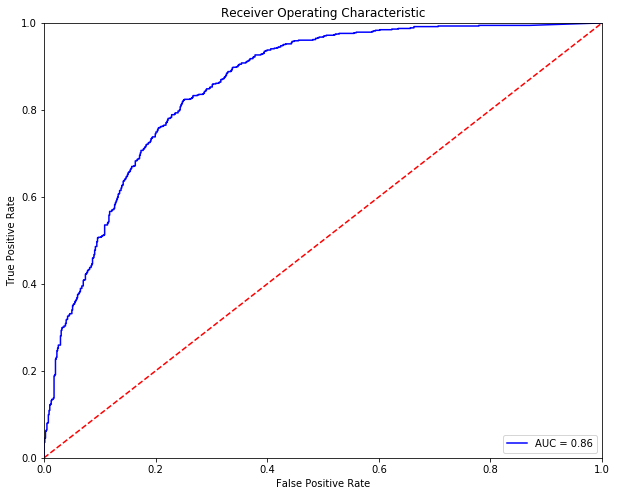

Optimal Threshold is 0.55117236752
Accuracy of Logistic Model on training data is: 0.777703156481


Predicted  0.0  1.0  __all__
Actual                      
0.0        610  173      783
1.0        158  548      706
__all__    768  721     1489

In [208]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [209]:
table_70_50_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [210]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.3  False           True                0.7       100  multinomial   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.791246760726

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1363   335     1698
1           390  1385     1775
__all__    1753  1720     3473

Accuracy of the  Logistic  model for test data is: 0.768300873069

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          598  185      783
1          160  546      706
__all__    758  731     1489

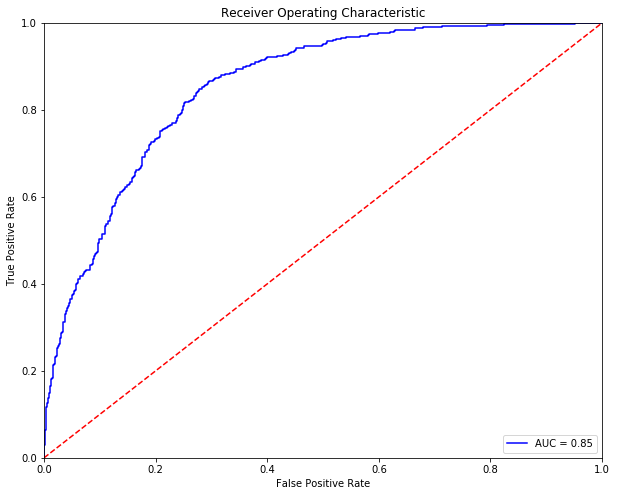

Optimal Threshold is 0.504548954579
Accuracy of Logistic Model on training data is: 0.768972464741


Predicted  0.0  1.0  __all__
Actual                      
0.0        603  180      783
1.0        164  542      706
__all__    767  722     1489

In [211]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [212]:
table_70_50_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [213]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0        entropy         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.803915922833

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1330   368     1698
1           313  1462     1775
__all__    1643  1830     3473

Accuracy of the  Random Forest Trees  model for test data is: 0.782404298187

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          592  191      783
1          133  573      706
__all__    725  764     1489

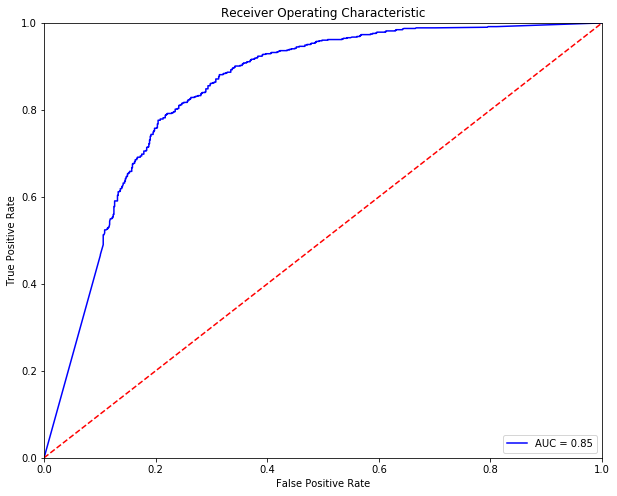

Optimal Threshold is 0.645532730089
Accuracy of Logistic Model on training data is: 0.783075889859


Predicted  0.0  1.0  __all__
Actual                      
0.0        614  169      783
1.0        154  552      706
__all__    768  721     1489

In [214]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [215]:
table_70_50_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

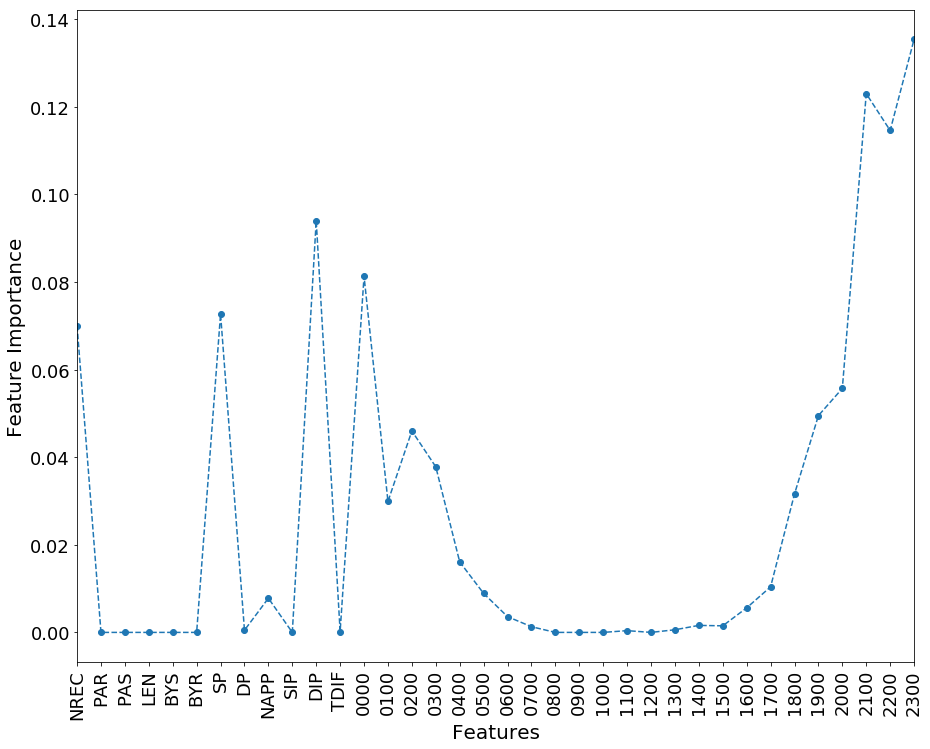

In [216]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [217]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0        SAMME.R            0.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.808810826375

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1294   404     1698
1           260  1515     1775
__all__    1554  1919     3473

Accuracy of the  AdaBoostClassifier  model for test data is: 0.779717931498

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          576  207      783
1          121  585      706
__all__    697  792     1489

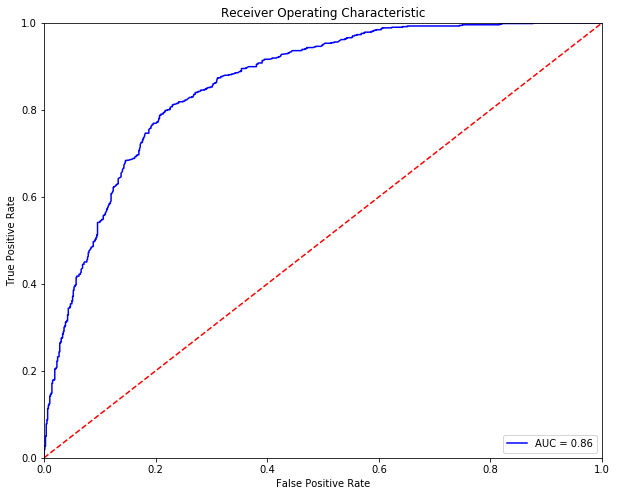

Optimal Threshold is 0.504757520471
Accuracy of Logistic Model on training data is: 0.789120214909


Predicted  0.0  1.0  __all__
Actual                      
0.0        619  164      783
1.0        150  556      706
__all__    769  720     1489

In [218]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [219]:
table_70_50_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

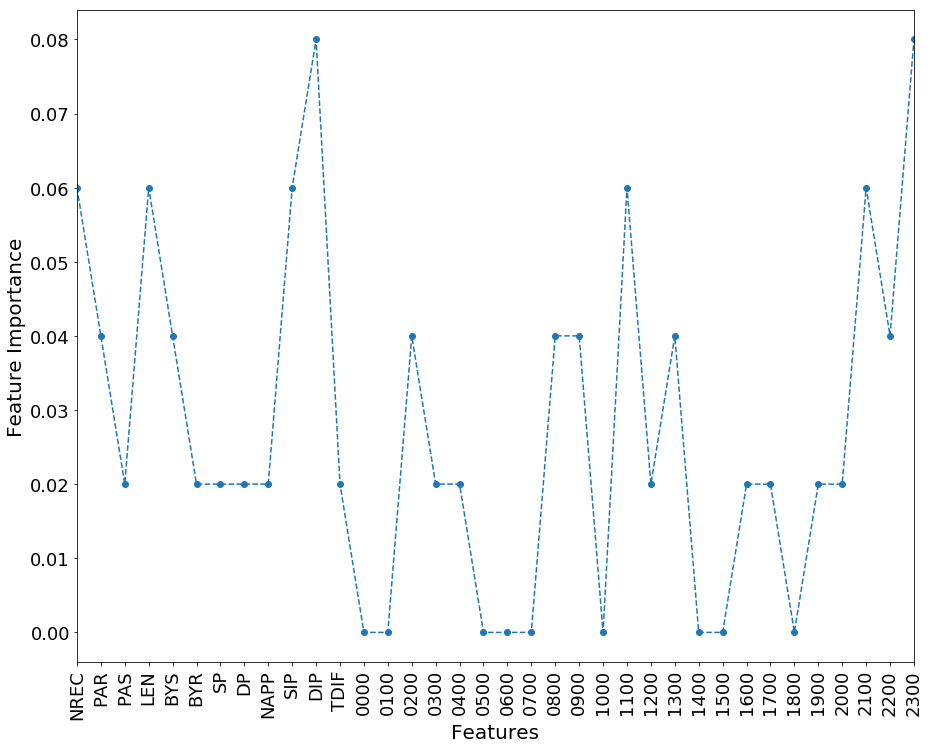

In [220]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [221]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse            0.1  exponential                15   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1            50             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.82004031097

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1326   372     1698
1           253  1522     1775
__all__    1579  1894     3473

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.785090664876

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          586  197      783
1          123  583      706
__all__    709  780     1489

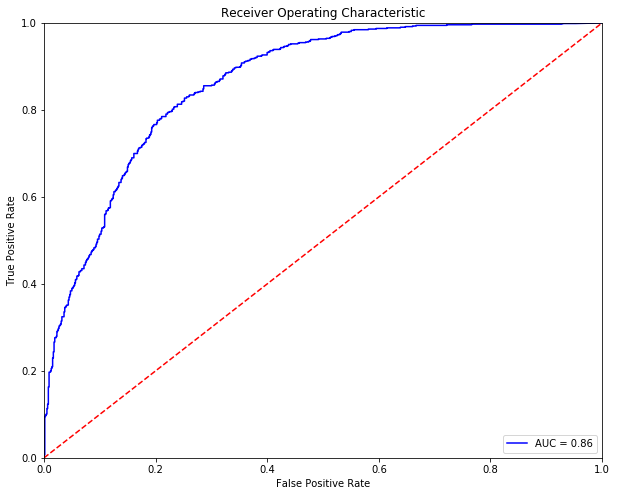

Optimal Threshold is 0.593405057009
Accuracy of Logistic Model on training data is: 0.783747481531


Predicted  0.0  1.0  __all__
Actual                      
0.0        613  170      783
1.0        152  554      706
__all__    765  724     1489

In [222]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [223]:
table_70_50_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

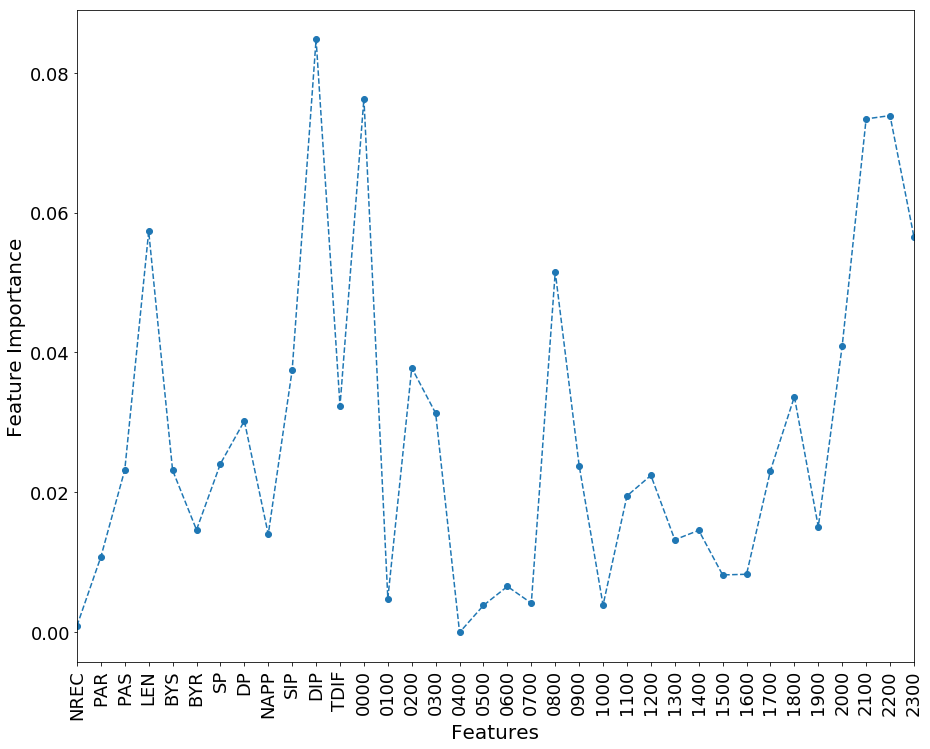

In [224]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [225]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0    random

Accuracy of the  Extra Decision Tree  model for the training data is: 0.793838180248

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1358   340     1698
1           376  1399     1775
__all__    1734  1739     3473

Accuracy of the  Extra Decision Tree  model for test data is: 0.767629281397

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          602  181      783
1          165  541      706
__all__    767  722     1489

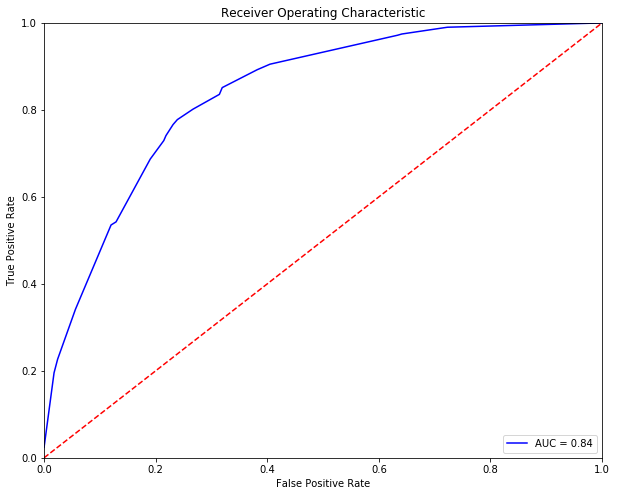

Optimal Threshold is 0.615384615385
Accuracy of Logistic Model on training data is: 0.762256548019


Predicted  0.0  1.0  __all__
Actual                      
0.0        612  171      783
1.0        183  523      706
__all__    795  694     1489

In [226]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [227]:
table_70_50_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [228]:
%%capture
table_70_50_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

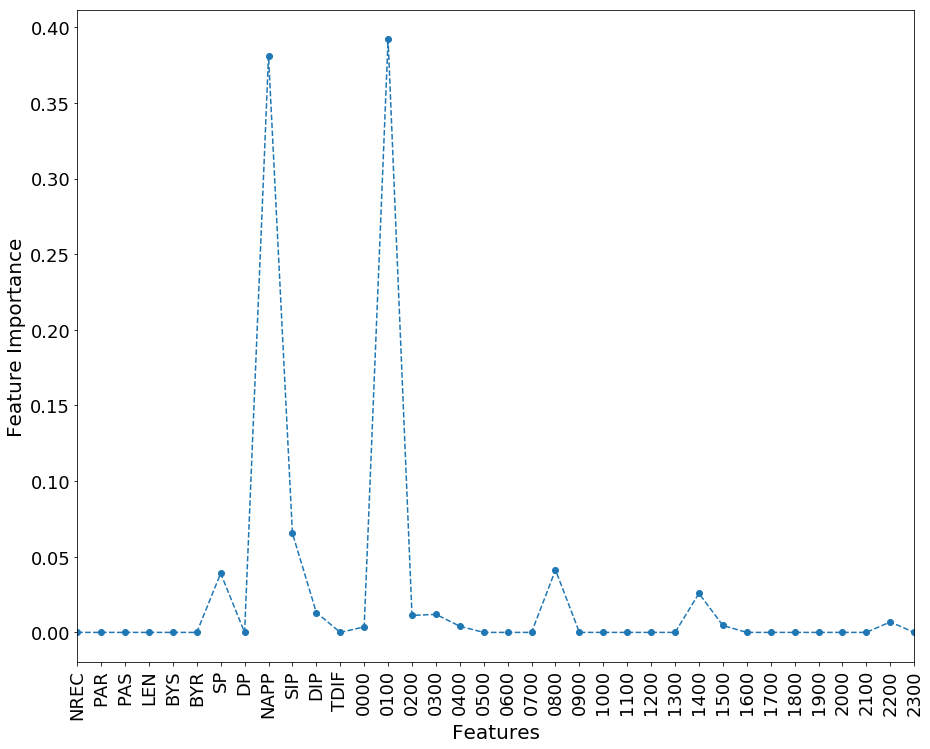

In [229]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [230]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.2          0.4           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.922833285344

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1521   177     1698
1            91  1684     1775
__all__    1612  1861     3473

Accuracy of the  Bagging  model for test data is: 0.781061114842

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          586  197      783
1          129  577      706
__all__    715  774     1489

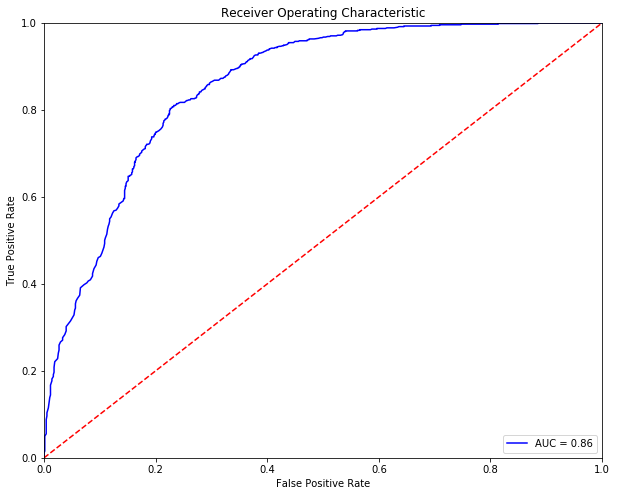

Optimal Threshold is 0.576
Accuracy of Logistic Model on training data is: 0.781061114842


Predicted  0.0  1.0  __all__
Actual                      
0.0        613  170      783
1.0        156  550      706
__all__    769  720     1489

In [231]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [232]:
table_70_50_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [233]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.908724445724


Predicted     0     1  __all__
Actual                        
0          1508   190     1698
1           127  1648     1775
__all__    1635  1838     3473

The test accuracy is: 0.777703156481


Predicted    0    1  __all__
Actual                      
0          580  203      783
1          128  578      706
__all__    708  781     1489

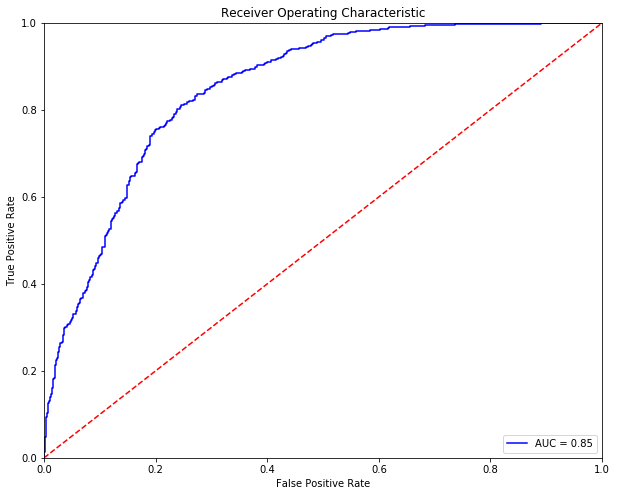

Optimal Threshold is 0.566235505218
Accuracy of Logistic Model on training data is: 0.775688381464


Predicted  0.0  1.0  __all__
Actual                      
0.0        608  175      783
1.0        159  547      706
__all__    767  722     1489

In [234]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [235]:
table_70_50_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [236]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.919378059332


Predicted     0     1  __all__
Actual                        
0          1620    78     1698
1           202  1573     1775
__all__    1822  1651     3473

The accuracy of the model on test data is: 0.761584956347


Predicted    0    1  __all__
Actual                      
0          609  174      783
1          181  525      706
__all__    790  699     1489

1056/1489 [====================>.........] - ETA: 0s

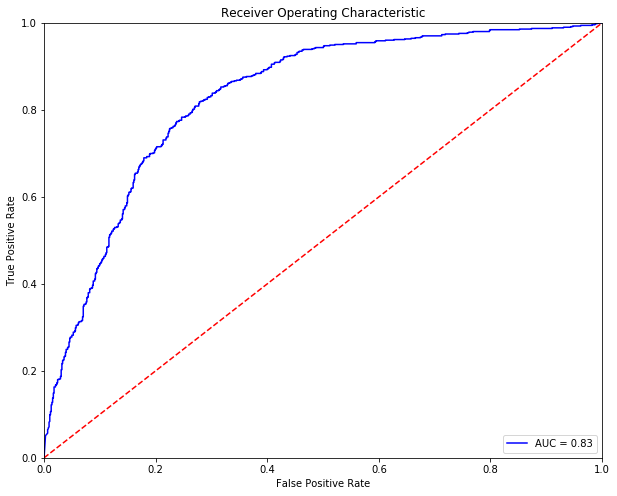

Optimal Threshold is 0.432829
Accuracy of Logistic Model on training data is: 0.764942914708


Predicted  0.0  1.0  __all__
Actual                      
0.0        599  184      783
1.0        166  540      706
__all__    765  724     1489

In [237]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [238]:
table_70_50_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [239]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.1min finished


The accuracy of the model on training data is: 0.80708321336


Predicted     0     1  __all__
Actual                        
0          1384   314     1698
1           356  1419     1775
__all__    1740  1733     3473

The accuracy of the model on test data is: 0.782404298187


Predicted    0    1  __all__
Actual                      
0          610  173      783
1          151  555      706
__all__    761  728     1489

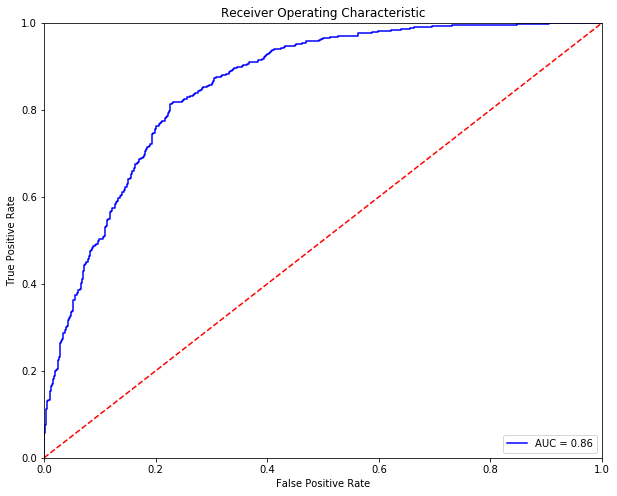

Optimal Threshold is 0.502737
Accuracy of Logistic Model on training data is: 0.782404298187


Predicted  0.0  1.0  __all__
Actual                      
0.0        613  170      783
1.0        154  552      706
__all__    767  722     1489

In [240]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [241]:
table_70_50_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [242]:
table_70_50_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_50_20_test.set_index(['index'],drop=True,inplace=True)
table_70_50_20_train.set_index(['index'],drop=True,inplace=True)
table_70_50_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_50_20_train)

print("Comparision Table for Test Accuracies:")
display(table_70_50_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_50_20_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1775.0  1698.0    0.0    0.0  0.000000   
LogisticRegression          0.791247  1385.0  1363.0  335.0  390.0  0.197291   
RandomForestClassifier      0.803916  1462.0  1330.0  368.0  313.0  0.216726   
AdaBoostClassifier          0.808811  1515.0  1294.0  404.0  260.0  0.237927   
GradientBoostingClassifier  0.820040  1522.0  1326.0  372.0  253.0  0.219081   
ExtraTreeClassifier         0.793838  1399.0  1358.0  340.0  376.0  0.200236   
BaggingClassifier           0.922833  1684.0  1521.0  177.0   91.0  0.104240   
VotingClassifier            0.908724  1648.0  1508.0  190.0  127.0  0.111896   
Neural Network-1            0.919378  1573.0  1620.0   78.0  202.0  0.045936   
Neural-Network-2            0.807083  1419.0  1384.0  314.0  356.0  0.184923   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.219718  
RandomForestClassifier      0.176338  
AdaBoostClassifier          0.146479  
GradientBoostingClassifier  0.142535  
ExtraTreeClassifier         0.211831  
BaggingClassifier           0.051268  
VotingClassifier            0.071549  
Neural Network-1            0.113803  
Neural-Network-2            0.200563

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.777032  563.0  594.0  189.0  143.0  0.241379   
LogisticRegression          0.768301  546.0  598.0  185.0  160.0  0.236271   
RandomForestClassifier      0.782404  573.0  592.0  191.0  133.0  0.243934   
AdaBoostClassifier          0.779718  585.0  576.0  207.0  121.0  0.264368   
GradientBoostingClassifier  0.785091  583.0  586.0  197.0  123.0  0.251596   
ExtraTreeClassifier         0.767629  541.0  602.0  181.0  165.0  0.231162   
BaggingClassifier           0.781061  577.0  586.0  197.0  129.0  0.251596   
VotingClassifier            0.777703  578.0  580.0  203.0  128.0  0.259259   
Neural Network-1            0.761585  525.0  609.0  174.0  181.0  0.222222   
Neural-Network-2            0.782404  555.0  610.0  173.0  151.0  0.220945   

                                 FNR  
index                                 
KNeighborsClassifier        0.202550  
LogisticRegression          0.226629  
RandomForestClassifier      0.188385  
AdaBoostClassifier          0.171388  
GradientBoostingClassifier  0.174221  
ExtraTreeClassifier         0.233711  
BaggingClassifier           0.182720  
VotingClassifier            0.181303  
Neural Network-1            0.256374  
Neural-Network-2            0.213881

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.777703  548.0  610.0  173.0  158.0  0.220945   
LogisticRegression          0.768972  542.0  603.0  180.0  164.0  0.229885   
RandomForestClassifier      0.783076  552.0  614.0  169.0  154.0  0.215837   
AdaBoostClassifier          0.789120  556.0  619.0  164.0  150.0  0.209451   
GradientBoostingClassifier  0.783747  554.0  613.0  170.0  152.0  0.217114   
ExtraTreeClassifier         0.762257  523.0  612.0  171.0  183.0  0.218391   
BaggingClassifier           0.781061  550.0  613.0  170.0  156.0  0.217114   
VotingClassifier            0.775688  547.0  608.0  175.0  159.0  0.223499   
Neural Network-1            0.764943  540.0  599.0  184.0  166.0  0.234994   
Neural-Network-2            0.782404  552.0  613.0  170.0  154.0  0.217114   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.223796   0.551172  0.856861  
LogisticRegression          0.232295   0.504549  0.853216  
RandomForestClassifier      0.218130   0.645533  0.845447  
AdaBoostClassifier          0.212465   0.504758  0.860042  
GradientBoostingClassifier  0.215297   0.593405  0.864341  
ExtraTreeClassifier         0.259207   0.615385  0.836851  
BaggingClassifier           0.220963   0.576000  0.856845  
VotingClassifier            0.225212   0.566236  0.850846  
Neural Network-1            0.235127   0.432829  0.829807  
Neural-Network-2            0.218130   0.502737  0.857154

###  <a id='1.C' style="text-decoration : none; color : #000000;">80:20 Train Test Split with PCA</a>
#### Random State 0

In [243]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     4    1.00000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  9326  236.40564   

                                                           PAS        LEN  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...    1.000000  31.000000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  130.825005  78.920437   

                                                             BYS  \
Source_User                                                        
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     77.500000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  16523.837122   

                                                              BYR      SP  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     225.750000     4.0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  308234.733219  7070.0   

                                                      DP  NAPP  SIP   DIP  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...   1.0     1    1     1   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  26.0    47   74  1610   

                                                          TDIF  0000  0100  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...    0.250000     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  796.853957   528   582   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   519   540   512   417   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   421   626   360   346   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   223   308   207   272   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   844   136   298   175   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     4     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   259   359   259   323   

                                                    2200  2300  
Source_User                                                     
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0  
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   397   415

1 -> Infected
0 -> Uninfected


Source_User
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1193b2d05e46c2e870    0
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c1f6ca9d117f8b3530    1
c2cf660ad094544b4bb8f01efb417804cfa5d53624783c2f784faac2b244c029    1
3fcd1179a650c2cfc6b6d23aa0193f8247ea56691044389f53a1e771431e2862    0
55394724a0a52464de210c953c5e6bee779e0f0a163aa4787087024004caeb82    1
327686c9e4533b14641208d230f5d01b93dcdd21d71360fbcac0d78d487c58ab    0
bc72f41bcdc4b3e5ee020baae91eb97b6c4ca7a1209ed7a69f4f0915de990aa2    0
d49890688b35443d361df19e2bfeaeddeda4d5572c03cf5678f9b36e01cf5415    1
01c615bd6e5026eb8f8ce76567d9f00c3eec2b1752da1854ece27439da4c0fe9    0
469c1c634cf9e6412e08bda889e471ef6af563097f737223a09ad50e7364cfa9    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.918903941373
The train/test split ratio is 80:20


In [244]:
display(X_pca_13[0:1])

array([[-0.88239461, -0.51557388,  0.22276869,  0.36425984,  0.1785245 ,
         0.62838131, -0.23203605,  0.5829496 , -1.30103283,  0.47369319,
         0.18877514,  0.00313269,  0.23901109]])

In [245]:
## Table to store training and test measures
table_80_50_PCA_0_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_PCA_0_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_PCA_0_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [246]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          2007     0     2007
1             0  1962     1962
__all__    2007  1962     3969

Accuracy of the  KNN  model for test data is: 0.775427995972

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          374  100      474
1          123  396      519
__all__    497  496      993

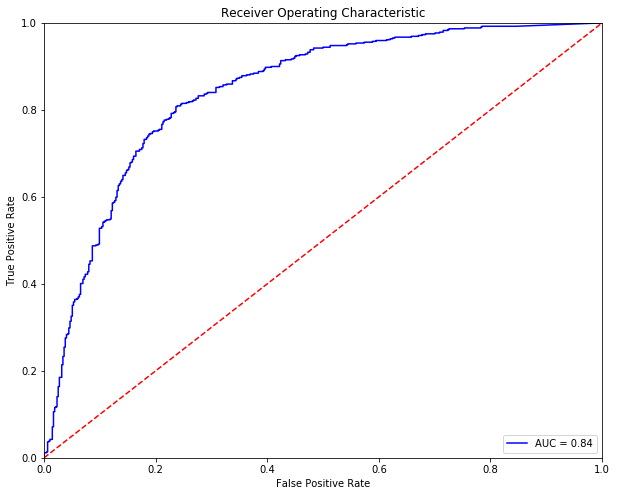

Optimal Threshold is 0.473576869968
Accuracy of Logistic Model on training data is: 0.778449144008


Predicted  0.0  1.0  __all__
Actual                      
0.0        369  105      474
1.0        115  404      519
__all__    484  509      993

In [247]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [248]:
table_80_50_PCA_0_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_0_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_0_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [249]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.3  False          False                0.5       100          ovr   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  0.001

Accuracy of the  Logistic  model for the training data is: 0.794154698917

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1603   404     2007
1           413  1549     1962
__all__    2016  1953     3969

Accuracy of the  Logistic  model for test data is: 0.781470292044

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          376   98      474
1          119  400      519
__all__    495  498      993

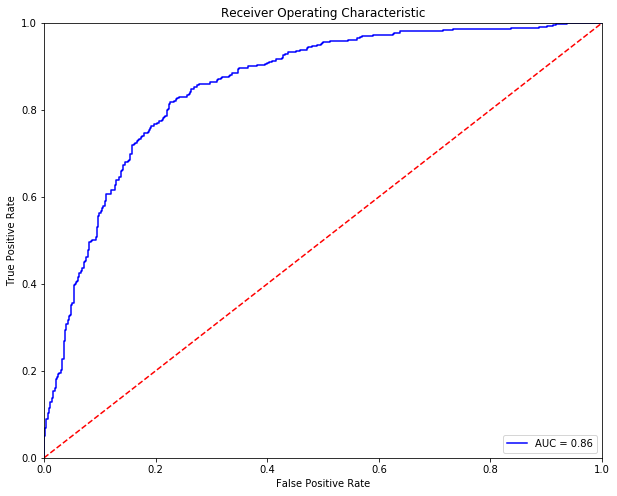

Optimal Threshold is 0.483472127174
Accuracy of Logistic Model on training data is: 0.783484390735


Predicted  0.0  1.0  __all__
Actual                      
0.0        372  102      474
1.0        113  406      519
__all__    485  508      993

In [250]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [251]:
table_80_50_PCA_0_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_0_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_0_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [252]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.795162509448

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1511   496     2007
1           317  1645     1962
__all__    1828  2141     3969

Accuracy of the  Random Forest Trees  model for test data is: 0.783484390735

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          347  127      474
1           88  431      519
__all__    435  558      993

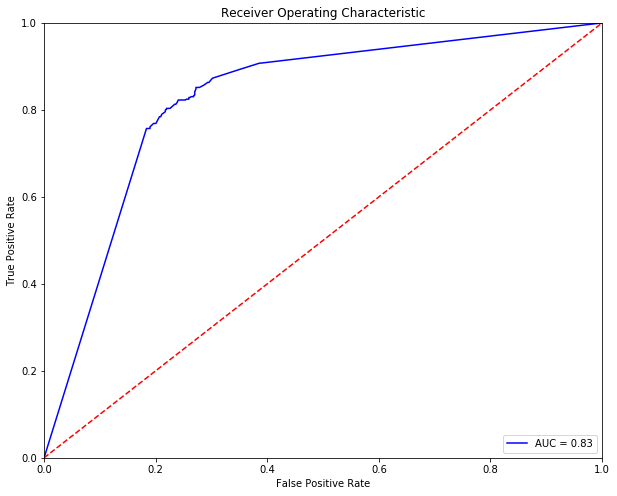

Optimal Threshold is 0.551416947407
Accuracy of Logistic Model on training data is: 0.787512588117


Predicted  0.0  1.0  __all__
Actual                      
0.0        375   99      474
1.0        112  407      519
__all__    487  506      993

In [253]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [254]:
table_80_50_PCA_0_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_0_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_0_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

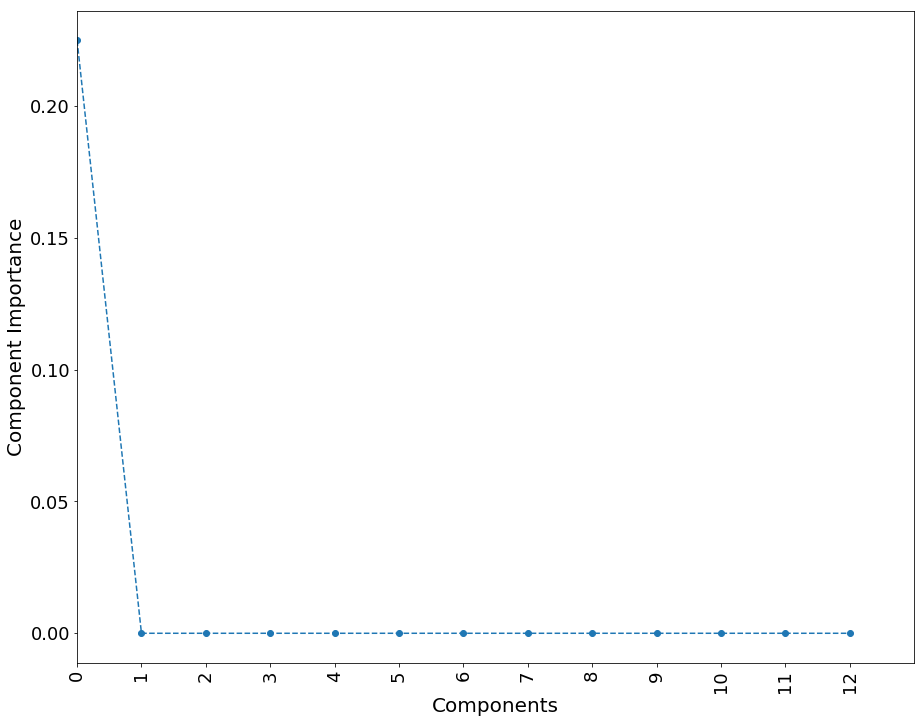

In [255]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [256]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0        SAMME.R            0.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.801209372638

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1525   482     2007
1           307  1655     1962
__all__    1832  2137     3969

Accuracy of the  AdaBoostClassifier  model for test data is: 0.788519637462

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          355  119      474
1           91  428      519
__all__    446  547      993

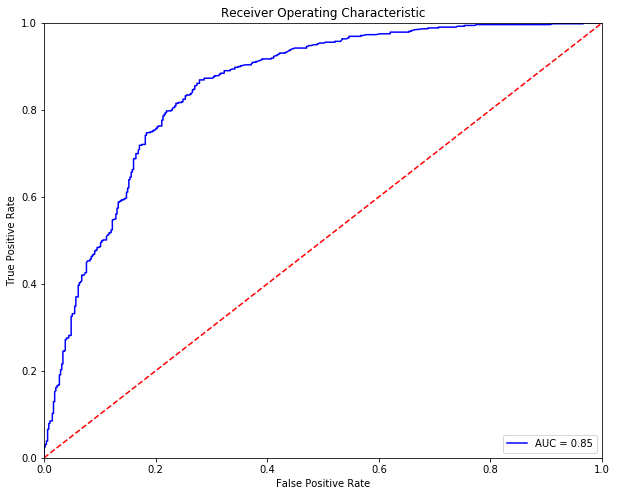

Optimal Threshold is 0.504439623559
Accuracy of Logistic Model on training data is: 0.784491440081


Predicted  0.0  1.0  __all__
Actual                      
0.0        373  101      474
1.0        113  406      519
__all__    486  507      993

In [257]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [258]:
table_80_50_PCA_0_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_0_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_0_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

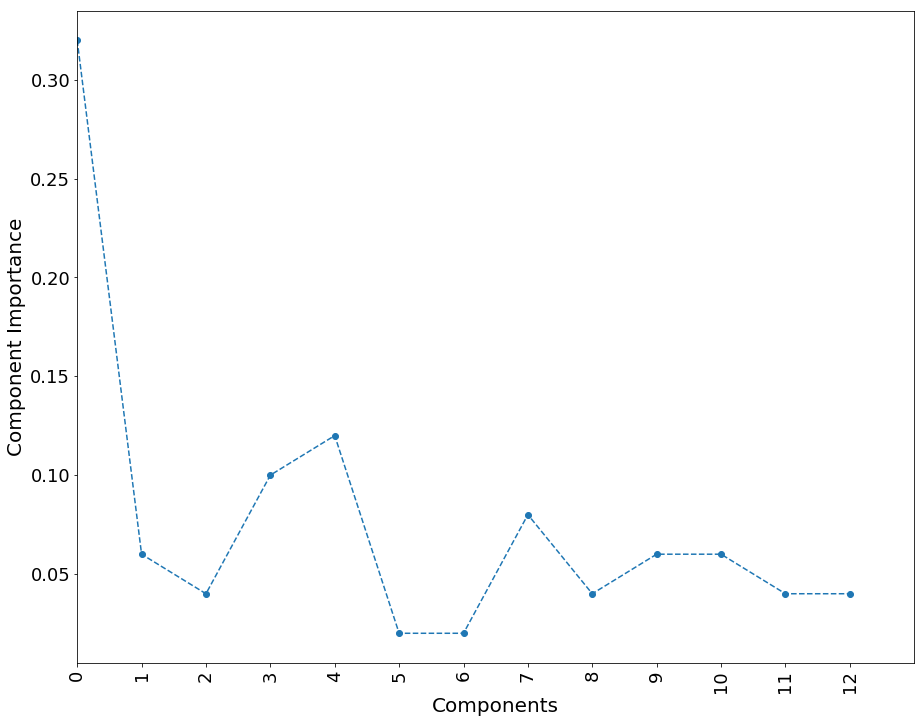

In [259]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [260]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.03  deviance                15   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2           150             0          1

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.81002771479

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1561   446     2007
1           308  1654     1962
__all__    1869  2100     3969

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.790533736153

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          364  110      474
1           98  421      519
__all__    462  531      993

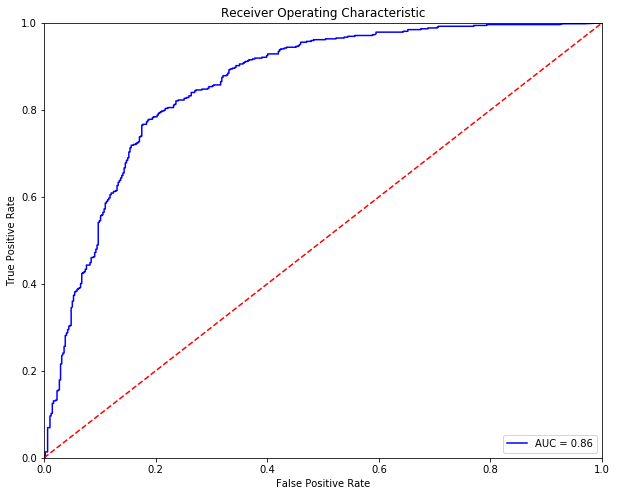

Optimal Threshold is 0.552784447542
Accuracy of Logistic Model on training data is: 0.792547834844


Predicted  0.0  1.0  __all__
Actual                      
0.0        376   98      474
1.0        108  411      519
__all__    484  509      993

In [261]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [262]:
table_80_50_PCA_0_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_0_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_0_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

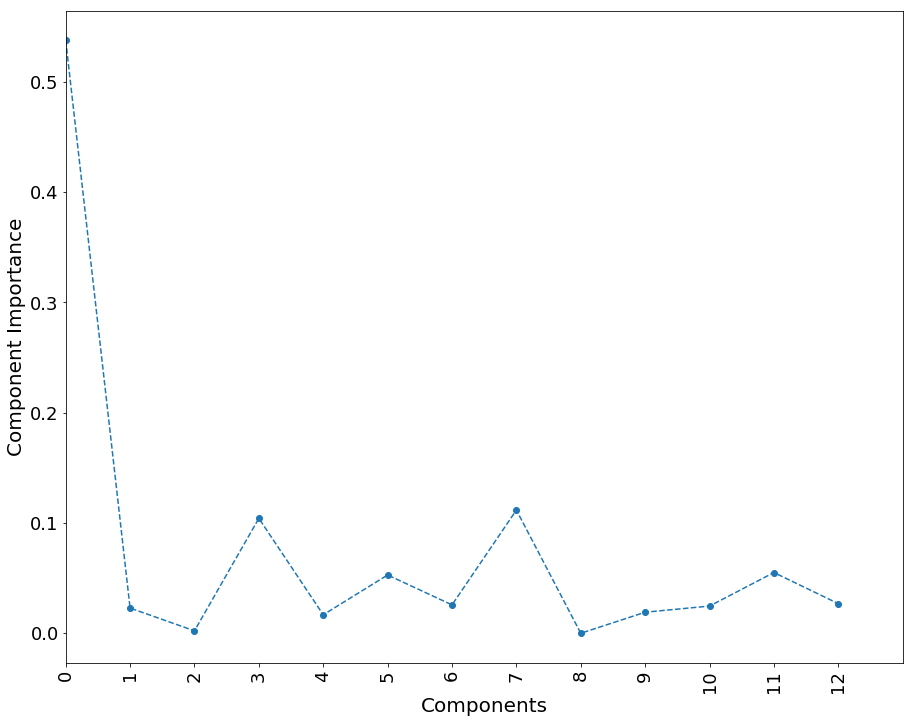

In [263]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [264]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         20          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     3                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.793398841018

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1592   415     2007
1           405  1557     1962
__all__    1997  1972     3969

Accuracy of the  Extra Decision Tree  model for test data is: 0.762336354481

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          363  111      474
1          125  394      519
__all__    488  505      993

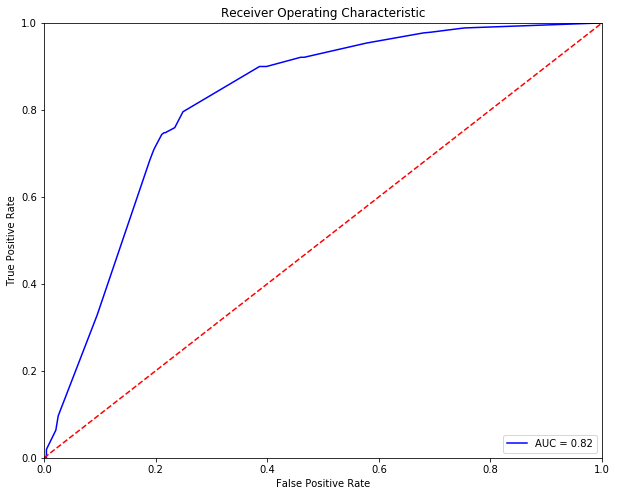

Optimal Threshold is 0.577777777778
Accuracy of Logistic Model on training data is: 0.764350453172


Predicted  0.0  1.0  __all__
Actual                      
0.0        371  103      474
1.0        131  388      519
__all__    502  491      993

In [265]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [266]:
table_80_50_PCA_0_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_0_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [267]:
%%capture
table_80_50_PCA_0_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

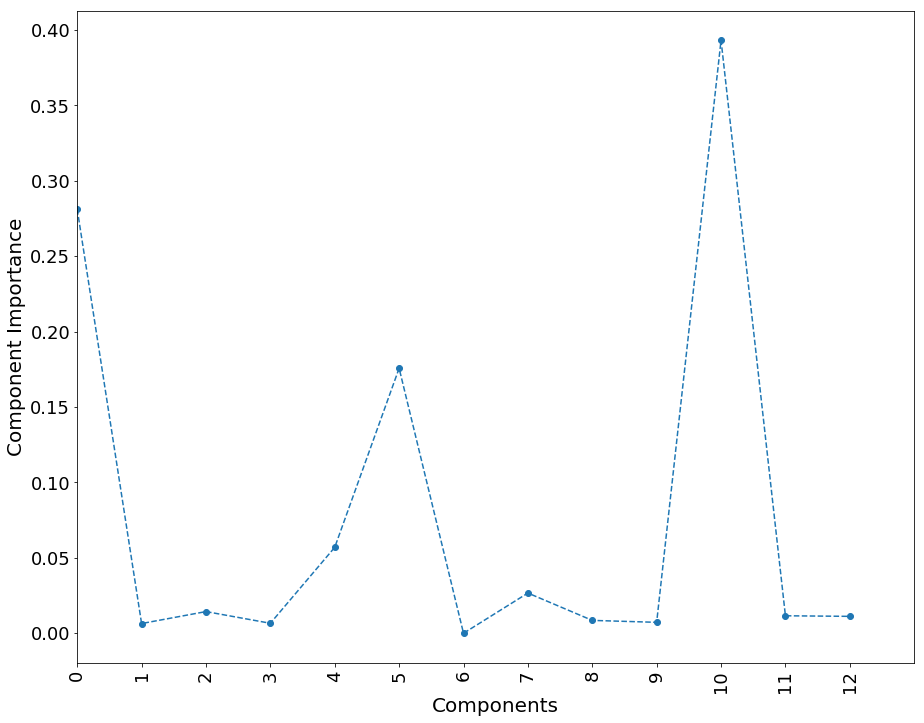

In [268]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [269]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.4           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.949357520786

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1883   124     2007
1            77  1885     1962
__all__    1960  2009     3969

Accuracy of the  Bagging  model for test data is: 0.787512588117

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          350  124      474
1           87  432      519
__all__    437  556      993

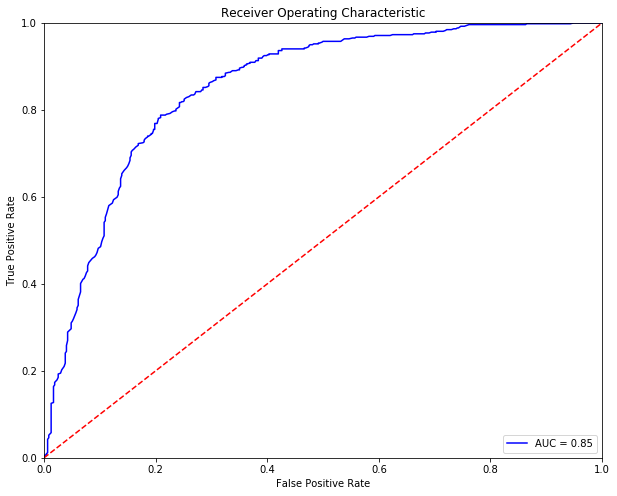

Optimal Threshold is 0.568
Accuracy of Logistic Model on training data is: 0.788519637462


Predicted  0.0  1.0  __all__
Actual                      
0.0        375   99      474
1.0        111  408      519
__all__    486  507      993

In [270]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [271]:
table_80_50_PCA_0_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_0_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_0_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [272]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.933484504913


Predicted     0     1  __all__
Actual                        
0          1847   160     2007
1           104  1858     1962
__all__    1951  2018     3969

The test accuracy is: 0.779456193353


Predicted    0    1  __all__
Actual                      
0          364  110      474
1          109  410      519
__all__    473  520      993

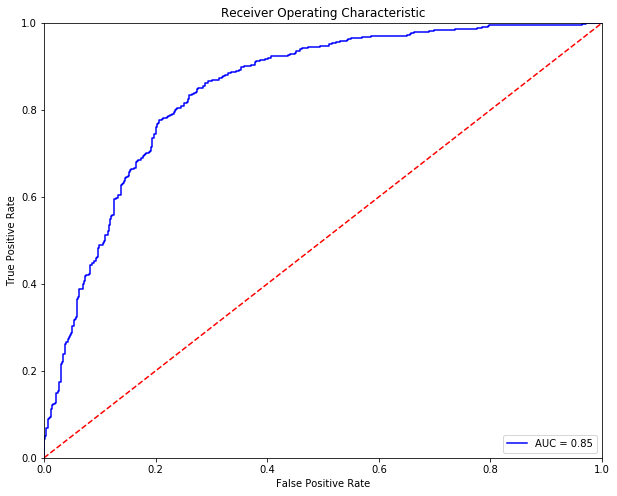

Optimal Threshold is 0.516819312063
Accuracy of Logistic Model on training data is: 0.781470292044


Predicted  0.0  1.0  __all__
Actual                      
0.0        371  103      474
1.0        114  405      519
__all__    485  508      993

In [273]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [274]:
table_80_50_PCA_0_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_0_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_0_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [275]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.846056941295


Predicted     0     1  __all__
Actual                        
0          1598   409     2007
1           202  1760     1962
__all__    1800  2169     3969

The accuracy of the model on test data is: 0.78247734139


Predicted    0    1  __all__
Actual                      
0          338  136      474
1           80  439      519
__all__    418  575      993

928/993 [===========================>..] - ETA: 0s

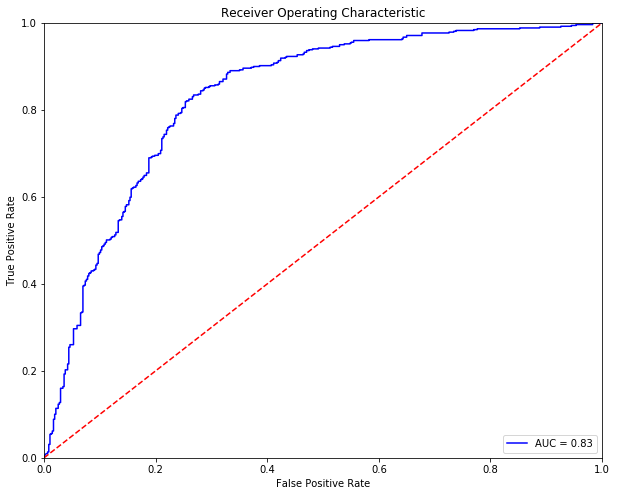

Optimal Threshold is 0.616522
Accuracy of Logistic Model on training data is: 0.767371601208


Predicted  0.0  1.0  __all__
Actual                      
0.0        364  110      474
1.0        121  398      519
__all__    485  508      993

In [276]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [277]:
table_80_50_PCA_0_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_0_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_0_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [278]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.9min finished


The accuracy of the model on training data is: 0.81002771479


Predicted     0     1  __all__
Actual                        
0          1542   465     2007
1           289  1673     1962
__all__    1831  2138     3969

The accuracy of the model on test data is: 0.792547834844


Predicted    0    1  __all__
Actual                      
0          360  114      474
1           92  427      519
__all__    452  541      993

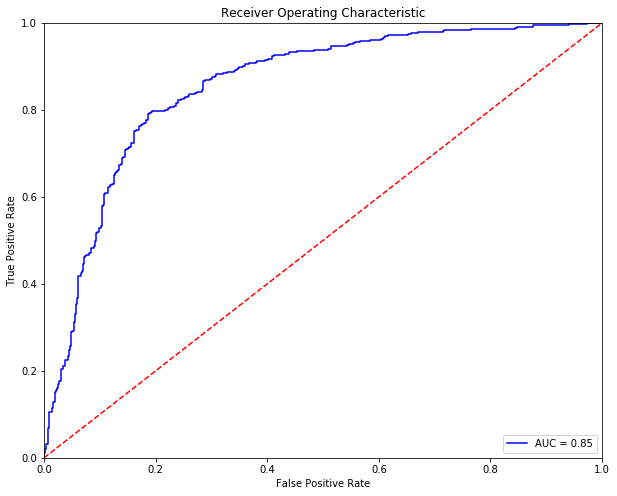

Optimal Threshold is 0.595996
Accuracy of Logistic Model on training data is: 0.800604229607


Predicted  0.0  1.0  __all__
Actual                      
0.0        382   92      474
1.0        106  413      519
__all__    488  505      993

In [279]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [280]:
table_80_50_PCA_0_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_0_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_0_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [281]:
table_80_50_PCA_0_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_PCA_0_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_PCA_0_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_PCA_0_test.set_index(['index'],drop=True,inplace=True)
table_80_50_PCA_0_train.set_index(['index'],drop=True,inplace=True)
table_80_50_PCA_0_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_PCA_0_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_PCA_0_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_PCA_0_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1962.0  2007.0    0.0    0.0  0.000000   
LogisticRegression          0.794155  1549.0  1603.0  404.0  413.0  0.201295   
RandomForestClassifier      0.795163  1645.0  1511.0  496.0  317.0  0.247135   
AdaBoostClassifier          0.801209  1655.0  1525.0  482.0  307.0  0.240159   
GradientBoostingClassifier  0.810028  1654.0  1561.0  446.0  308.0  0.222222   
ExtraTreeClassifier         0.793399  1557.0  1592.0  415.0  405.0  0.206776   
BaggingClassifier           0.949358  1885.0  1883.0  124.0   77.0  0.061784   
VotingClassifier            0.933485  1858.0  1847.0  160.0  104.0  0.079721   
Neural Network-1            0.846057  1760.0  1598.0  409.0  202.0  0.203787   
Neural-Network-2            0.810028  1673.0  1542.0  465.0  289.0  0.231689   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.210499  
RandomForestClassifier      0.161570  
AdaBoostClassifier          0.156473  
GradientBoostingClassifier  0.156983  
ExtraTreeClassifier         0.206422  
BaggingClassifier           0.039246  
VotingClassifier            0.053007  
Neural Network-1            0.102956  
Neural-Network-2            0.147299

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.775428  396.0  374.0  100.0  123.0  0.210970   
LogisticRegression          0.781470  400.0  376.0   98.0  119.0  0.206751   
RandomForestClassifier      0.783484  431.0  347.0  127.0   88.0  0.267932   
AdaBoostClassifier          0.788520  428.0  355.0  119.0   91.0  0.251055   
GradientBoostingClassifier  0.790534  421.0  364.0  110.0   98.0  0.232068   
ExtraTreeClassifier         0.762336  394.0  363.0  111.0  125.0  0.234177   
BaggingClassifier           0.787513  432.0  350.0  124.0   87.0  0.261603   
VotingClassifier            0.779456  410.0  364.0  110.0  109.0  0.232068   
Neural Network-1            0.782477  439.0  338.0  136.0   80.0  0.286920   
Neural-Network-2            0.792548  427.0  360.0  114.0   92.0  0.240506   

                                 FNR  
index                                 
KNeighborsClassifier        0.236994  
LogisticRegression          0.229287  
RandomForestClassifier      0.169557  
AdaBoostClassifier          0.175337  
GradientBoostingClassifier  0.188825  
ExtraTreeClassifier         0.240848  
BaggingClassifier           0.167630  
VotingClassifier            0.210019  
Neural Network-1            0.154143  
Neural-Network-2            0.177264

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.778449  404.0  369.0  105.0  115.0  0.221519   
LogisticRegression          0.783484  406.0  372.0  102.0  113.0  0.215190   
RandomForestClassifier      0.787513  407.0  375.0   99.0  112.0  0.208861   
AdaBoostClassifier          0.784491  406.0  373.0  101.0  113.0  0.213080   
GradientBoostingClassifier  0.792548  411.0  376.0   98.0  108.0  0.206751   
ExtraTreeClassifier         0.764350  388.0  371.0  103.0  131.0  0.217300   
BaggingClassifier           0.788520  408.0  375.0   99.0  111.0  0.208861   
VotingClassifier            0.781470  405.0  371.0  103.0  114.0  0.217300   
Neural Network-1            0.767372  398.0  364.0  110.0  121.0  0.232068   
Neural-Network-2            0.800604  413.0  382.0   92.0  106.0  0.194093   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.221580   0.473577  0.843370  
LogisticRegression          0.217726   0.483472  0.856516  
RandomForestClassifier      0.215800   0.551417  0.826478  
AdaBoostClassifier          0.217726   0.504440  0.852038  
GradientBoostingClassifier  0.208092   0.552784  0.858678  
ExtraTreeClassifier         0.252408   0.577778  0.817643  
BaggingClassifier           0.213873   0.568000  0.852624  
VotingClassifier            0.219653   0.516819  0.847024  
Neural Network-1            0.233141   0.616522  0.832356  
Neural-Network-2            0.204239   0.595996  0.854894

#### Random State 10

In [282]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...   558  87.706093   
384ed706777916e315308d41eb2efc086edc768b6392e14...     3  29.333333   

                                                          PAS         LEN  \
Source_User                                                                 
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  25.094982  106.747312   
384ed706777916e315308d41eb2efc086edc768b6392e14...  22.000000  363.000000   

                                                            BYS  \
Source_User                                                       
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  3436.492832   
384ed706777916e315308d41eb2efc086edc768b6392e14...  5405.333333   

                                                              BYR     SP  \
Source_User                                                                
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  103496.745520  539.0   
384ed706777916e315308d41eb2efc086edc768b6392e14...    3980.666667    3.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  20.0    42   47  230   
384ed706777916e315308d41eb2efc086edc768b6392e14...   1.0     2    1    2   

                                                           TDIF  0000  0100  \
Source_User                                                                   
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  7309.743728     5     4   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0.000000     0     0   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     0     0     0     0   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     4    31    14     3   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     3   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     3     4    16    18   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...    20    74    81    71   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...   116    42    32    10   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    2200  2300  
Source_User                                                     
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     4     6  
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0

1 -> Infected
0 -> Uninfected


Source_User
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7ec769d861466ae859    0
384ed706777916e315308d41eb2efc086edc768b6392e14751b4d9bca760a59e    0
25fbc1afa01f04686e25d7cffb238ca43ffeb865a4e6c1d07029f2fd8dcfcd32    1
b522e1c3ad002eddf9145e38f7f0a2be9c45895d718c7977e0a6a2a7becb3a10    1
8eba4debb95ef877faed7041269483166a3145a7a590cba966da0a5aa394f2f3    1
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
8389fdb8a5b9d6fff6c3eb065c2f0eeaeb6931647d7ff91de731a82a98c197c5    0
d0d0439bceb5f83d975bd909d12ad0f8a13766371c2a092a446febf0f7b08f5c    1
2587a851f09c2bb4d22b7daf8ec30af164ad94a7f5d1620d60d271b85fff6f64    1
841bc27abf403835526548adc7b881573c654cc78cb11b9e064c7b9682a89709    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.920248168257
The train/test split ratio is 80:20


In [283]:
display(X_pca_13[0:1])

array([[-0.60366038, -0.19722059, -0.1024411 ,  0.11967427, -0.22529615,
         0.43858517, -0.03586256, -0.03194002, -0.1733374 , -0.58586441,
         0.20730537, -0.25138831, -0.52451862]])

In [284]:
## Table to store training and test measures
table_80_50_PCA_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_PCA_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_PCA_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [285]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          2000     0     2000
1             0  1969     1969
__all__    2000  1969     3969

Accuracy of the  KNN  model for test data is: 0.791540785498

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          397   84      481
1          123  389      512
__all__    520  473      993

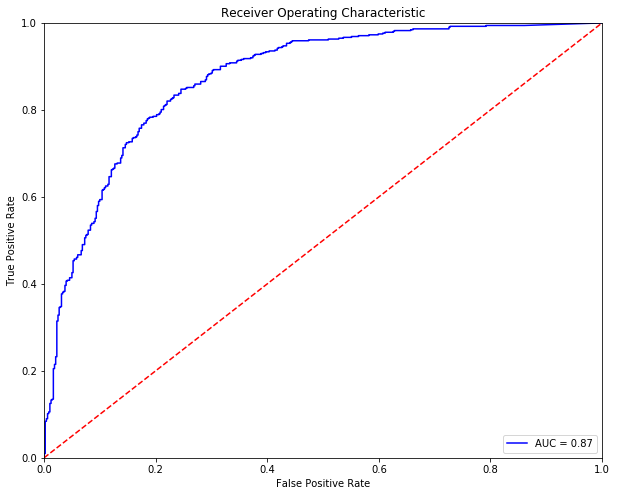

Optimal Threshold is 0.456279632406
Accuracy of Logistic Model on training data is: 0.792547834844


Predicted  0.0  1.0  __all__
Actual                      
0.0        382   99      481
1.0        107  405      512
__all__    489  504      993

In [286]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [287]:
table_80_50_PCA_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [288]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False           True                0.5        50          ovr   

             6       7    8  
index  penalty  solver  tol  
0           l2   lbfgs  0.1

Accuracy of the  Logistic  model for the training data is: 0.789871504157

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1574   426     2000
1           408  1561     1969
__all__    1982  1987     3969

Accuracy of the  Logistic  model for test data is: 0.789526686808

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          390   91      481
1          118  394      512
__all__    508  485      993

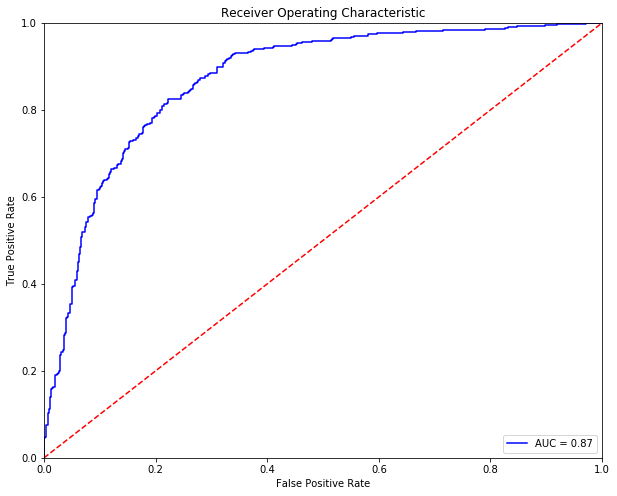

Optimal Threshold is 0.463637979934
Accuracy of Logistic Model on training data is: 0.793554884189


Predicted  0.0  1.0  __all__
Actual                      
0.0        382   99      481
1.0        106  406      512
__all__    488  505      993

In [289]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [290]:
table_80_50_PCA_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [291]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.793650793651

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1533   467     2000
1           352  1617     1969
__all__    1885  2084     3969

Accuracy of the  Random Forest Trees  model for test data is: 0.793554884189

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          373  108      481
1           97  415      512
__all__    470  523      993

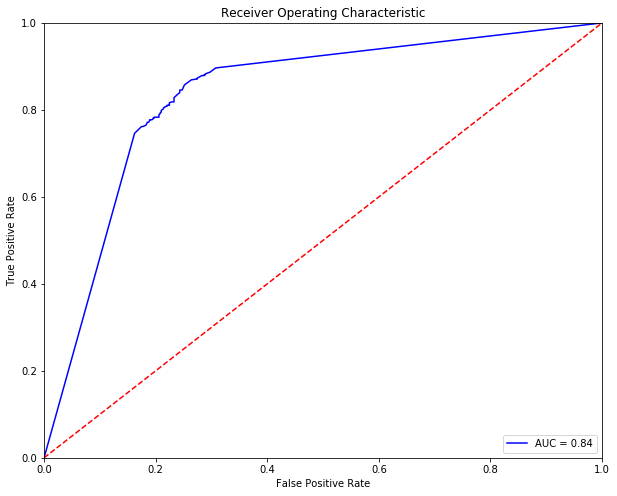

Optimal Threshold is 0.524698934813
Accuracy of Logistic Model on training data is: 0.791540785498


Predicted  0.0  1.0  __all__
Actual                      
0.0        381  100      481
1.0        107  405      512
__all__    488  505      993

In [292]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [293]:
table_80_50_PCA_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

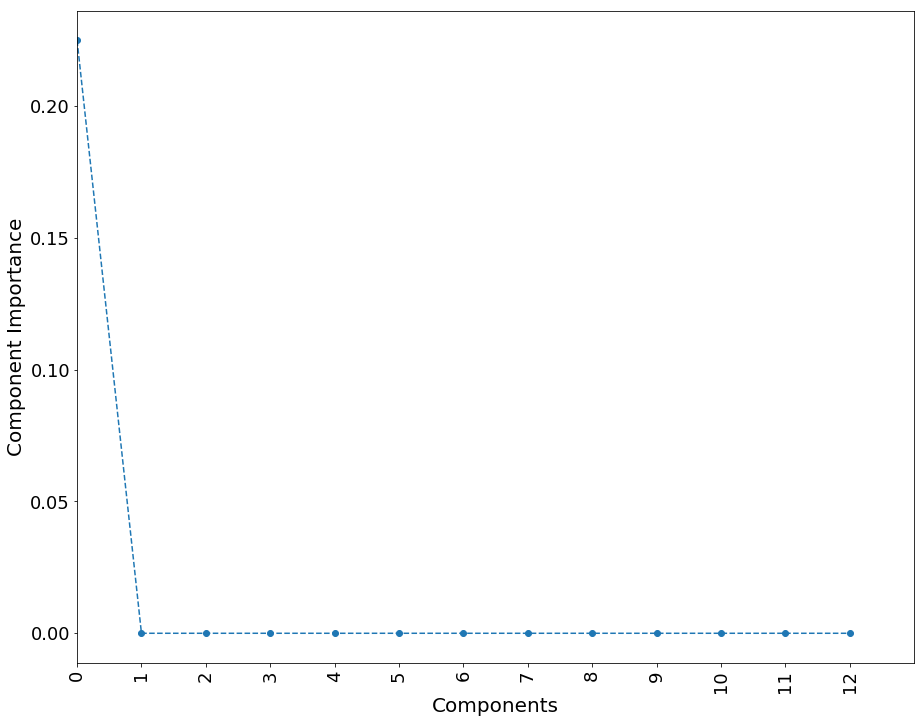

In [294]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [295]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME              1           150             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.799445704208

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1504   496     2000
1           300  1669     1969
__all__    1804  2165     3969

Accuracy of the  AdaBoostClassifier  model for test data is: 0.797583081571

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          370  111      481
1           90  422      512
__all__    460  533      993

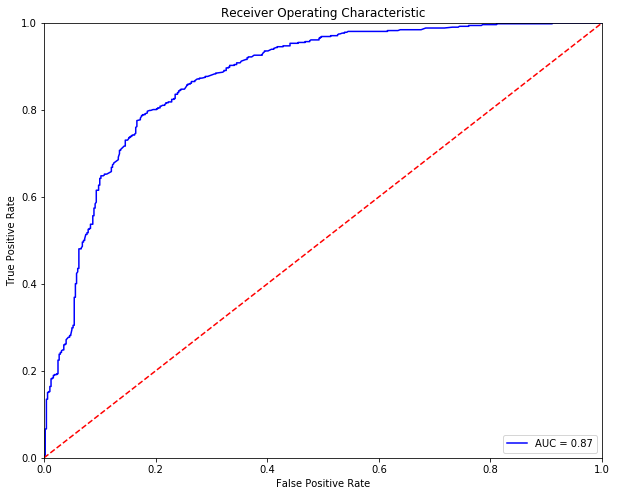

Optimal Threshold is 0.512098407
Accuracy of Logistic Model on training data is: 0.802618328298


Predicted  0.0  1.0  __all__
Actual                      
0.0        387   94      481
1.0        102  410      512
__all__    489  504      993

In [296]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [297]:
table_80_50_PCA_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

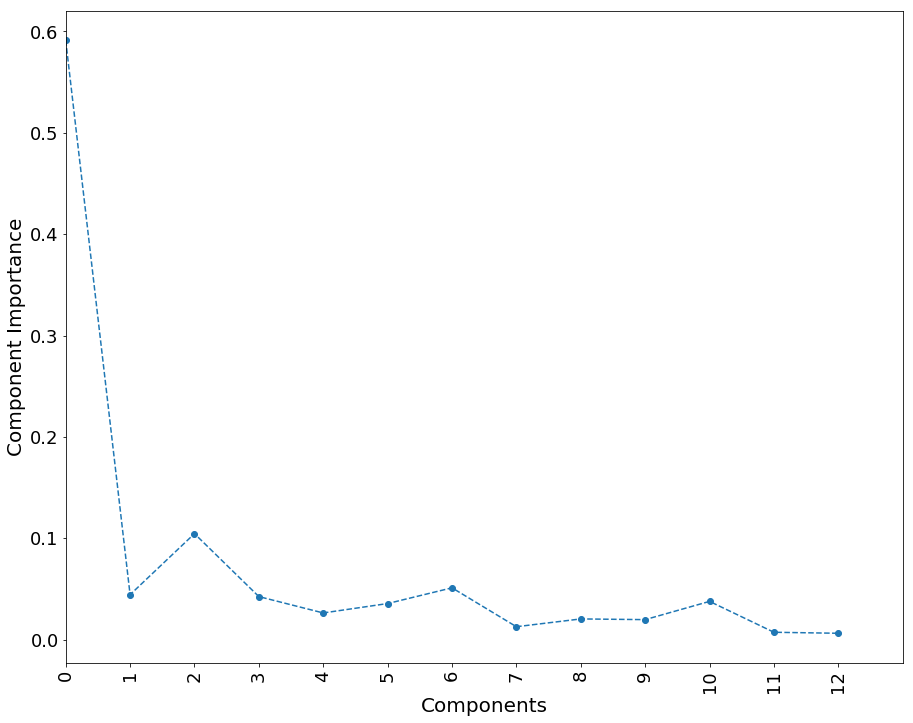

In [298]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [299]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.03  deviance                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           100             0          1

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.810279667423

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1569   431     2000
1           322  1647     1969
__all__    1891  2078     3969

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.804632426989

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          380  101      481
1           93  419      512
__all__    473  520      993

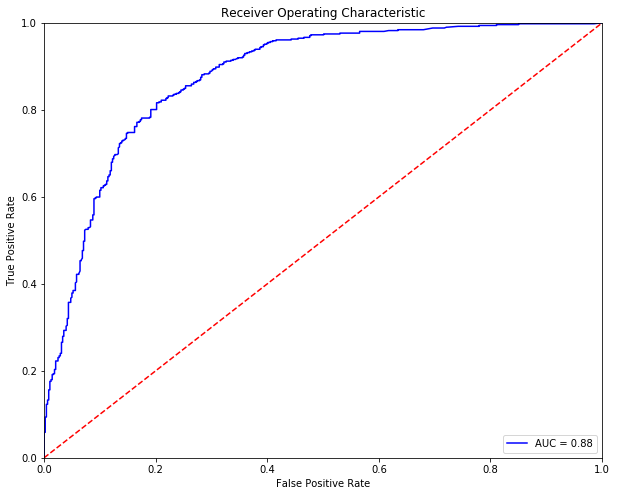

Optimal Threshold is 0.536026770405
Accuracy of Logistic Model on training data is: 0.800604229607


Predicted  0.0  1.0  __all__
Actual                      
0.0        385   96      481
1.0        102  410      512
__all__    487  506      993

In [300]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [301]:
table_80_50_PCA_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

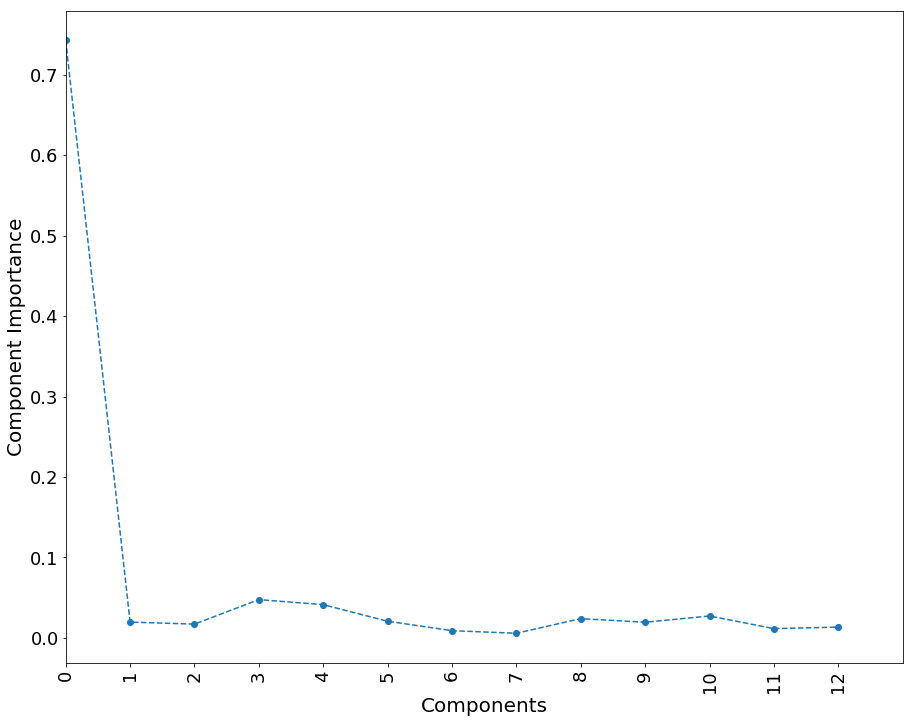

In [302]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [303]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     5                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.795918367347

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1619   381     2000
1           429  1540     1969
__all__    2048  1921     3969

Accuracy of the  Extra Decision Tree  model for test data is: 0.778449144008

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          388   93      481
1          127  385      512
__all__    515  478      993

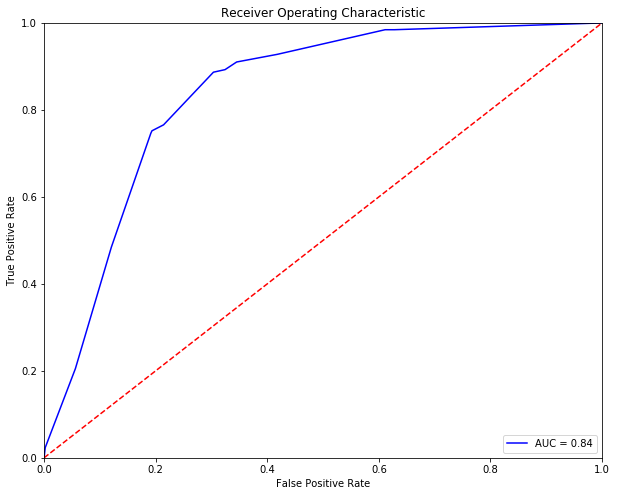

Optimal Threshold is 0.5
Accuracy of Logistic Model on training data is: 0.778449144008


Predicted  0.0  1.0  __all__
Actual                      
0.0        388   93      481
1.0        127  385      512
__all__    515  478      993

In [304]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [305]:
table_80_50_PCA_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [306]:
%%capture
table_80_50_PCA_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

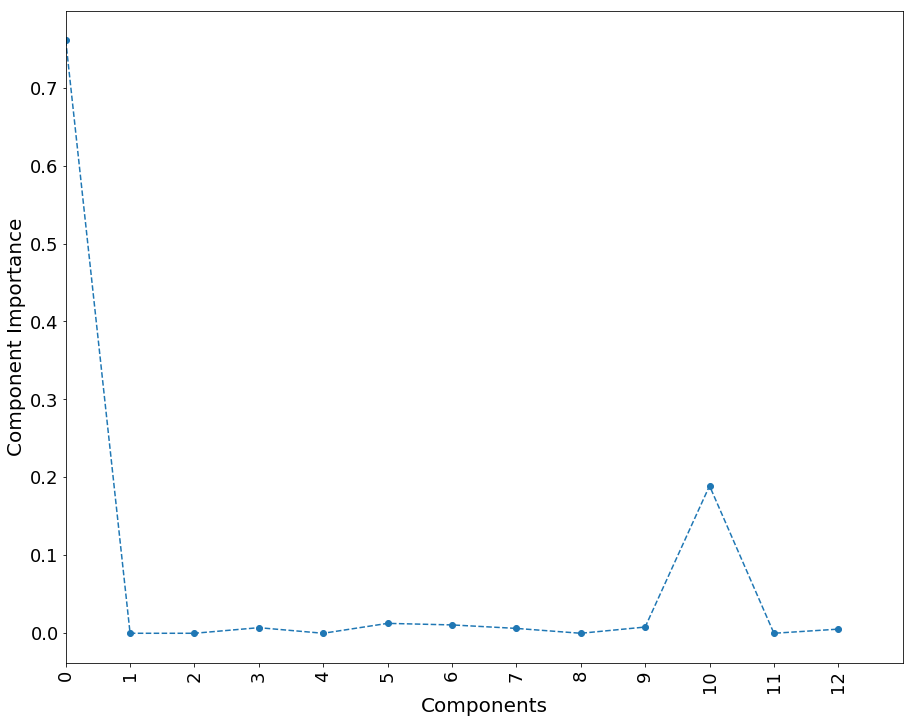

In [307]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [308]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.4           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.940287226002

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1855   145     2000
1            92  1877     1969
__all__    1947  2022     3969

Accuracy of the  Bagging  model for test data is: 0.799597180262

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          365  116      481
1           83  429      512
__all__    448  545      993

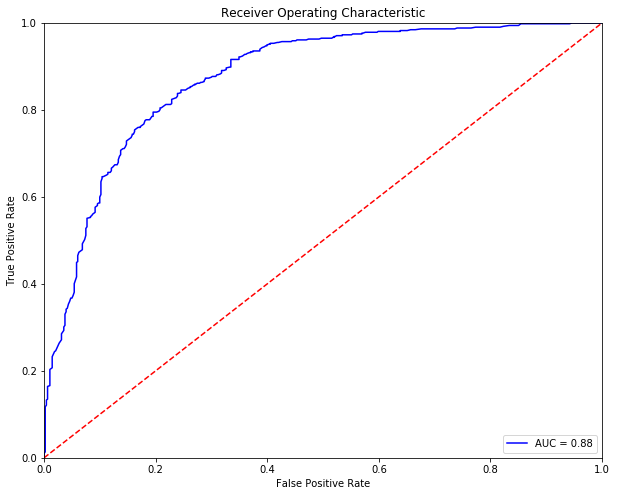

Optimal Threshold is 0.552
Accuracy of Logistic Model on training data is: 0.796576032226


Predicted  0.0  1.0  __all__
Actual                      
0.0        384   97      481
1.0        105  407      512
__all__    489  504      993

In [309]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [310]:
table_80_50_PCA_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [311]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.928949357521


Predicted     0     1  __all__
Actual                        
0          1833   167     2000
1           115  1854     1969
__all__    1948  2021     3969

The test accuracy is: 0.792547834844


Predicted    0    1  __all__
Actual                      
0          378  103      481
1          103  409      512
__all__    481  512      993

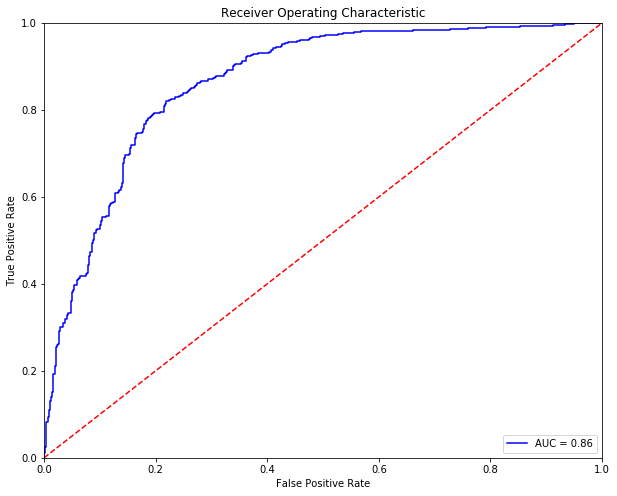

Optimal Threshold is 0.507082065864
Accuracy of Logistic Model on training data is: 0.793554884189


Predicted  0.0  1.0  __all__
Actual                      
0.0        382   99      481
1.0        106  406      512
__all__    488  505      993

In [312]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [313]:
table_80_50_PCA_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [314]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.848072562358


Predicted     0     1  __all__
Actual                        
0          1721   279     2000
1           324  1645     1969
__all__    2045  1924     3969

The accuracy of the model on test data is: 0.786505538771


Predicted    0    1  __all__
Actual                      
0          391   90      481
1          122  390      512
__all__    513  480      993

864/993 [=========================>....] - ETA: 0s

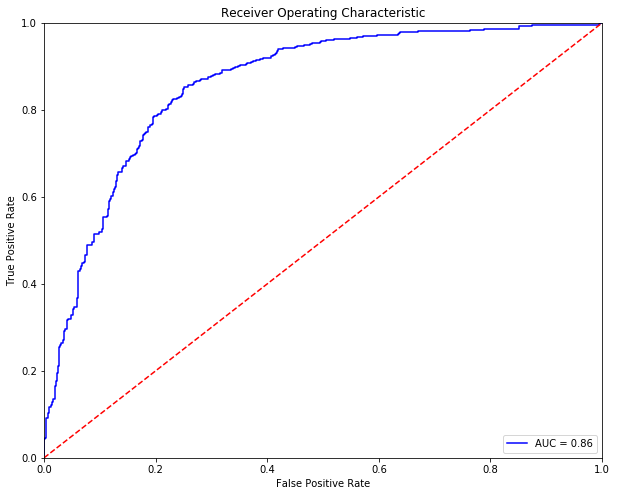

Optimal Threshold is 0.398691
Accuracy of Logistic Model on training data is: 0.791540785498


Predicted  0.0  1.0  __all__
Actual                      
0.0        381  100      481
1.0        107  405      512
__all__    488  505      993

In [315]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [316]:
table_80_50_PCA_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [317]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.2min finished


The accuracy of the model on training data is: 0.809019904258


Predicted     0     1  __all__
Actual                        
0          1590   410     2000
1           348  1621     1969
__all__    1938  2031     3969

The accuracy of the model on test data is: 0.802618328298


Predicted    0    1  __all__
Actual                      
0          391   90      481
1          106  406      512
__all__    497  496      993

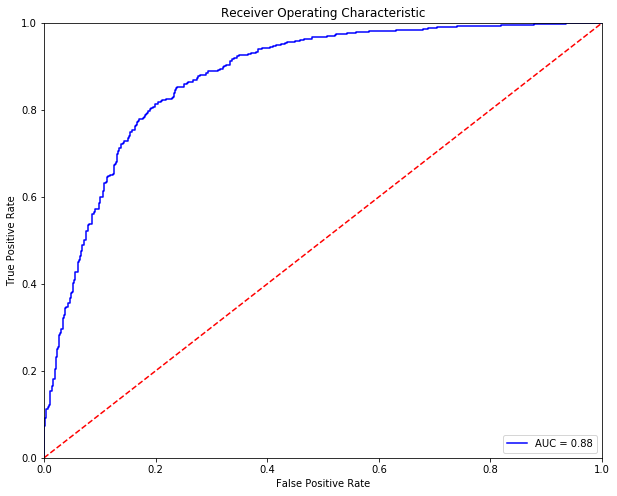

Optimal Threshold is 0.4754
Accuracy of Logistic Model on training data is: 0.805639476334


Predicted  0.0  1.0  __all__
Actual                      
0.0        388   93      481
1.0        100  412      512
__all__    488  505      993

In [318]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [319]:
table_80_50_PCA_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [320]:
table_80_50_PCA_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_PCA_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_PCA_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_PCA_10_test.set_index(['index'],drop=True,inplace=True)
table_80_50_PCA_10_train.set_index(['index'],drop=True,inplace=True)
table_80_50_PCA_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_PCA_10_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_PCA_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_PCA_10_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN     FPR  \
index                                                                        
KNeighborsClassifier        1.000000  1969.0  2000.0    0.0    0.0  0.0000   
LogisticRegression          0.789872  1561.0  1574.0  426.0  408.0  0.2130   
RandomForestClassifier      0.793651  1617.0  1533.0  467.0  352.0  0.2335   
AdaBoostClassifier          0.799446  1669.0  1504.0  496.0  300.0  0.2480   
GradientBoostingClassifier  0.810280  1647.0  1569.0  431.0  322.0  0.2155   
ExtraTreeClassifier         0.795918  1540.0  1619.0  381.0  429.0  0.1905   
BaggingClassifier           0.940287  1877.0  1855.0  145.0   92.0  0.0725   
VotingClassifier            0.928949  1854.0  1833.0  167.0  115.0  0.0835   
Neural Network-1            0.848073  1645.0  1721.0  279.0  324.0  0.1395   
Neural-Network-2            0.809020  1621.0  1590.0  410.0  348.0  0.2050   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.207212  
RandomForestClassifier      0.178771  
AdaBoostClassifier          0.152362  
GradientBoostingClassifier  0.163535  
ExtraTreeClassifier         0.217877  
BaggingClassifier           0.046724  
VotingClassifier            0.058405  
Neural Network-1            0.164551  
Neural-Network-2            0.176739

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.791541  389.0  397.0   84.0  123.0  0.174636   
LogisticRegression          0.789527  394.0  390.0   91.0  118.0  0.189189   
RandomForestClassifier      0.793555  415.0  373.0  108.0   97.0  0.224532   
AdaBoostClassifier          0.797583  422.0  370.0  111.0   90.0  0.230769   
GradientBoostingClassifier  0.804632  419.0  380.0  101.0   93.0  0.209979   
ExtraTreeClassifier         0.778449  385.0  388.0   93.0  127.0  0.193347   
BaggingClassifier           0.799597  429.0  365.0  116.0   83.0  0.241164   
VotingClassifier            0.792548  409.0  378.0  103.0  103.0  0.214137   
Neural Network-1            0.786506  390.0  391.0   90.0  122.0  0.187110   
Neural-Network-2            0.802618  406.0  391.0   90.0  106.0  0.187110   

                                 FNR  
index                                 
KNeighborsClassifier        0.240234  
LogisticRegression          0.230469  
RandomForestClassifier      0.189453  
AdaBoostClassifier          0.175781  
GradientBoostingClassifier  0.181641  
ExtraTreeClassifier         0.248047  
BaggingClassifier           0.162109  
VotingClassifier            0.201172  
Neural Network-1            0.238281  
Neural-Network-2            0.207031

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.792548  405.0  382.0   99.0  107.0  0.205821   
LogisticRegression          0.793555  406.0  382.0   99.0  106.0  0.205821   
RandomForestClassifier      0.791541  405.0  381.0  100.0  107.0  0.207900   
AdaBoostClassifier          0.802618  410.0  387.0   94.0  102.0  0.195426   
GradientBoostingClassifier  0.800604  410.0  385.0   96.0  102.0  0.199584   
ExtraTreeClassifier         0.778449  385.0  388.0   93.0  127.0  0.193347   
BaggingClassifier           0.796576  407.0  384.0   97.0  105.0  0.201663   
VotingClassifier            0.793555  406.0  382.0   99.0  106.0  0.205821   
Neural Network-1            0.791541  405.0  381.0  100.0  107.0  0.207900   
Neural-Network-2            0.805639  412.0  388.0   93.0  100.0  0.193347   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.208984   0.456280  0.873313  
LogisticRegression          0.207031   0.463638  0.870119  
RandomForestClassifier      0.208984   0.524699  0.837282  
AdaBoostClassifier          0.199219   0.512098  0.873492  
GradientBoostingClassifier  0.199219   0.536027  0.877473  
ExtraTreeClassifier         0.248047   0.500000  0.837655  
BaggingClassifier           0.205078   0.552000  0.875008  
VotingClassifier            0.207031   0.507082  0.864739  
Neural Network-1            0.208984   0.398691  0.858835  
Neural-Network-2            0.195312   0.475400  0.876986

#### Random State 20

In [321]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  3728  132.185891   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...    81   31.061728   

                                                           PAS         LEN  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  103.969421  135.190987   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...   25.246914  109.395062   

                                                            BYS  \
Source_User                                                       
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  8652.968348   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...  3871.506173   

                                                              BYR      SP  \
Source_User                                                                 
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  178992.604882  3096.0   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...   17973.666667    80.0   

                                                       DP  NAPP  SIP  DIP  \
Source_User                                                                 
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  264.0    44  114  784   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...    3.0    10   12   28   

                                                            TDIF  0000  0100  \
Source_User                                                                    
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   2041.380633    72    81   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...  88488.987654     1     0   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   115   106   131   116   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0     0   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   100   355   279   152   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0     0   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   196   153   135   443   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0    10   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   243   195   185   132   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     1    25    32   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   152   107    90   107   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     2     8     0     0   

                                                    2200  2300  
Source_User                                                     
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...    38    45  
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     2     0

1 -> Infected
0 -> Uninfected


Source_User
1da09acf8ddc082a297329856e8512e0aa25eef1650894f3e39d24006b3b9900    1
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8ddc3d1beabef89096b    0
c7ae13801caa67d372db28e31fe24146a34866c75fdaa7a8f3dd2e52c8feadbf    0
d7a31b1f8a1b6229ffc4f3d615d4847d8844645ed5bc9d4f016352ccde33eeef    0
2e8858be6011eed9b63eb701eda4575a43151dcedbd12b1e87e9707f1355e52d    1
aef14742e536c93ce48a00a70bc5c429ff5973e95f029488785eeda1778ea086    1
0930d98b6033a246eaecdf425d4fe74341a505bb2ffb83a09d4e489b29dea307    1
3f716f2fcc54a3eac07cc68af79773e6e32cc680c5f1b1e44ad527af39210d58    1
655f71c7531f608b3aa19880786cc023e26286b3bef2ad9917e379ddcead4e43    1
5957761ffa31d8e6cf65bb4540565c1ebd6e030e40b744a5c21d4d4b7c0d7d63    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.92323693469
The train/test split ratio is 80:20


In [322]:
display(X_pca_13[0:1])

array([[ 0.13373123, -0.0019507 , -0.36419166, -1.2822501 , -0.46750246,
         0.64125319, -0.49135909, -0.99415923,  0.95652515,  0.62057691,
        -0.11989609, -1.23106676,  1.65652418]])

In [323]:
## Table to store training and test measures
table_80_50_PCA_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_PCA_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_PCA_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [324]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1950     0     1950
1             0  2019     2019
__all__    1950  2019     3969

Accuracy of the  KNN  model for test data is: 0.764350453172

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          410  121      531
1          113  349      462
__all__    523  470      993

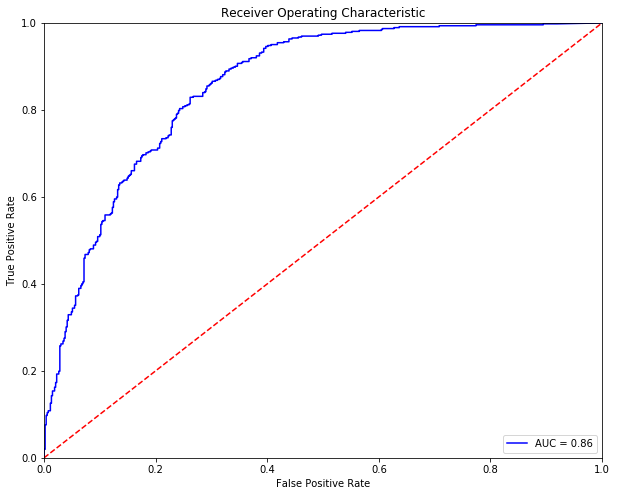

Optimal Threshold is 0.488211102683
Accuracy of Logistic Model on training data is: 0.77139979859


Predicted  0.0  1.0  __all__
Actual                      
0.0        409  122      531
1.0        105  357      462
__all__    514  479      993

In [325]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [326]:
table_80_50_PCA_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [327]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.3  False           True                0.5        50          ovr   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  1e-05

Accuracy of the  Logistic  model for the training data is: 0.785588309398

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1538   412     1950
1           439  1580     2019
__all__    1977  1992     3969

Accuracy of the  Logistic  model for test data is: 0.780463242699

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          409  122      531
1           96  366      462
__all__    505  488      993

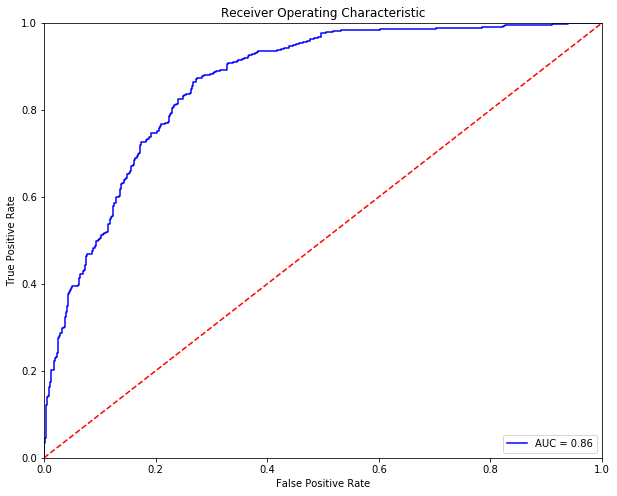

Optimal Threshold is 0.518909524399
Accuracy of Logistic Model on training data is: 0.775427995972


Predicted  0.0  1.0  __all__
Actual                      
0.0        413  118      531
1.0        105  357      462
__all__    518  475      993

In [328]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [329]:
table_80_50_PCA_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [330]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0        entropy         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.785588309398

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1414   536     1950
1           315  1704     2019
__all__    1729  2240     3969

Accuracy of the  Random Forest Trees  model for test data is: 0.790533736153

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          385  146      531
1           62  400      462
__all__    447  546      993

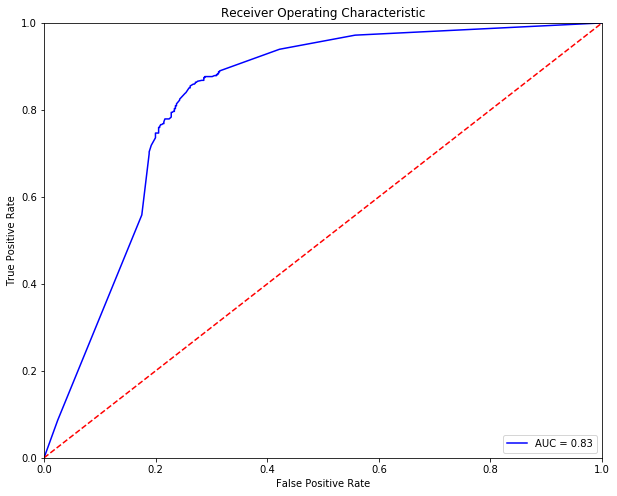

Optimal Threshold is 0.539470964443
Accuracy of Logistic Model on training data is: 0.778449144008


Predicted  0.0  1.0  __all__
Actual                      
0.0        413  118      531
1.0        102  360      462
__all__    515  478      993

In [331]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [332]:
table_80_50_PCA_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

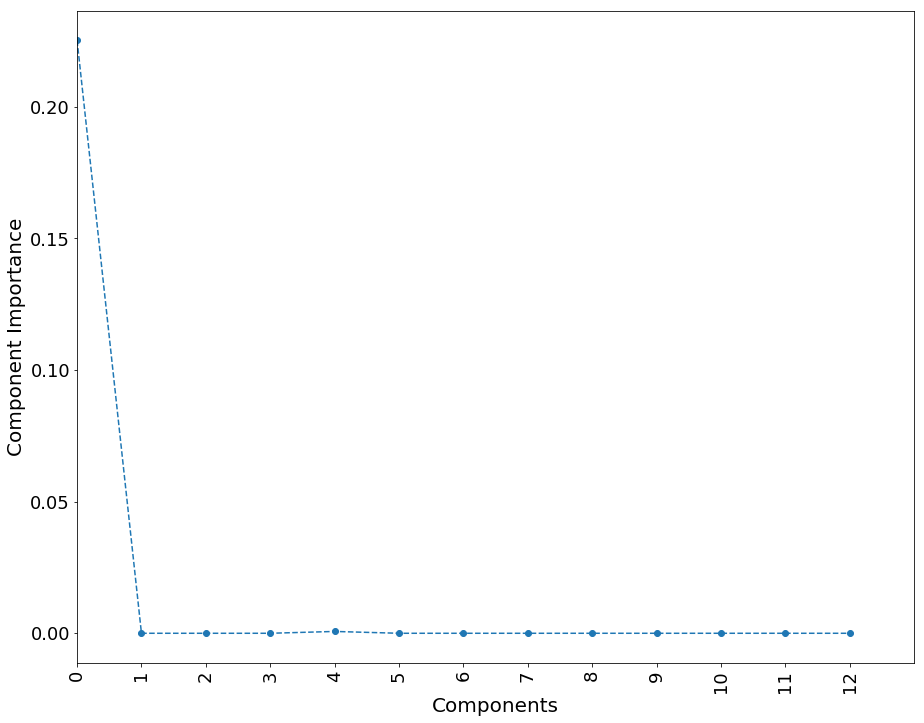

In [333]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [334]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0        SAMME.R            0.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.801713277904

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1491   459     1950
1           328  1691     2019
__all__    1819  2150     3969

Accuracy of the  AdaBoostClassifier  model for test data is: 0.785498489426

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          398  133      531
1           80  382      462
__all__    478  515      993

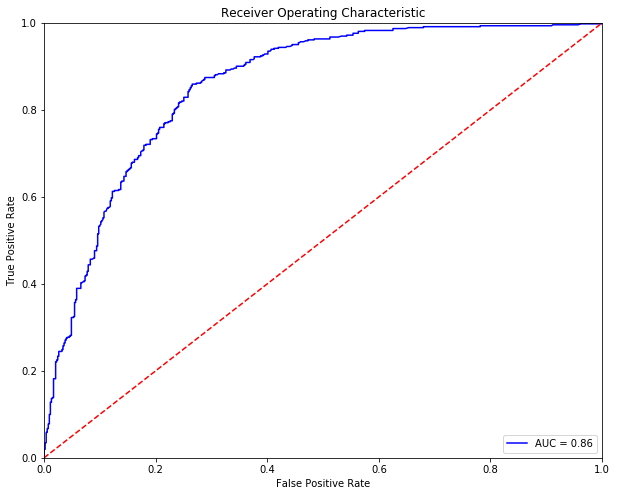

Optimal Threshold is 0.503163120551
Accuracy of Logistic Model on training data is: 0.773413897281


Predicted  0.0  1.0  __all__
Actual                      
0.0        411  120      531
1.0        105  357      462
__all__    516  477      993

In [335]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [336]:
table_80_50_PCA_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

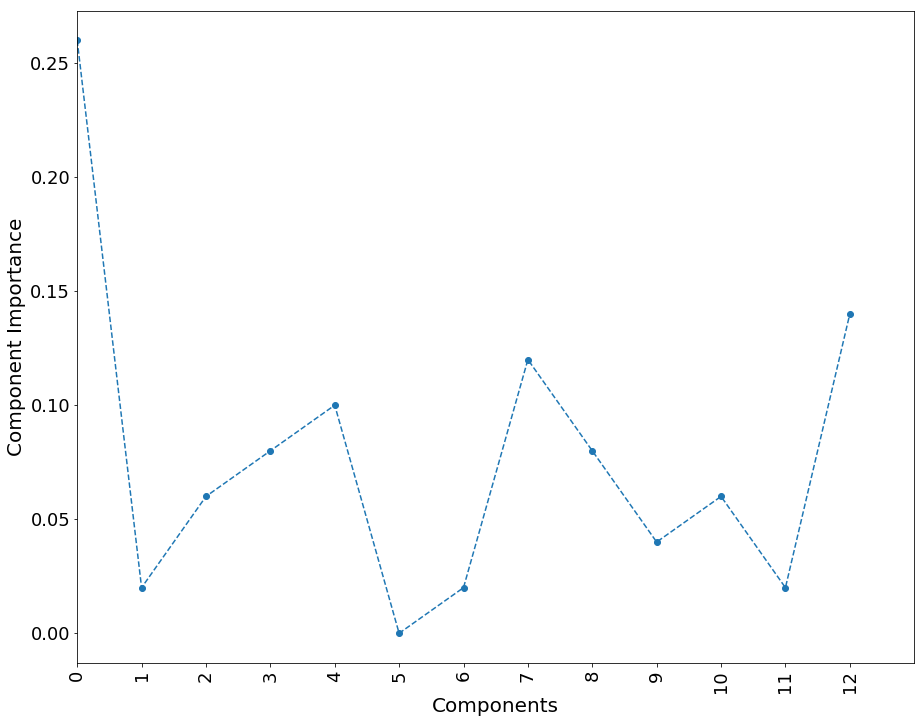

In [337]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [338]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.03  deviance                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2           100             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.803728898967

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1524   426     1950
1           353  1666     2019
__all__    1877  2092     3969

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.784491440081

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          400  131      531
1           83  379      462
__all__    483  510      993

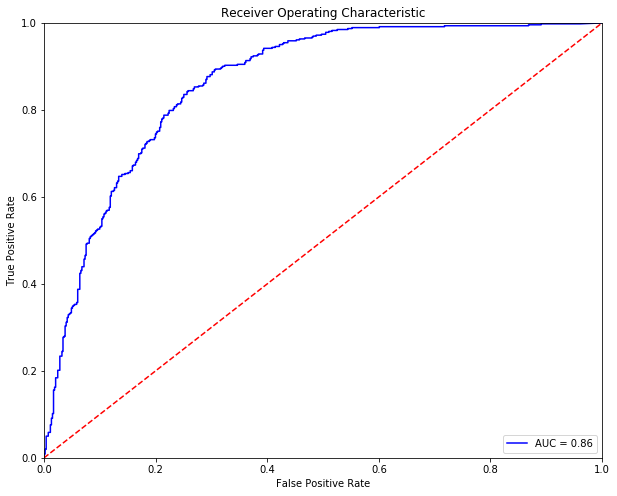

Optimal Threshold is 0.577547228657
Accuracy of Logistic Model on training data is: 0.785498489426


Predicted  0.0  1.0  __all__
Actual                      
0.0        417  114      531
1.0         99  363      462
__all__    516  477      993

In [339]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [340]:
table_80_50_PCA_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

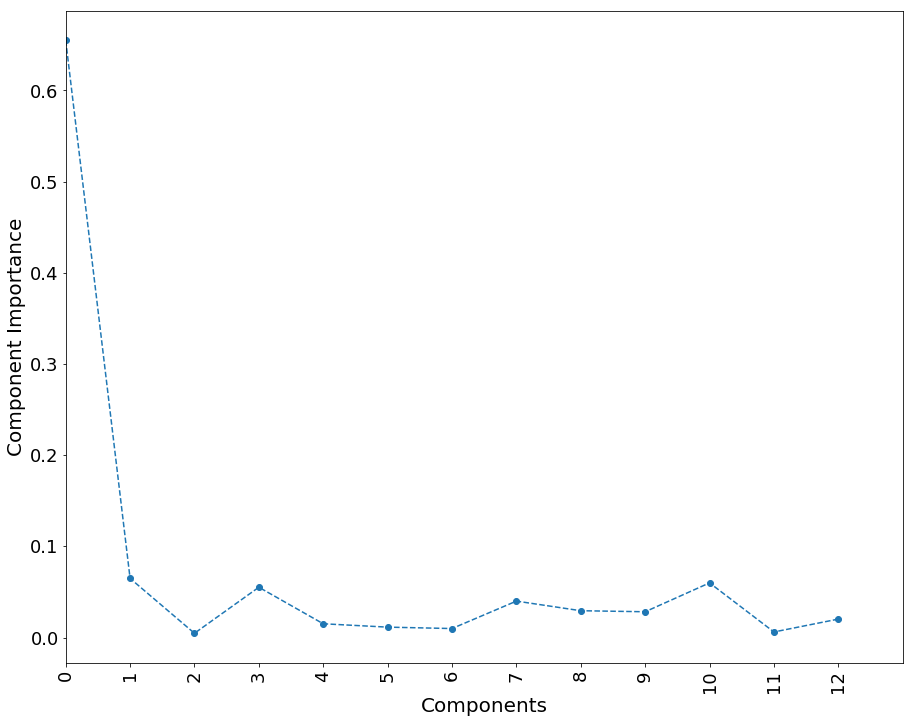

In [341]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [342]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     5                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.817586293777

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1568   382     1950
1           342  1677     2019
__all__    1910  2059     3969

Accuracy of the  Extra Decision Tree  model for test data is: 0.763343403827

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          390  141      531
1           94  368      462
__all__    484  509      993

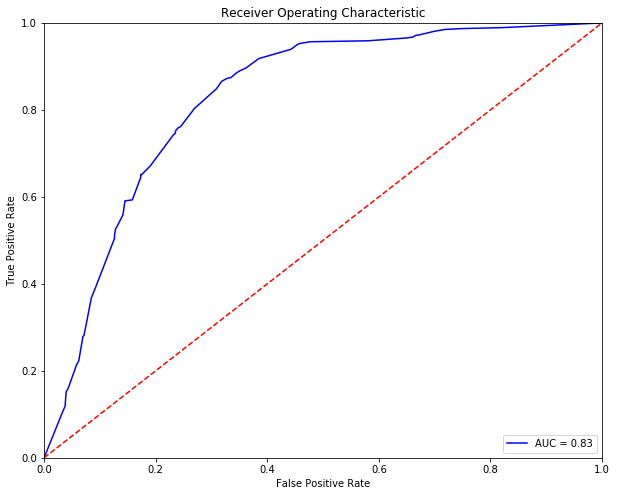

Optimal Threshold is 0.625
Accuracy of Logistic Model on training data is: 0.7583081571


Predicted  0.0  1.0  __all__
Actual                      
0.0        406  125      531
1.0        115  347      462
__all__    521  472      993

In [343]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [344]:
table_80_50_PCA_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [345]:
%%capture
table_80_50_PCA_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

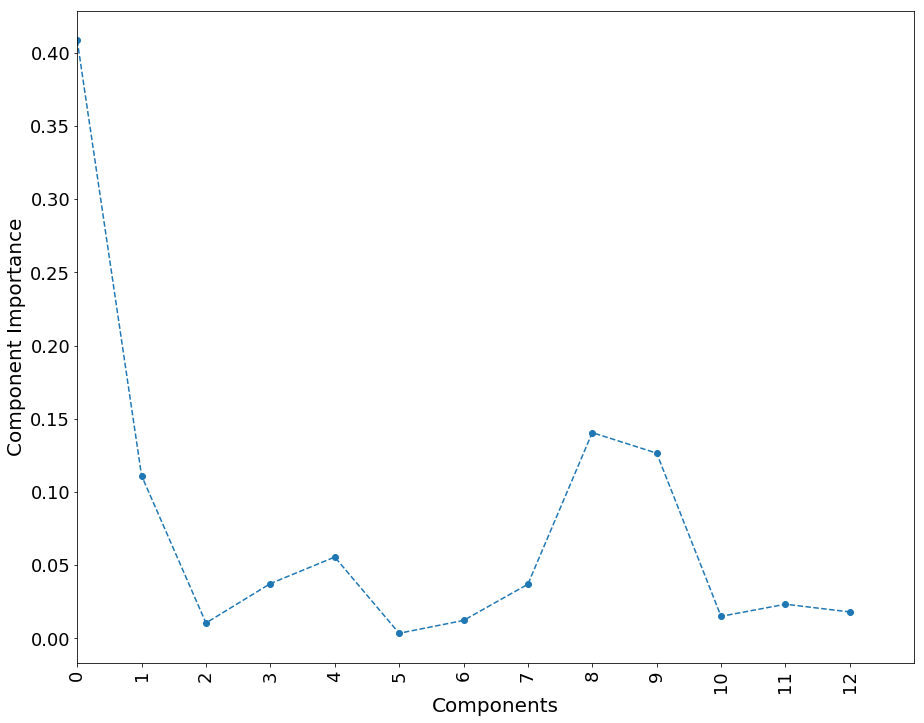

In [346]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [347]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.6          1000   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.996976568405

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1948     2     1950
1            10  2009     2019
__all__    1958  2011     3969

Accuracy of the  Bagging  model for test data is: 0.781470292044

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          391  140      531
1           77  385      462
__all__    468  525      993

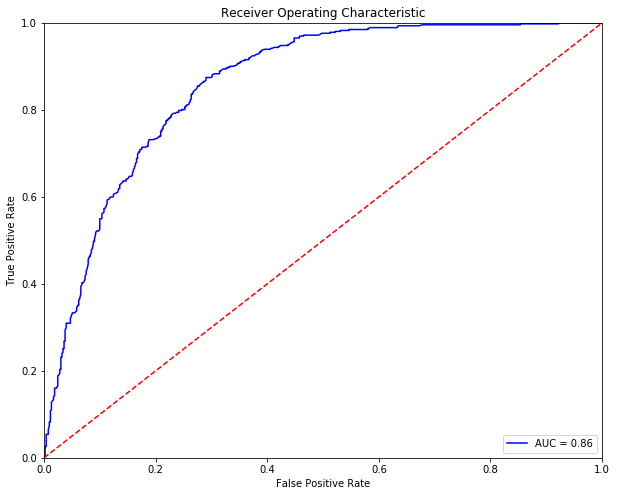

Optimal Threshold is 0.564
Accuracy of Logistic Model on training data is: 0.778449144008


Predicted  0.0  1.0  __all__
Actual                      
0.0        414  117      531
1.0        103  359      462
__all__    517  476      993

In [348]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [349]:
table_80_50_PCA_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [350]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.938523557571


Predicted     0     1  __all__
Actual                        
0          1805   145     1950
1            99  1920     2019
__all__    1904  2065     3969

The test accuracy is: 0.778449144008


Predicted    0    1  __all__
Actual                      
0          397  134      531
1           86  376      462
__all__    483  510      993

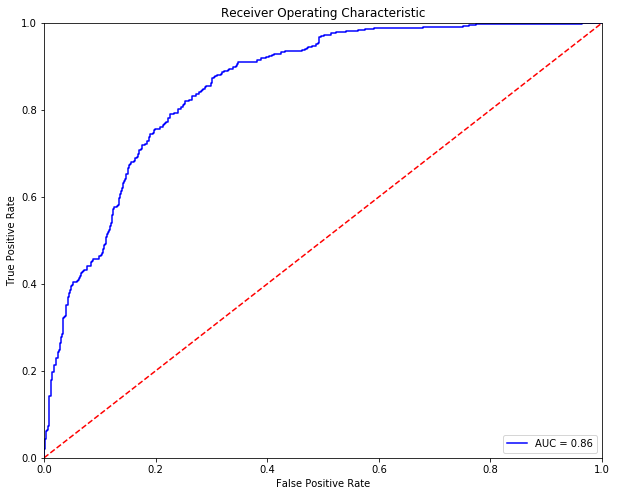

Optimal Threshold is 0.533109776229
Accuracy of Logistic Model on training data is: 0.778449144008


Predicted  0.0  1.0  __all__
Actual                      
0.0        413  118      531
1.0        102  360      462
__all__    515  478      993

In [351]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [352]:
table_80_50_PCA_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [353]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.847064751827


Predicted     0     1  __all__
Actual                        
0          1664   286     1950
1           321  1698     2019
__all__    1985  1984     3969

The accuracy of the model on test data is: 0.767371601208


Predicted    0    1  __all__
Actual                      
0          406  125      531
1          106  356      462
__all__    512  481      993

512/993 [==============>...............] - ETA: 0s

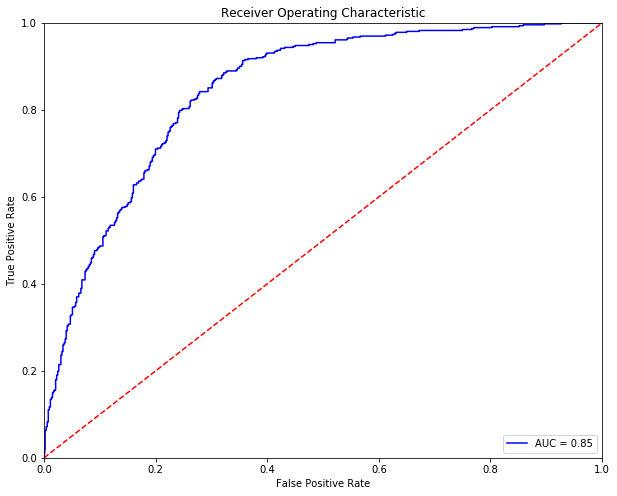

Optimal Threshold is 0.501434
Accuracy of Logistic Model on training data is: 0.767371601208


Predicted  0.0  1.0  __all__
Actual                      
0.0        408  123      531
1.0        108  354      462
__all__    516  477      993

In [354]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [355]:
table_80_50_PCA_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [356]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.7min finished


The accuracy of the model on training data is: 0.804232804233


Predicted     0     1  __all__
Actual                        
0          1541   409     1950
1           368  1651     2019
__all__    1909  2060     3969

The accuracy of the model on test data is: 0.787512588117


Predicted    0    1  __all__
Actual                      
0          408  123      531
1           88  374      462
__all__    496  497      993

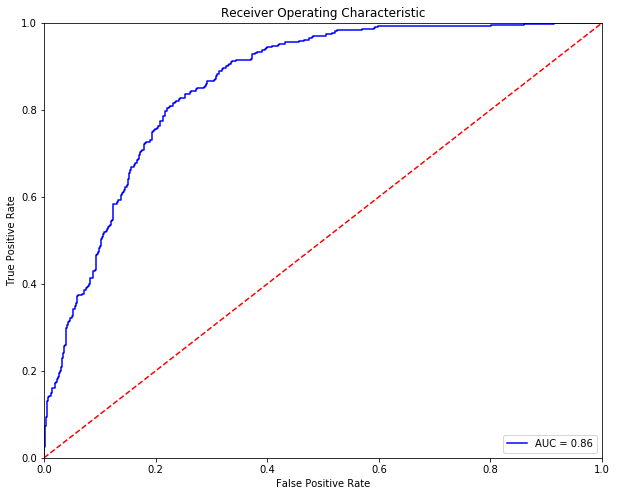

Optimal Threshold is 0.565247
Accuracy of Logistic Model on training data is: 0.785498489426


Predicted  0.0  1.0  __all__
Actual                      
0.0        418  113      531
1.0        100  362      462
__all__    518  475      993

In [357]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [358]:
table_80_50_PCA_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_PCA_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_PCA_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [359]:
table_80_50_PCA_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_PCA_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_PCA_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_PCA_20_test.set_index(['index'],drop=True,inplace=True)
table_80_50_PCA_20_train.set_index(['index'],drop=True,inplace=True)
table_80_50_PCA_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_PCA_20_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_PCA_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_PCA_20_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  2019.0  1950.0    0.0    0.0  0.000000   
LogisticRegression          0.785588  1580.0  1538.0  412.0  439.0  0.211282   
RandomForestClassifier      0.785588  1704.0  1414.0  536.0  315.0  0.274872   
AdaBoostClassifier          0.801713  1691.0  1491.0  459.0  328.0  0.235385   
GradientBoostingClassifier  0.803729  1666.0  1524.0  426.0  353.0  0.218462   
ExtraTreeClassifier         0.817586  1677.0  1568.0  382.0  342.0  0.195897   
BaggingClassifier           0.996977  2009.0  1948.0    2.0   10.0  0.001026   
VotingClassifier            0.938524  1920.0  1805.0  145.0   99.0  0.074359   
Neural Network-1            0.847065  1698.0  1664.0  286.0  321.0  0.146667   
Neural-Network-2            0.804233  1651.0  1541.0  409.0  368.0  0.209744   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.217434  
RandomForestClassifier      0.156018  
AdaBoostClassifier          0.162457  
GradientBoostingClassifier  0.174839  
ExtraTreeClassifier         0.169391  
BaggingClassifier           0.004953  
VotingClassifier            0.049034  
Neural Network-1            0.158990  
Neural-Network-2            0.182268

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.764350  349.0  410.0  121.0  113.0  0.227872   
LogisticRegression          0.780463  366.0  409.0  122.0   96.0  0.229755   
RandomForestClassifier      0.790534  400.0  385.0  146.0   62.0  0.274953   
AdaBoostClassifier          0.785498  382.0  398.0  133.0   80.0  0.250471   
GradientBoostingClassifier  0.784491  379.0  400.0  131.0   83.0  0.246704   
ExtraTreeClassifier         0.763343  368.0  390.0  141.0   94.0  0.265537   
BaggingClassifier           0.781470  385.0  391.0  140.0   77.0  0.263653   
VotingClassifier            0.778449  376.0  397.0  134.0   86.0  0.252354   
Neural Network-1            0.767372  356.0  406.0  125.0  106.0  0.235405   
Neural-Network-2            0.787513  374.0  408.0  123.0   88.0  0.231638   

                                 FNR  
index                                 
KNeighborsClassifier        0.244589  
LogisticRegression          0.207792  
RandomForestClassifier      0.134199  
AdaBoostClassifier          0.173160  
GradientBoostingClassifier  0.179654  
ExtraTreeClassifier         0.203463  
BaggingClassifier           0.166667  
VotingClassifier            0.186147  
Neural Network-1            0.229437  
Neural-Network-2            0.190476

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.771400  357.0  409.0  122.0  105.0  0.229755   
LogisticRegression          0.775428  357.0  413.0  118.0  105.0  0.222222   
RandomForestClassifier      0.778449  360.0  413.0  118.0  102.0  0.222222   
AdaBoostClassifier          0.773414  357.0  411.0  120.0  105.0  0.225989   
GradientBoostingClassifier  0.785498  363.0  417.0  114.0   99.0  0.214689   
ExtraTreeClassifier         0.758308  347.0  406.0  125.0  115.0  0.235405   
BaggingClassifier           0.778449  359.0  414.0  117.0  103.0  0.220339   
VotingClassifier            0.778449  360.0  413.0  118.0  102.0  0.222222   
Neural Network-1            0.767372  354.0  408.0  123.0  108.0  0.231638   
Neural-Network-2            0.785498  362.0  418.0  113.0  100.0  0.212806   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.227273   0.488211  0.857263  
LogisticRegression          0.227273   0.518910  0.862952  
RandomForestClassifier      0.220779   0.539471  0.825756  
AdaBoostClassifier          0.227273   0.503163  0.857463  
GradientBoostingClassifier  0.214286   0.577547  0.862844  
ExtraTreeClassifier         0.248918   0.625000  0.826881  
BaggingClassifier           0.222944   0.564000  0.860316  
VotingClassifier            0.220779   0.533110  0.857440  
Neural Network-1            0.233766   0.501434  0.845163  
Neural-Network-2            0.216450   0.565247  0.858753

###  <a id='1.D' style="text-decoration : none; color : #000000;">70:30 Train Test Split with PCA</a>
#### Random State 0

In [360]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     4    1.00000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  9326  236.40564   

                                                           PAS        LEN  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...    1.000000  31.000000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  130.825005  78.920437   

                                                             BYS  \
Source_User                                                        
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     77.500000   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  16523.837122   

                                                              BYR      SP  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     225.750000     4.0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  308234.733219  7070.0   

                                                      DP  NAPP  SIP   DIP  \
Source_User                                                                 
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...   1.0     1    1     1   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  26.0    47   74  1610   

                                                          TDIF  0000  0100  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...    0.250000     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...  796.853957   528   582   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   519   540   512   417   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   421   626   360   346   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   223   308   207   272   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     0     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   844   136   298   175   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0     4     0   
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   259   359   259   323   

                                                    2200  2300  
Source_User                                                     
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1...     0     0  
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c...   397   415

1 -> Infected
0 -> Uninfected


Source_User
21f9a46d094a0039eac8b09f38e2a760d7977c809ec91a1193b2d05e46c2e870    0
705f5e8c54520cba59aa4307a315b09f35dd4138efb687c1f6ca9d117f8b3530    1
c2cf660ad094544b4bb8f01efb417804cfa5d53624783c2f784faac2b244c029    1
3fcd1179a650c2cfc6b6d23aa0193f8247ea56691044389f53a1e771431e2862    0
55394724a0a52464de210c953c5e6bee779e0f0a163aa4787087024004caeb82    1
327686c9e4533b14641208d230f5d01b93dcdd21d71360fbcac0d78d487c58ab    0
bc72f41bcdc4b3e5ee020baae91eb97b6c4ca7a1209ed7a69f4f0915de990aa2    0
d49890688b35443d361df19e2bfeaeddeda4d5572c03cf5678f9b36e01cf5415    1
01c615bd6e5026eb8f8ce76567d9f00c3eec2b1752da1854ece27439da4c0fe9    0
469c1c634cf9e6412e08bda889e471ef6af563097f737223a09ad50e7364cfa9    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.918903941373
The train/test split ratio is 70:30


In [361]:
display(X_pca_13[0:1])

array([[-0.88239461, -0.51557388,  0.22276869,  0.36425984,  0.1785245 ,
         0.62838131, -0.23203605,  0.5829496 , -1.30103283,  0.47369319,
         0.18877514,  0.00313269,  0.23901109]])

In [362]:
## Table to store training and test measures
table_70_50_PCA_0_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_PCA_0_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_PCA_0_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [363]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           20  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1766     0     1766
1             0  1707     1707
__all__    1766  1707     3473

Accuracy of the  KNN  model for test data is: 0.770987239758

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          566  149      715
1          192  582      774
__all__    758  731     1489

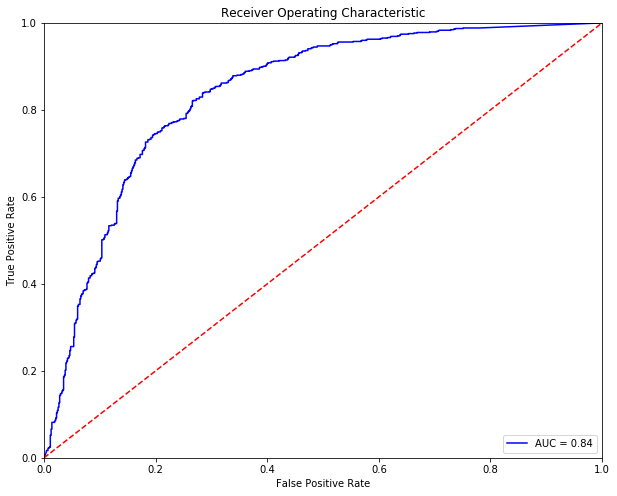

Optimal Threshold is 0.462404600062
Accuracy of Logistic Model on training data is: 0.770987239758


Predicted  0.0  1.0  __all__
Actual                      
0.0        552  163      715
1.0        178  596      774
__all__    730  759     1489

In [364]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [365]:
table_70_50_PCA_0_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_0_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_0_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [366]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.796141664267

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1411   355     1766
1           353  1354     1707
__all__    1764  1709     3473

Accuracy of the  Logistic  model for test data is: 0.781061114842

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          575  140      715
1          186  588      774
__all__    761  728     1489

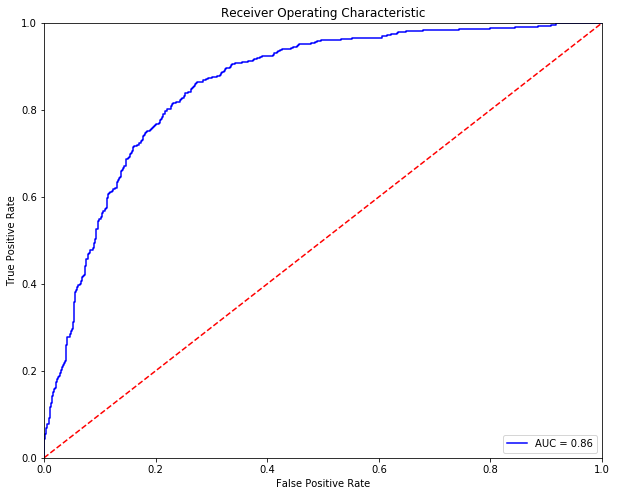

Optimal Threshold is 0.485599357428
Accuracy of Logistic Model on training data is: 0.78643384822


Predicted  0.0  1.0  __all__
Actual                      
0.0        563  152      715
1.0        166  608      774
__all__    729  760     1489

In [367]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [368]:
table_70_50_PCA_0_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_0_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_0_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [369]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0        entropy         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.796141664267

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1310   456     1766
1           252  1455     1707
__all__    1562  1911     3473

Accuracy of the  Random Forest Trees  model for test data is: 0.788448623237

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          523  192      715
1          123  651      774
__all__    646  843     1489

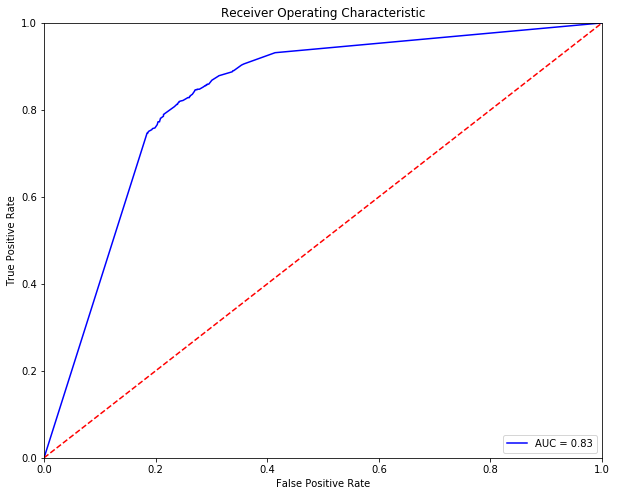

Optimal Threshold is 0.539883483969
Accuracy of Logistic Model on training data is: 0.785762256548


Predicted  0.0  1.0  __all__
Actual                      
0.0        566  149      715
1.0        170  604      774
__all__    736  753     1489

In [370]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [371]:
table_70_50_PCA_0_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_0_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_0_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

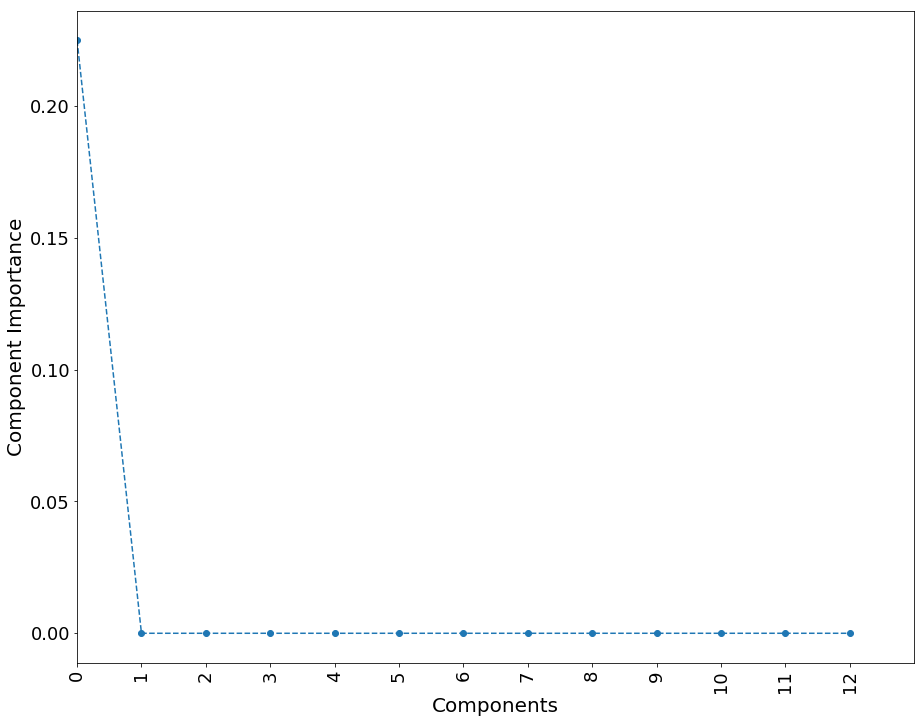

In [372]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [373]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.801324503311

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1335   431     1766
1           259  1448     1707
__all__    1594  1879     3473

Accuracy of the  AdaBoostClassifier  model for test data is: 0.785090664876

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          529  186      715
1          134  640      774
__all__    663  826     1489

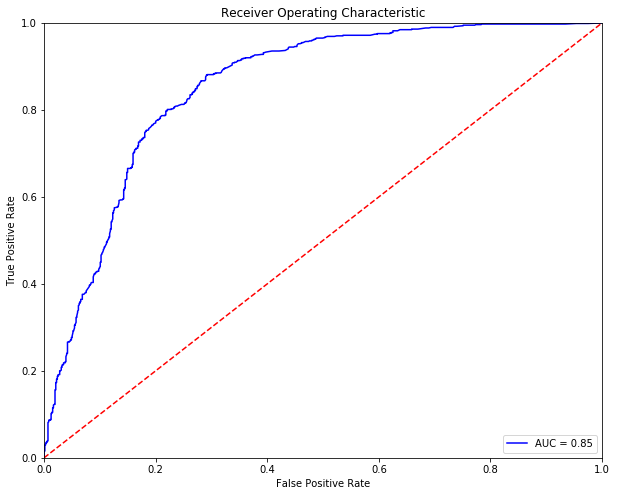

Optimal Threshold is 0.507429981241
Accuracy of Logistic Model on training data is: 0.787777031565


Predicted  0.0  1.0  __all__
Actual                      
0.0        564  151      715
1.0        165  609      774
__all__    729  760     1489

In [374]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [375]:
table_70_50_PCA_0_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_0_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_0_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

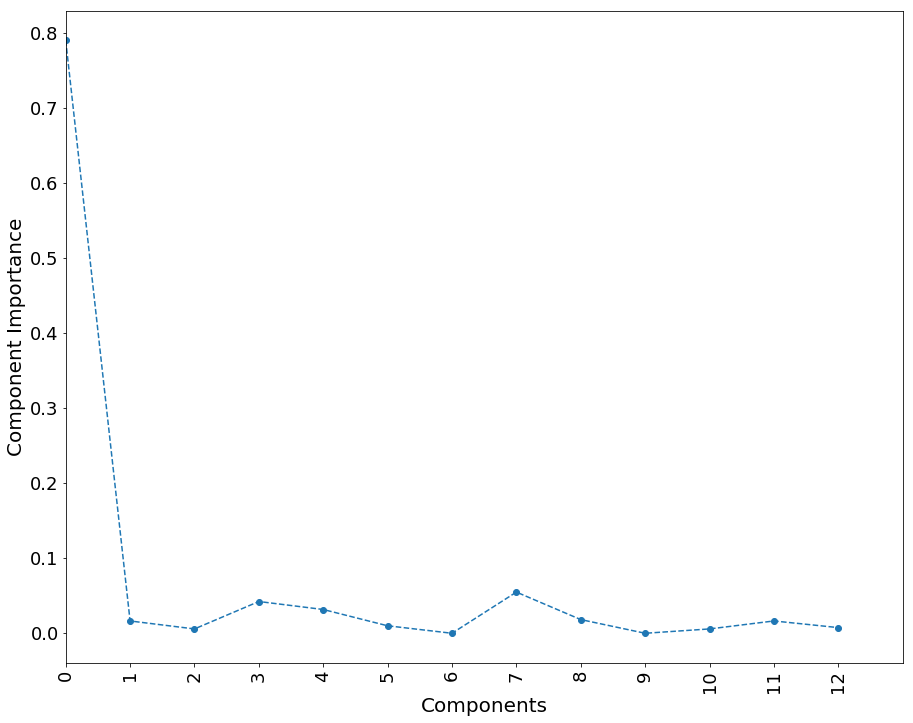

In [376]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [377]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.05  deviance                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1            50             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.803915922833

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1367   399     1766
1           282  1425     1707
__all__    1649  1824     3473

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.787777031565

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          548  167      715
1          149  625      774
__all__    697  792     1489

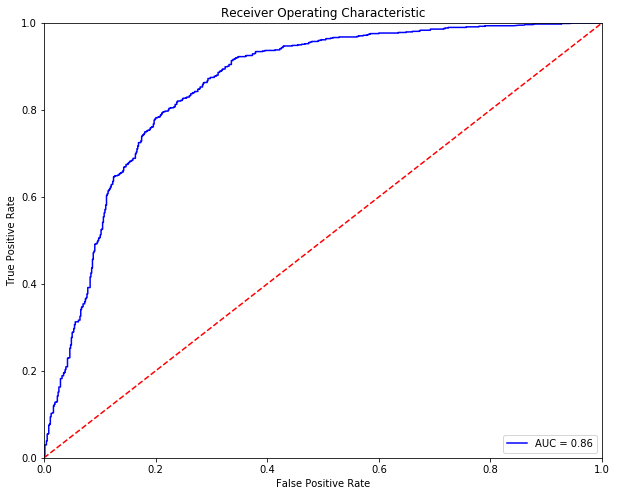

Optimal Threshold is 0.550661820578
Accuracy of Logistic Model on training data is: 0.789791806582


Predicted  0.0  1.0  __all__
Actual                      
0.0        565  150      715
1.0        163  611      774
__all__    728  761     1489

In [378]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [379]:
table_70_50_PCA_0_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_0_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_0_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

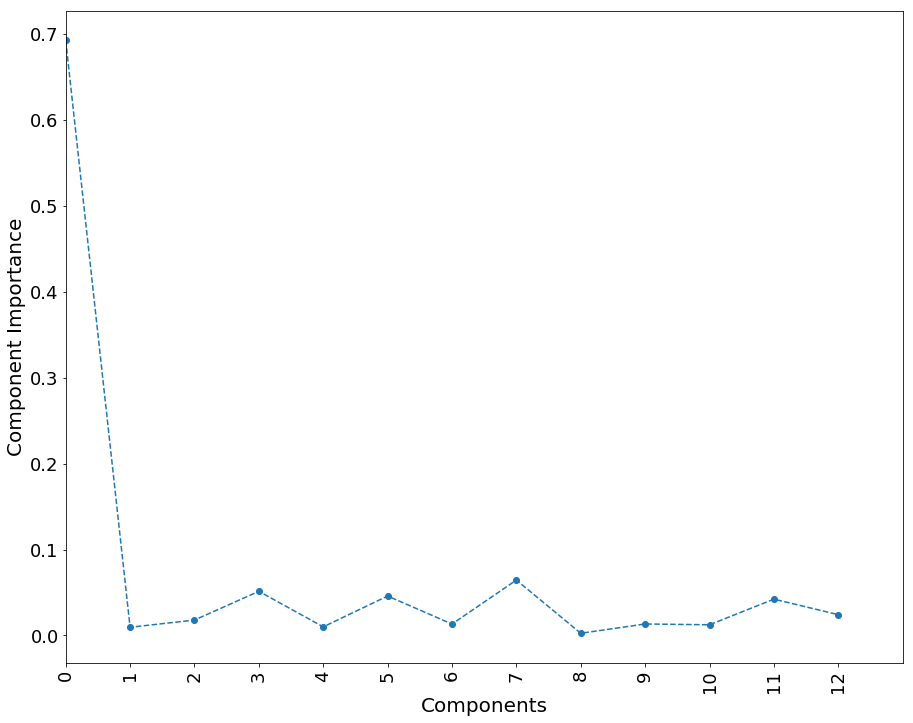

In [380]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [381]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  5             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.827526634034

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1428   338     1766
1           261  1446     1707
__all__    1689  1784     3473

Accuracy of the  Extra Decision Tree  model for test data is: 0.746138347884

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          524  191      715
1          187  587      774
__all__    711  778     1489

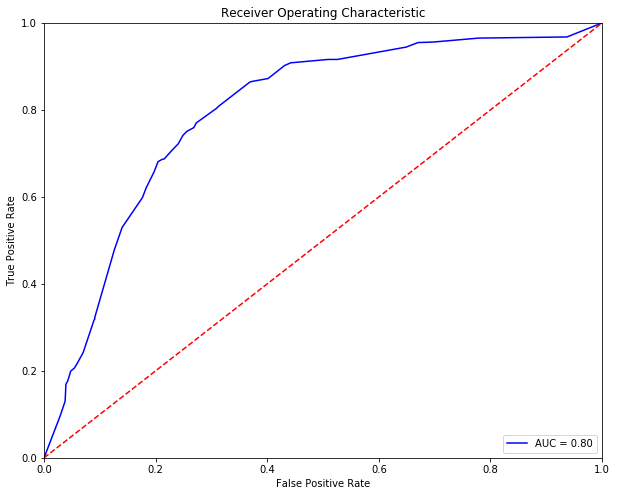

Optimal Threshold is 0.552631578947
Accuracy of Logistic Model on training data is: 0.746138347884


Predicted  0.0  1.0  __all__
Actual                      
0.0        537  178      715
1.0        200  574      774
__all__    737  752     1489

In [382]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [383]:
table_70_50_PCA_0_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_0_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [384]:
%%capture
table_70_50_PCA_0_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

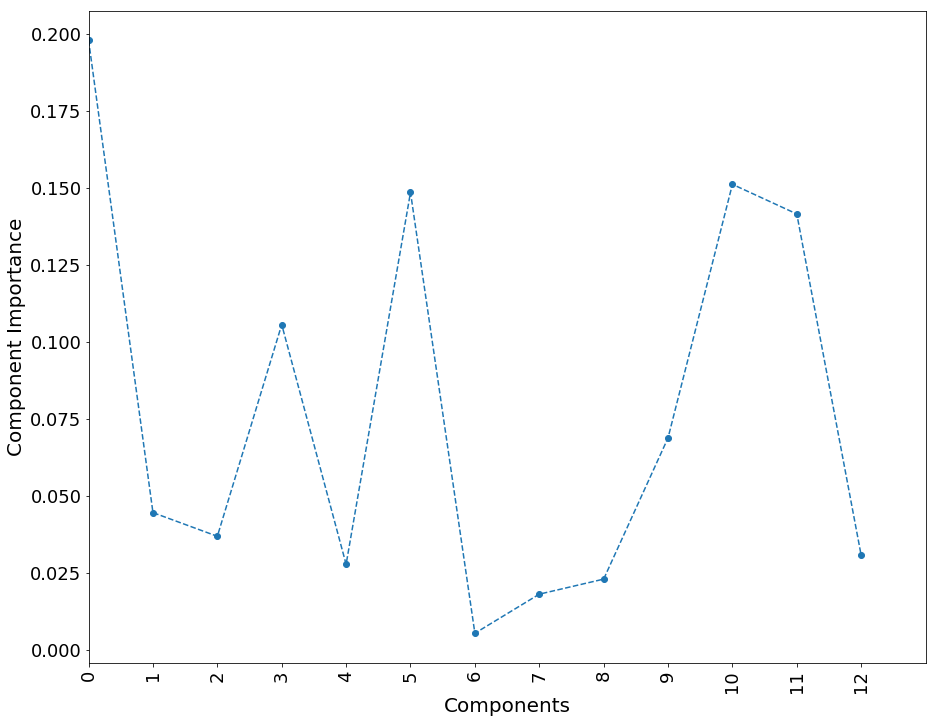

In [385]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [386]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.3           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.900662251656

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1529   237     1766
1           108  1599     1707
__all__    1637  1836     3473

Accuracy of the  Bagging  model for test data is: 0.787777031565

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          536  179      715
1          137  637      774
__all__    673  816     1489

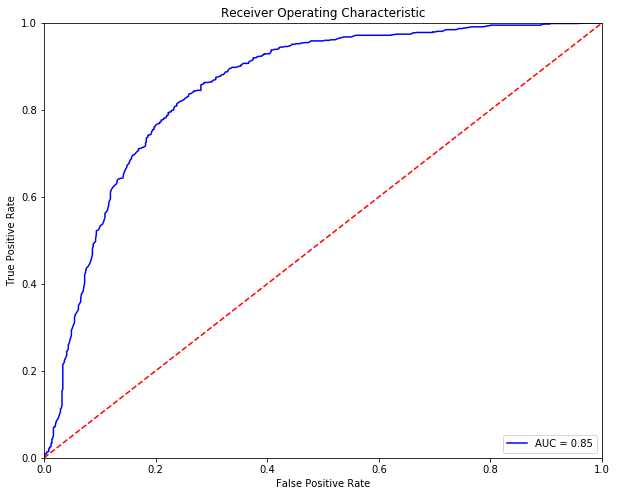

Optimal Threshold is 0.554
Accuracy of Logistic Model on training data is: 0.782404298187


Predicted  0.0  1.0  __all__
Actual                      
0.0        560  155      715
1.0        169  605      774
__all__    729  760     1489

In [387]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [388]:
table_70_50_PCA_0_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_0_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_0_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [389]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.936366253959


Predicted     0     1  __all__
Actual                        
0          1638   128     1766
1            93  1614     1707
__all__    1731  1742     3473

The test accuracy is: 0.779717931498


Predicted    0    1  __all__
Actual                      
0          552  163      715
1          165  609      774
__all__    717  772     1489

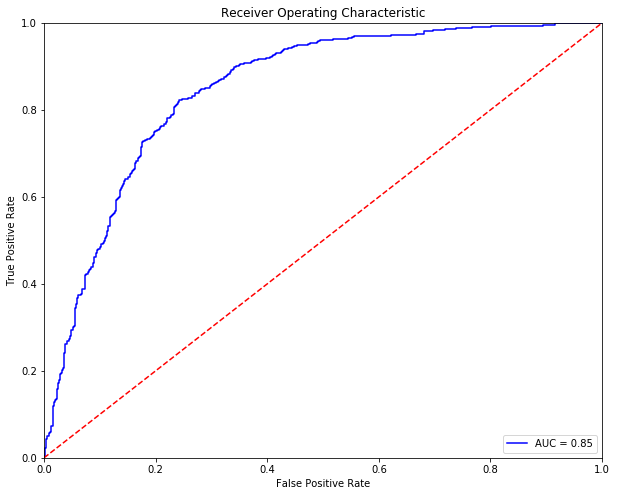

Optimal Threshold is 0.514240027515
Accuracy of Logistic Model on training data is: 0.778374748153


Predicted  0.0  1.0  __all__
Actual                      
0.0        558  157      715
1.0        173  601      774
__all__    731  758     1489

In [390]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [391]:
table_70_50_PCA_0_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_0_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_0_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [392]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.844802764249


Predicted     0     1  __all__
Actual                        
0          1410   356     1766
1           183  1524     1707
__all__    1593  1880     3473

The accuracy of the model on test data is: 0.776359973136


Predicted    0    1  __all__
Actual                      
0          530  185      715
1          148  626      774
__all__    678  811     1489

1408/1489 [===========================>..] - ETA: 0s

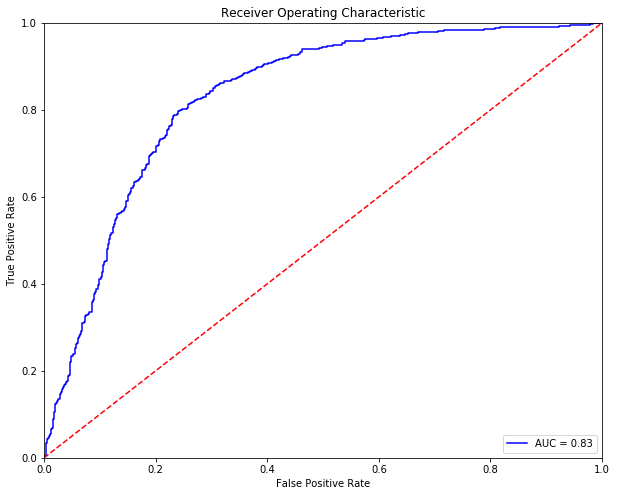

Optimal Threshold is 0.561501
Accuracy of Logistic Model on training data is: 0.768972464741


Predicted  0.0  1.0  __all__
Actual                      
0.0        552  163      715
1.0        181  593      774
__all__    733  756     1489

In [393]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [394]:
table_70_50_PCA_0_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_0_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_0_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [395]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.6min finished


The accuracy of the model on training data is: 0.807371148863


Predicted     0     1  __all__
Actual                        
0          1404   362     1766
1           307  1400     1707
__all__    1711  1762     3473

The accuracy of the model on test data is: 0.790463398254


Predicted    0    1  __all__
Actual                      
0          557  158      715
1          154  620      774
__all__    711  778     1489

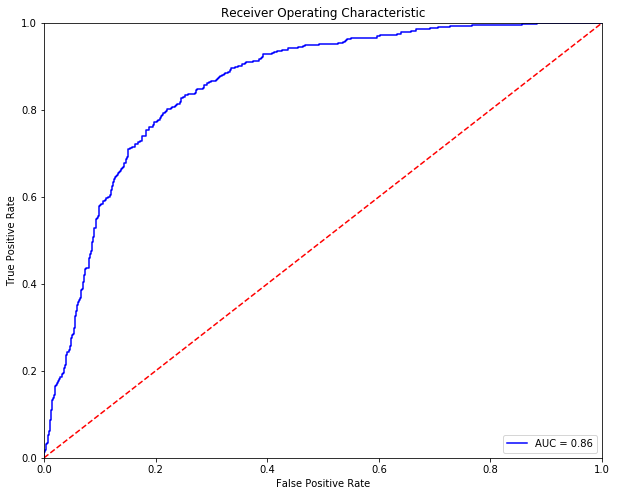

Optimal Threshold is 0.521603
Accuracy of Logistic Model on training data is: 0.788448623237


Predicted  0.0  1.0  __all__
Actual                      
0.0        564  151      715
1.0        164  610      774
__all__    728  761     1489

In [396]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [397]:
table_70_50_PCA_0_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_0_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_0_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [398]:
table_70_50_PCA_0_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_PCA_0_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_PCA_0_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_50_PCA_0_test.set_index(['index'],drop=True,inplace=True)
table_70_50_PCA_0_train.set_index(['index'],drop=True,inplace=True)
table_70_50_PCA_0_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_50_PCA_0_train)

print("Comparision Table for Test Accuracies:")
display(table_70_50_PCA_0_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_50_PCA_0_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1707.0  1766.0    0.0    0.0  0.000000   
LogisticRegression          0.796142  1354.0  1411.0  355.0  353.0  0.201019   
RandomForestClassifier      0.796142  1455.0  1310.0  456.0  252.0  0.258211   
AdaBoostClassifier          0.801325  1448.0  1335.0  431.0  259.0  0.244054   
GradientBoostingClassifier  0.803916  1425.0  1367.0  399.0  282.0  0.225934   
ExtraTreeClassifier         0.827527  1446.0  1428.0  338.0  261.0  0.191393   
BaggingClassifier           0.900662  1599.0  1529.0  237.0  108.0  0.134202   
VotingClassifier            0.936366  1614.0  1638.0  128.0   93.0  0.072480   
Neural Network-1            0.844803  1524.0  1410.0  356.0  183.0  0.201586   
Neural-Network-2            0.807371  1400.0  1404.0  362.0  307.0  0.204983   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.206796  
RandomForestClassifier      0.147627  
AdaBoostClassifier          0.151728  
GradientBoostingClassifier  0.165202  
ExtraTreeClassifier         0.152900  
BaggingClassifier           0.063269  
VotingClassifier            0.054482  
Neural Network-1            0.107206  
Neural-Network-2            0.179848

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.770987  582.0  566.0  149.0  192.0  0.208392   
LogisticRegression          0.781061  588.0  575.0  140.0  186.0  0.195804   
RandomForestClassifier      0.788449  651.0  523.0  192.0  123.0  0.268531   
AdaBoostClassifier          0.785091  640.0  529.0  186.0  134.0  0.260140   
GradientBoostingClassifier  0.787777  625.0  548.0  167.0  149.0  0.233566   
ExtraTreeClassifier         0.746138  587.0  524.0  191.0  187.0  0.267133   
BaggingClassifier           0.787777  637.0  536.0  179.0  137.0  0.250350   
VotingClassifier            0.779718  609.0  552.0  163.0  165.0  0.227972   
Neural Network-1            0.776360  626.0  530.0  185.0  148.0  0.258741   
Neural-Network-2            0.790463  620.0  557.0  158.0  154.0  0.220979   

                                 FNR  
index                                 
KNeighborsClassifier        0.248062  
LogisticRegression          0.240310  
RandomForestClassifier      0.158915  
AdaBoostClassifier          0.173127  
GradientBoostingClassifier  0.192506  
ExtraTreeClassifier         0.241602  
BaggingClassifier           0.177003  
VotingClassifier            0.213178  
Neural Network-1            0.191214  
Neural-Network-2            0.198966

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.770987  596.0  552.0  163.0  178.0  0.227972   
LogisticRegression          0.786434  608.0  563.0  152.0  166.0  0.212587   
RandomForestClassifier      0.785762  604.0  566.0  149.0  170.0  0.208392   
AdaBoostClassifier          0.787777  609.0  564.0  151.0  165.0  0.211189   
GradientBoostingClassifier  0.789792  611.0  565.0  150.0  163.0  0.209790   
ExtraTreeClassifier         0.746138  574.0  537.0  178.0  200.0  0.248951   
BaggingClassifier           0.782404  605.0  560.0  155.0  169.0  0.216783   
VotingClassifier            0.778375  601.0  558.0  157.0  173.0  0.219580   
Neural Network-1            0.768972  593.0  552.0  163.0  181.0  0.227972   
Neural-Network-2            0.788449  610.0  564.0  151.0  164.0  0.211189   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.229974   0.462405  0.838200  
LogisticRegression          0.214470   0.485599  0.857592  
RandomForestClassifier      0.219638   0.539883  0.831408  
AdaBoostClassifier          0.213178   0.507430  0.853313  
GradientBoostingClassifier  0.210594   0.550662  0.855793  
ExtraTreeClassifier         0.258398   0.552632  0.797075  
BaggingClassifier           0.218346   0.554000  0.852670  
VotingClassifier            0.223514   0.514240  0.848687  
Neural Network-1            0.233850   0.561501  0.829958  
Neural-Network-2            0.211886   0.521603  0.856732

#### Random State 10

In [399]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...   558  87.706093   
384ed706777916e315308d41eb2efc086edc768b6392e14...     3  29.333333   

                                                          PAS         LEN  \
Source_User                                                                 
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  25.094982  106.747312   
384ed706777916e315308d41eb2efc086edc768b6392e14...  22.000000  363.000000   

                                                            BYS  \
Source_User                                                       
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  3436.492832   
384ed706777916e315308d41eb2efc086edc768b6392e14...  5405.333333   

                                                              BYR     SP  \
Source_User                                                                
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  103496.745520  539.0   
384ed706777916e315308d41eb2efc086edc768b6392e14...    3980.666667    3.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  20.0    42   47  230   
384ed706777916e315308d41eb2efc086edc768b6392e14...   1.0     2    1    2   

                                                           TDIF  0000  0100  \
Source_User                                                                   
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...  7309.743728     5     4   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0.000000     0     0   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     0     0     0     0   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     4    31    14     3   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     3   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     3     4    16    18   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...    20    74    81    71   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...   116    42    32    10   
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0     0     0   

                                                    2200  2300  
Source_User                                                     
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7...     4     6  
384ed706777916e315308d41eb2efc086edc768b6392e14...     0     0

1 -> Infected
0 -> Uninfected


Source_User
0d3fc59664e46c2fd425f7e198ccedc1faaffc4ae160fc7ec769d861466ae859    0
384ed706777916e315308d41eb2efc086edc768b6392e14751b4d9bca760a59e    0
25fbc1afa01f04686e25d7cffb238ca43ffeb865a4e6c1d07029f2fd8dcfcd32    1
b522e1c3ad002eddf9145e38f7f0a2be9c45895d718c7977e0a6a2a7becb3a10    1
8eba4debb95ef877faed7041269483166a3145a7a590cba966da0a5aa394f2f3    1
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
8389fdb8a5b9d6fff6c3eb065c2f0eeaeb6931647d7ff91de731a82a98c197c5    0
d0d0439bceb5f83d975bd909d12ad0f8a13766371c2a092a446febf0f7b08f5c    1
2587a851f09c2bb4d22b7daf8ec30af164ad94a7f5d1620d60d271b85fff6f64    1
841bc27abf403835526548adc7b881573c654cc78cb11b9e064c7b9682a89709    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.920248168257
The train/test split ratio is 70:30


In [400]:
display(X_pca_13[0:1])

array([[-0.60366038, -0.19722059, -0.1024411 ,  0.11967427, -0.22529615,
         0.43858517, -0.03586256, -0.03194002, -0.1733374 , -0.58586441,
         0.20730537, -0.25138831, -0.52451862]])

In [401]:
## Table to store training and test measures
table_70_50_PCA_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_PCA_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_PCA_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [402]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1743     0     1743
1             0  1730     1730
__all__    1743  1730     3473

Accuracy of the  KNN  model for test data is: 0.802552048355

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          605  133      738
1          161  590      751
__all__    766  723     1489

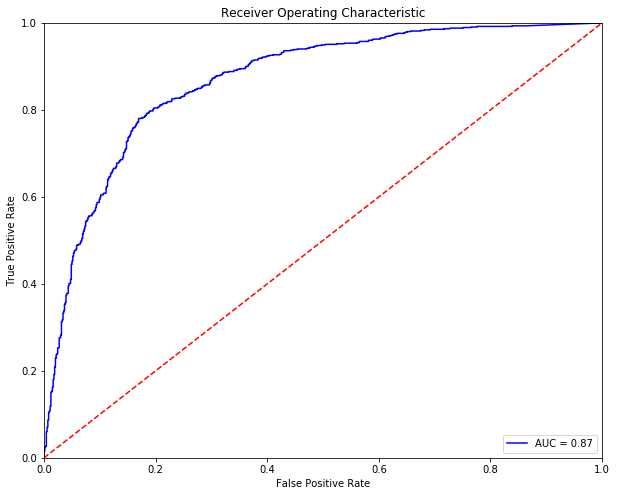

Optimal Threshold is 0.471353800556
Accuracy of Logistic Model on training data is: 0.803223640027


Predicted  0.0  1.0  __all__
Actual                      
0.0        593  145      738
1.0        148  603      751
__all__    741  748     1489

In [403]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [404]:
table_70_50_PCA_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [405]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.7        50  multinomial   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  1e-05

Accuracy of the  Logistic  model for the training data is: 0.790095018716

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1358   385     1743
1           344  1386     1730
__all__    1702  1771     3473

Accuracy of the  Logistic  model for test data is: 0.798522498321

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          588  150      738
1          150  601      751
__all__    738  751     1489

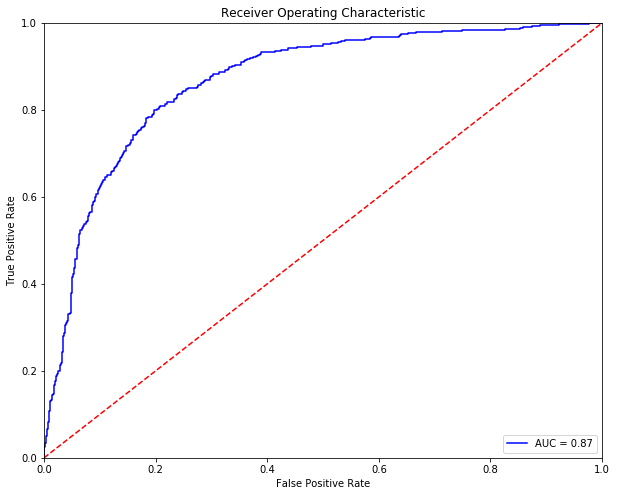

Optimal Threshold is 0.501965392565
Accuracy of Logistic Model on training data is: 0.798522498321


Predicted  0.0  1.0  __all__
Actual                      
0.0        589  149      738
1.0        151  600      751
__all__    740  749     1489

In [406]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [407]:
table_70_50_PCA_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [408]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0        entropy         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.793550244745

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1281   462     1743
1           255  1475     1730
__all__    1536  1937     3473

Accuracy of the  Random Forest Trees  model for test data is: 0.799194089993

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          549  189      738
1          110  641      751
__all__    659  830     1489

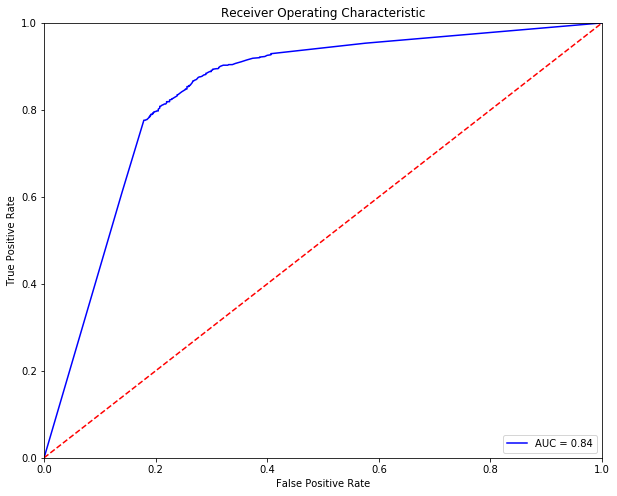

Optimal Threshold is 0.541529765076
Accuracy of Logistic Model on training data is: 0.797850906649


Predicted  0.0  1.0  __all__
Actual                      
0.0        590  148      738
1.0        153  598      751
__all__    743  746     1489

In [409]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [410]:
table_70_50_PCA_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

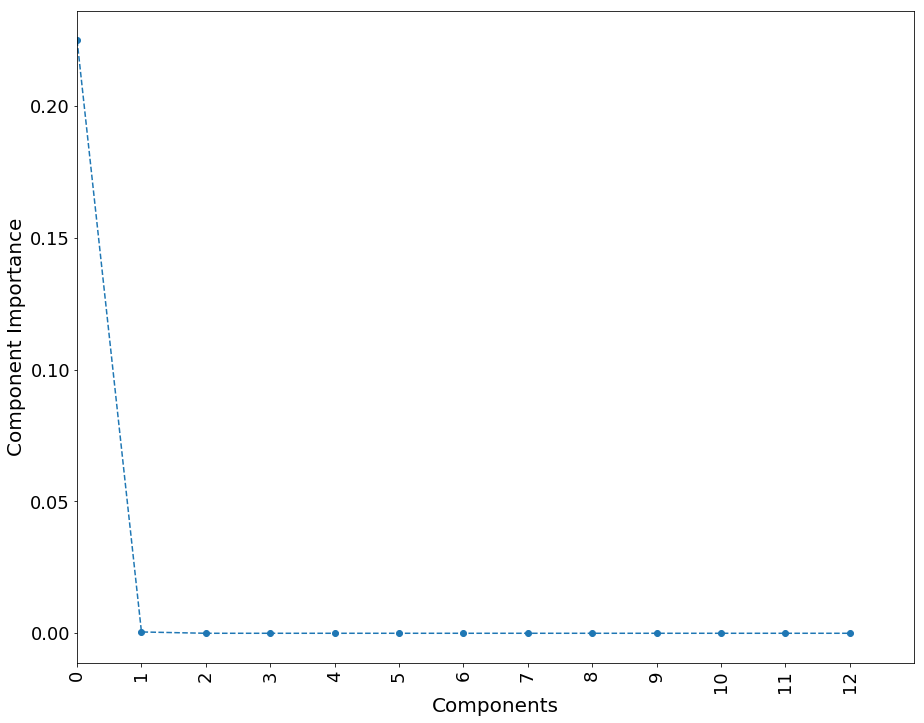

In [411]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [412]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            1.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.800172761301

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1353   390     1743
1           304  1426     1730
__all__    1657  1816     3473

Accuracy of the  AdaBoostClassifier  model for test data is: 0.794492948287

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          576  162      738
1          144  607      751
__all__    720  769     1489

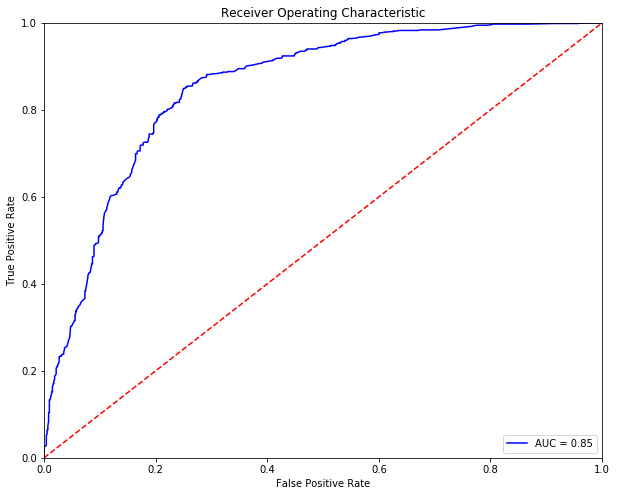

Optimal Threshold is 0.502400659815
Accuracy of Logistic Model on training data is: 0.789791806582


Predicted  0.0  1.0  __all__
Actual                      
0.0        584  154      738
1.0        159  592      751
__all__    743  746     1489

In [413]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [414]:
table_70_50_PCA_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

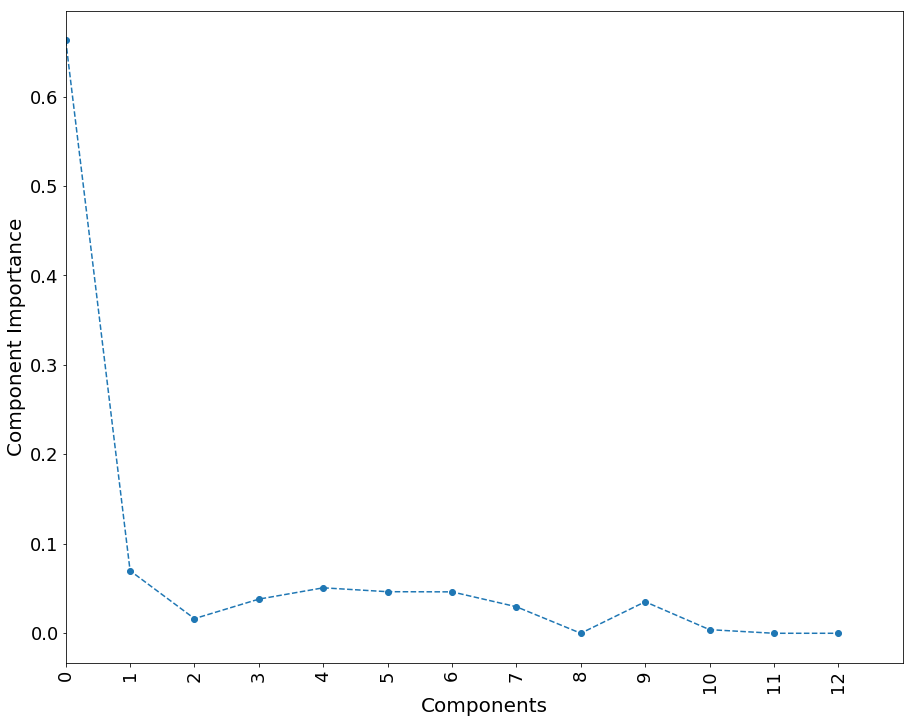

In [415]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [416]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1            50             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.804203858336

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1349   394     1743
1           286  1444     1730
__all__    1635  1838     3473

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.803895231699

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          575  163      738
1          129  622      751
__all__    704  785     1489

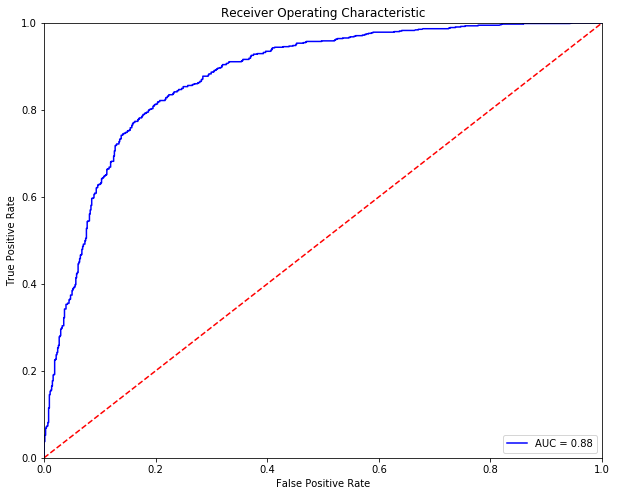

Optimal Threshold is 0.568319771093
Accuracy of Logistic Model on training data is: 0.804566823371


Predicted  0.0  1.0  __all__
Actual                      
0.0        595  143      738
1.0        148  603      751
__all__    743  746     1489

In [417]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [418]:
table_70_50_PCA_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

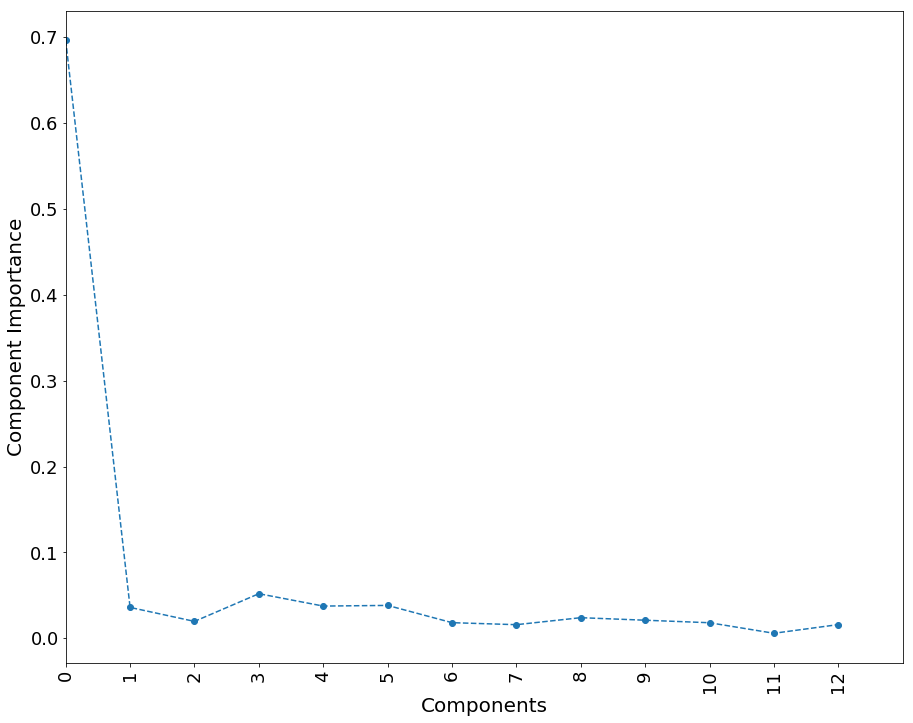

In [419]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [420]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.798733083789

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1260   483     1743
1           216  1514     1730
__all__    1476  1997     3473

Accuracy of the  Extra Decision Tree  model for test data is: 0.795836131632

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          536  202      738
1          102  649      751
__all__    638  851     1489

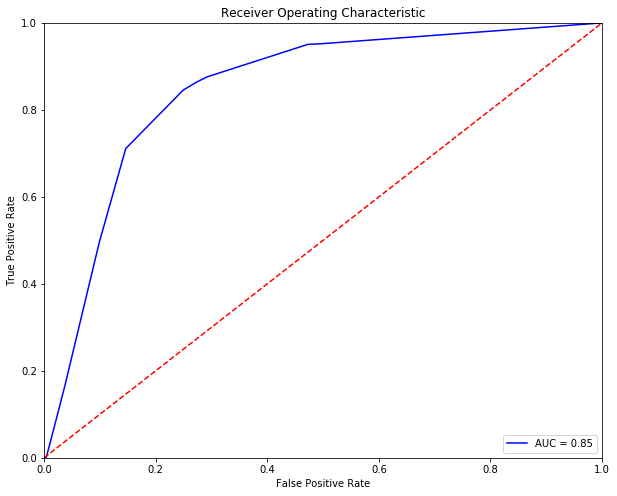

Optimal Threshold is 0.558139534884
Accuracy of Logistic Model on training data is: 0.781732706514


Predicted  0.0  1.0  __all__
Actual                      
0.0        630  108      738
1.0        217  534      751
__all__    847  642     1489

In [421]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [422]:
table_70_50_PCA_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [423]:
%%capture
table_70_50_PCA_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

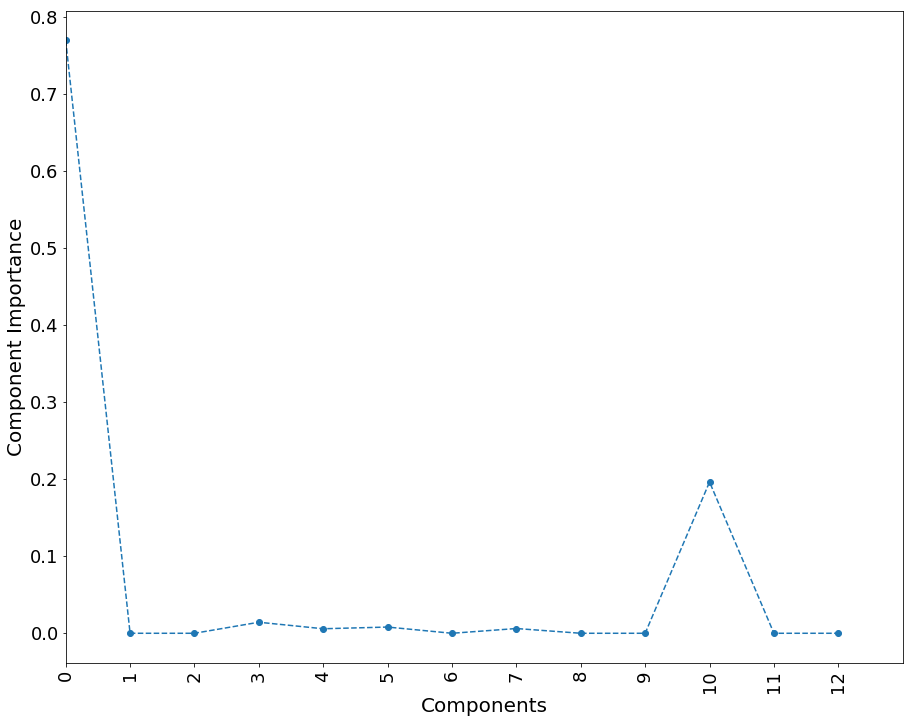

In [424]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [425]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.6          1500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.995680967463

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1740     3     1743
1            12  1718     1730
__all__    1752  1721     3473

Accuracy of the  Bagging  model for test data is: 0.792478173271

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          538  200      738
1          109  642      751
__all__    647  842     1489

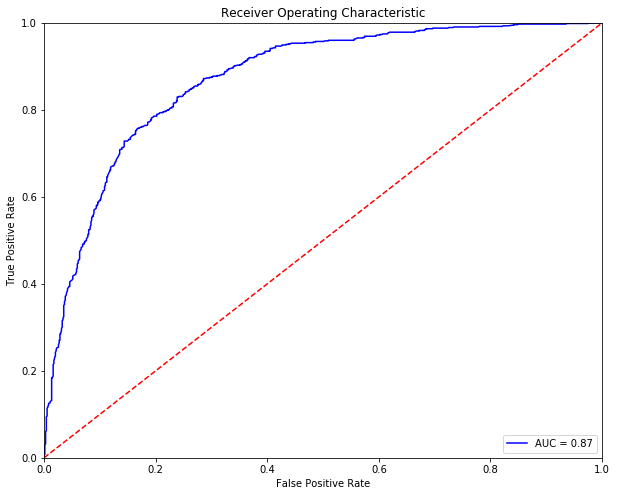

Optimal Threshold is 0.567333333333
Accuracy of Logistic Model on training data is: 0.792478173271


Predicted  0.0  1.0  __all__
Actual                      
0.0        586  152      738
1.0        157  594      751
__all__    743  746     1489

In [426]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [427]:
table_70_50_PCA_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [428]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.93060754391


Predicted     0     1  __all__
Actual                        
0          1602   141     1743
1           100  1630     1730
__all__    1702  1771     3473

The test accuracy is: 0.803223640027


Predicted    0    1  __all__
Actual                      
0          584  154      738
1          139  612      751
__all__    723  766     1489

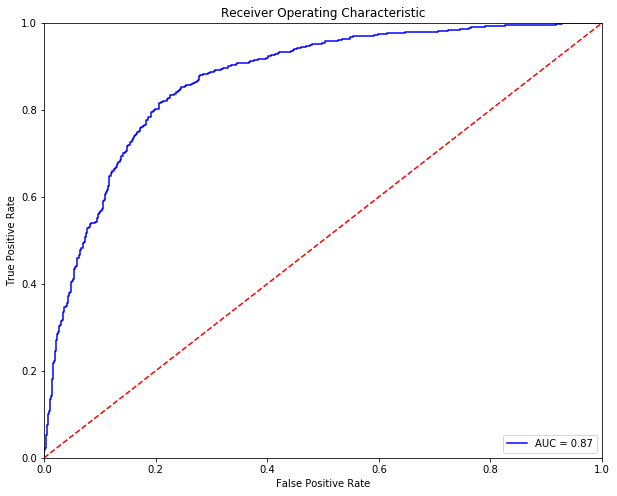

Optimal Threshold is 0.512448878288
Accuracy of Logistic Model on training data is: 0.800537273338


Predicted  0.0  1.0  __all__
Actual                      
0.0        591  147      738
1.0        150  601      751
__all__    741  748     1489

In [429]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [430]:
table_70_50_PCA_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [431]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.854304635796


Predicted     0     1  __all__
Actual                        
0          1428   315     1743
1           191  1539     1730
__all__    1619  1854     3473

The accuracy of the model on test data is: 0.772330423103


Predicted    0    1  __all__
Actual                      
0          541  197      738
1          142  609      751
__all__    683  806     1489

1056/1489 [====================>.........] - ETA: 0s

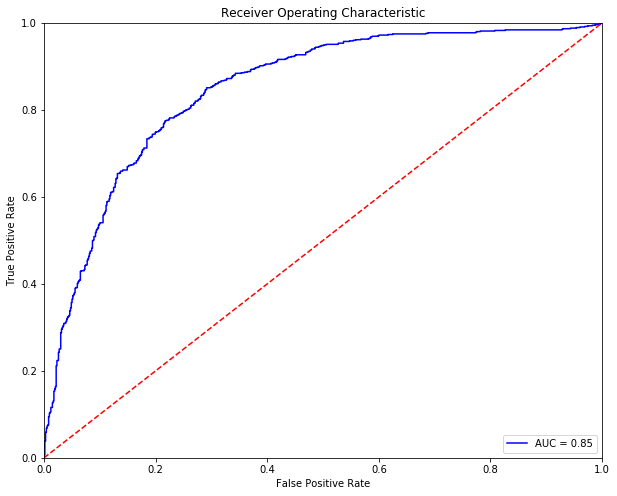

Optimal Threshold is 0.577296
Accuracy of Logistic Model on training data is: 0.777031564809


Predicted  0.0  1.0  __all__
Actual                      
0.0        574  164      738
1.0        168  583      751
__all__    742  747     1489

In [432]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [433]:
table_70_50_PCA_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [434]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.0min finished


The accuracy of the model on training data is: 0.81053843939


Predicted     0     1  __all__
Actual                        
0          1356   387     1743
1           271  1459     1730
__all__    1627  1846     3473

The accuracy of the model on test data is: 0.798522498321


Predicted    0    1  __all__
Actual                      
0          576  162      738
1          138  613      751
__all__    714  775     1489

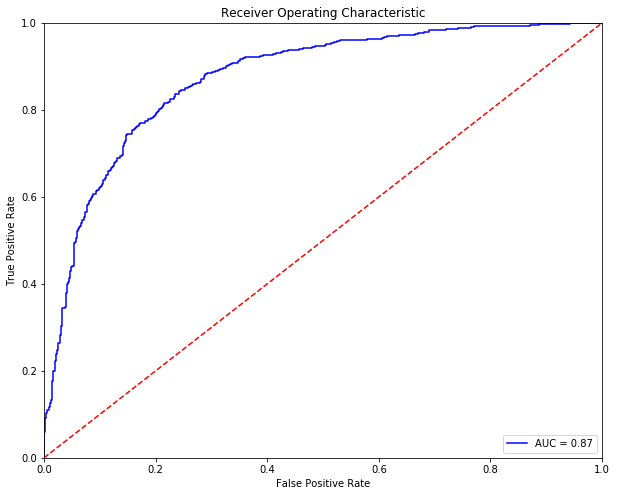

Optimal Threshold is 0.550975
Accuracy of Logistic Model on training data is: 0.795836131632


Predicted  0.0  1.0  __all__
Actual                      
0.0        588  150      738
1.0        154  597      751
__all__    742  747     1489

In [435]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [436]:
table_70_50_PCA_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [437]:
table_70_50_PCA_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_PCA_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_PCA_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_50_PCA_10_test.set_index(['index'],drop=True,inplace=True)
table_70_50_PCA_10_train.set_index(['index'],drop=True,inplace=True)
table_70_50_PCA_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_50_PCA_10_train)

print("Comparision Table for Test Accuracies:")
display(table_70_50_PCA_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_50_PCA_10_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1730.0  1743.0    0.0    0.0  0.000000   
LogisticRegression          0.790095  1386.0  1358.0  385.0  344.0  0.220884   
RandomForestClassifier      0.793550  1475.0  1281.0  462.0  255.0  0.265060   
AdaBoostClassifier          0.800173  1426.0  1353.0  390.0  304.0  0.223752   
GradientBoostingClassifier  0.804204  1444.0  1349.0  394.0  286.0  0.226047   
ExtraTreeClassifier         0.798733  1514.0  1260.0  483.0  216.0  0.277108   
BaggingClassifier           0.995681  1718.0  1740.0    3.0   12.0  0.001721   
VotingClassifier            0.930608  1630.0  1602.0  141.0  100.0  0.080895   
Neural Network-1            0.854305  1539.0  1428.0  315.0  191.0  0.180723   
Neural-Network-2            0.810538  1459.0  1356.0  387.0  271.0  0.222031   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.198844  
RandomForestClassifier      0.147399  
AdaBoostClassifier          0.175723  
GradientBoostingClassifier  0.165318  
ExtraTreeClassifier         0.124855  
BaggingClassifier           0.006936  
VotingClassifier            0.057803  
Neural Network-1            0.110405  
Neural-Network-2            0.156647

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.802552  590.0  605.0  133.0  161.0  0.180217   
LogisticRegression          0.798522  601.0  588.0  150.0  150.0  0.203252   
RandomForestClassifier      0.799194  641.0  549.0  189.0  110.0  0.256098   
AdaBoostClassifier          0.794493  607.0  576.0  162.0  144.0  0.219512   
GradientBoostingClassifier  0.803895  622.0  575.0  163.0  129.0  0.220867   
ExtraTreeClassifier         0.795836  649.0  536.0  202.0  102.0  0.273713   
BaggingClassifier           0.792478  642.0  538.0  200.0  109.0  0.271003   
VotingClassifier            0.803224  612.0  584.0  154.0  139.0  0.208672   
Neural Network-1            0.772330  609.0  541.0  197.0  142.0  0.266938   
Neural-Network-2            0.798522  613.0  576.0  162.0  138.0  0.219512   

                                 FNR  
index                                 
KNeighborsClassifier        0.214381  
LogisticRegression          0.199734  
RandomForestClassifier      0.146471  
AdaBoostClassifier          0.191744  
GradientBoostingClassifier  0.171771  
ExtraTreeClassifier         0.135819  
BaggingClassifier           0.145140  
VotingClassifier            0.185087  
Neural Network-1            0.189081  
Neural-Network-2            0.183755

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.803224  603.0  593.0  145.0  148.0  0.196477   
LogisticRegression          0.798522  600.0  589.0  149.0  151.0  0.201897   
RandomForestClassifier      0.797851  598.0  590.0  148.0  153.0  0.200542   
AdaBoostClassifier          0.789792  592.0  584.0  154.0  159.0  0.208672   
GradientBoostingClassifier  0.804567  603.0  595.0  143.0  148.0  0.193767   
ExtraTreeClassifier         0.781733  534.0  630.0  108.0  217.0  0.146341   
BaggingClassifier           0.792478  594.0  586.0  152.0  157.0  0.205962   
VotingClassifier            0.800537  601.0  591.0  147.0  150.0  0.199187   
Neural Network-1            0.777032  583.0  574.0  164.0  168.0  0.222222   
Neural-Network-2            0.795836  597.0  588.0  150.0  154.0  0.203252   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.197071   0.471354  0.868140  
LogisticRegression          0.201065   0.501965  0.866814  
RandomForestClassifier      0.203728   0.541530  0.841611  
AdaBoostClassifier          0.211718   0.502401  0.853780  
GradientBoostingClassifier  0.197071   0.568320  0.876488  
ExtraTreeClassifier         0.288948   0.558140  0.847766  
BaggingClassifier           0.209055   0.567333  0.870795  
VotingClassifier            0.199734   0.512449  0.869589  
Neural Network-1            0.223702   0.577296  0.847896  
Neural-Network-2            0.205060   0.550975  0.873091

#### Random State 20

In [438]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_50_50_2_27_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    2481
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  3728  132.185891   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...    81   31.061728   

                                                           PAS         LEN  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  103.969421  135.190987   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...   25.246914  109.395062   

                                                            BYS  \
Source_User                                                       
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  8652.968348   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...  3871.506173   

                                                              BYR      SP  \
Source_User                                                                 
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  178992.604882  3096.0   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...   17973.666667    80.0   

                                                       DP  NAPP  SIP  DIP  \
Source_User                                                                 
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...  264.0    44  114  784   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...    3.0    10   12   28   

                                                            TDIF  0000  0100  \
Source_User                                                                    
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   2041.380633    72    81   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...  88488.987654     1     0   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   115   106   131   116   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0     0   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   100   355   279   152   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0     0   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   196   153   135   443   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     0     0    10   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   243   195   185   132   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     0     1    25    32   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...   152   107    90   107   
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     2     8     0     0   

                                                    2200  2300  
Source_User                                                     
1da09acf8ddc082a297329856e8512e0aa25eef1650894f...    38    45  
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8d...     2     0

1 -> Infected
0 -> Uninfected


Source_User
1da09acf8ddc082a297329856e8512e0aa25eef1650894f3e39d24006b3b9900    1
24bcdf55cc1168a34c9d7534d7fb24500219538e85f2b8ddc3d1beabef89096b    0
c7ae13801caa67d372db28e31fe24146a34866c75fdaa7a8f3dd2e52c8feadbf    0
d7a31b1f8a1b6229ffc4f3d615d4847d8844645ed5bc9d4f016352ccde33eeef    0
2e8858be6011eed9b63eb701eda4575a43151dcedbd12b1e87e9707f1355e52d    1
aef14742e536c93ce48a00a70bc5c429ff5973e95f029488785eeda1778ea086    1
0930d98b6033a246eaecdf425d4fe74341a505bb2ffb83a09d4e489b29dea307    1
3f716f2fcc54a3eac07cc68af79773e6e32cc680c5f1b1e44ad527af39210d58    1
655f71c7531f608b3aa19880786cc023e26286b3bef2ad9917e379ddcead4e43    1
5957761ffa31d8e6cf65bb4540565c1ebd6e030e40b744a5c21d4d4b7c0d7d63    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.92323693469
The train/test split ratio is 70:30


In [439]:
display(X_pca_13[0:1])

array([[ 0.13373123, -0.0019507 , -0.36419166, -1.2822501 , -0.46750246,
         0.64125319, -0.49135909, -0.99415923,  0.95652515,  0.62057691,
        -0.11989609, -1.23106676,  1.65652418]])

In [440]:
## Table to store training and test measures
table_70_50_PCA_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_PCA_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_PCA_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [441]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           20  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1698     0     1698
1             0  1775     1775
__all__    1698  1775     3473

Accuracy of the  KNN  model for test data is: 0.760241773002

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          593  190      783
1          167  539      706
__all__    760  729     1489

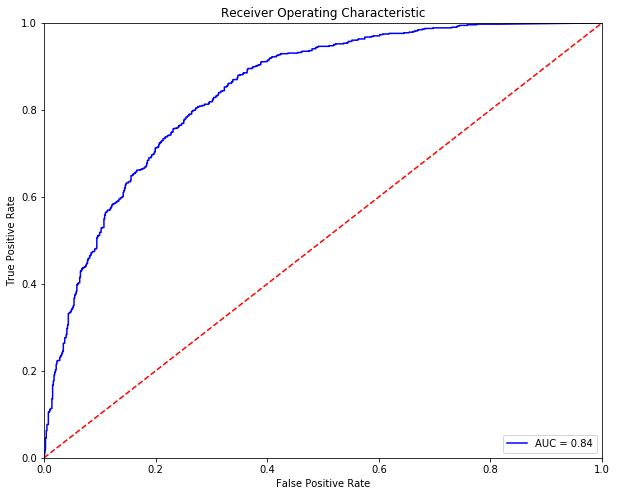

Optimal Threshold is 0.502844242003
Accuracy of Logistic Model on training data is: 0.760241773002


Predicted  0.0  1.0  __all__
Actual                      
0.0        596  187      783
1.0        170  536      706
__all__    766  723     1489

In [442]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [443]:
table_70_50_PCA_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [444]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.3  False           True                0.5       100  multinomial   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.787215663691

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1341   357     1698
1           382  1393     1775
__all__    1723  1750     3473

Accuracy of the  Logistic  model for test data is: 0.767629281397

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          591  192      783
1          154  552      706
__all__    745  744     1489

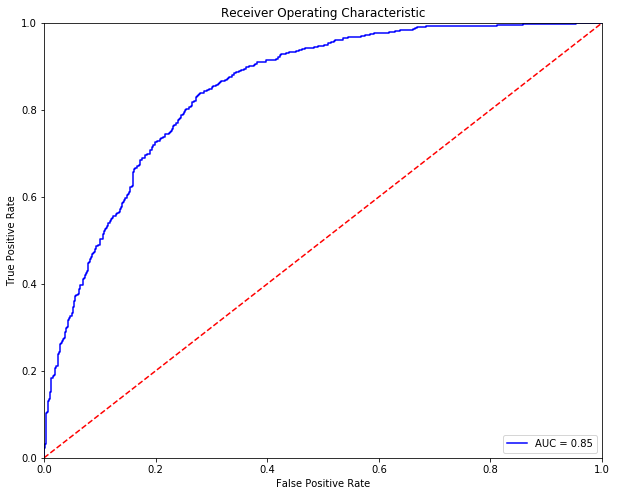

Optimal Threshold is 0.51191776967
Accuracy of Logistic Model on training data is: 0.764942914708


Predicted  0.0  1.0  __all__
Actual                      
0.0        599  184      783
1.0        166  540      706
__all__    765  724     1489

In [445]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [446]:
table_70_50_PCA_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [447]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0        entropy         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.790958825223

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1228   470     1698
1           256  1519     1775
__all__    1484  1989     3473

Accuracy of the  Random Forest Trees  model for test data is: 0.773002014775

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          554  229      783
1          109  597      706
__all__    663  826     1489

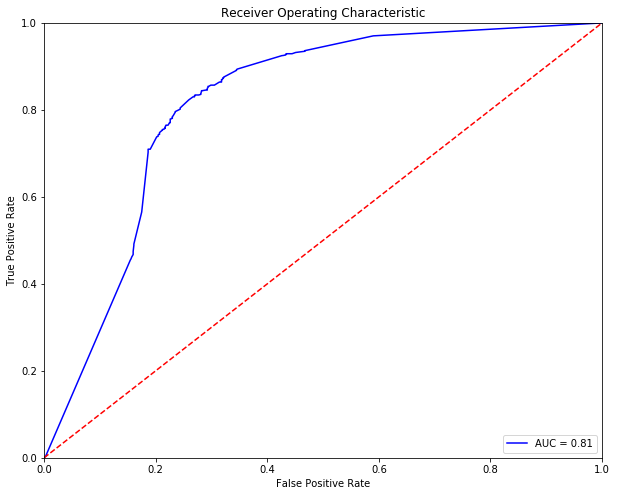

Optimal Threshold is 0.537980996589
Accuracy of Logistic Model on training data is: 0.773002014775


Predicted  0.0  1.0  __all__
Actual                      
0.0        606  177      783
1.0        161  545      706
__all__    767  722     1489

In [448]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [449]:
table_70_50_PCA_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

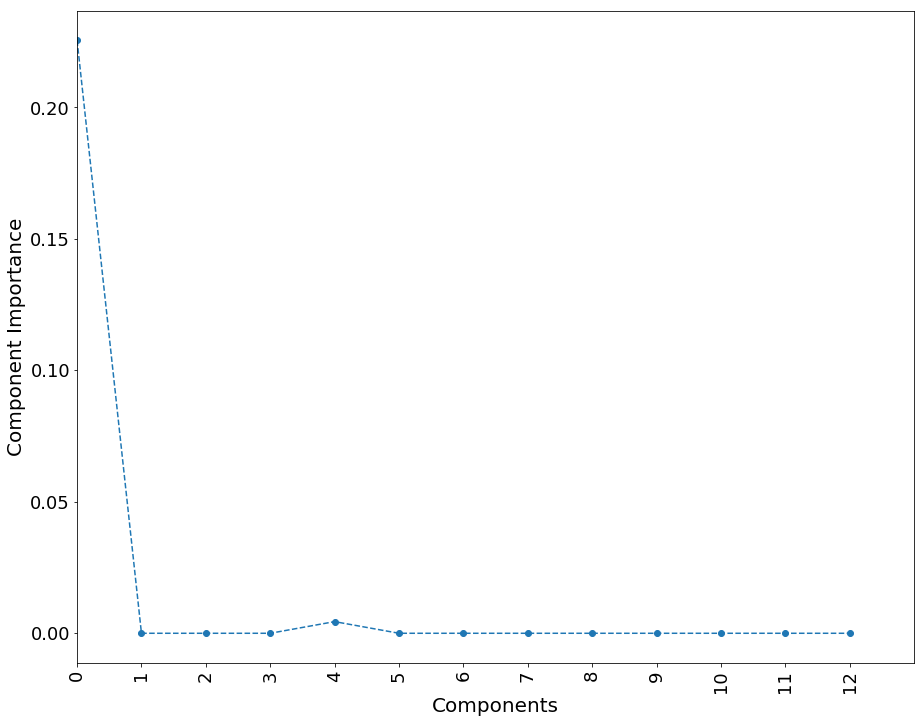

In [450]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [451]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.800460696804

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1271   427     1698
1           266  1509     1775
__all__    1537  1936     3473

Accuracy of the  AdaBoostClassifier  model for test data is: 0.779717931498

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          575  208      783
1          120  586      706
__all__    695  794     1489

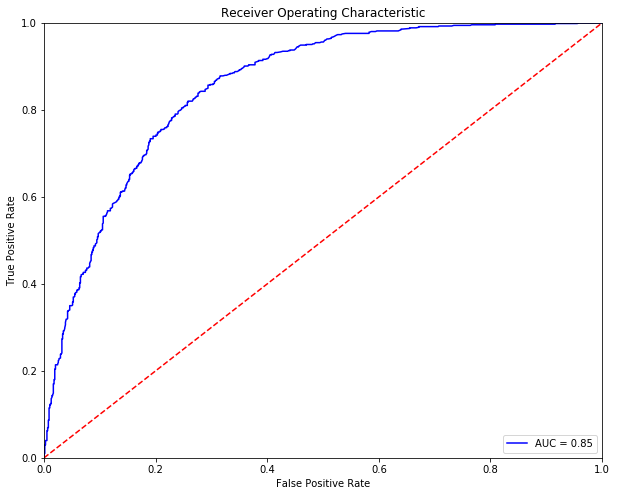

Optimal Threshold is 0.506526246645
Accuracy of Logistic Model on training data is: 0.77434519812


Predicted  0.0  1.0  __all__
Actual                      
0.0        607  176      783
1.0        160  546      706
__all__    767  722     1489

In [452]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [453]:
table_70_50_PCA_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

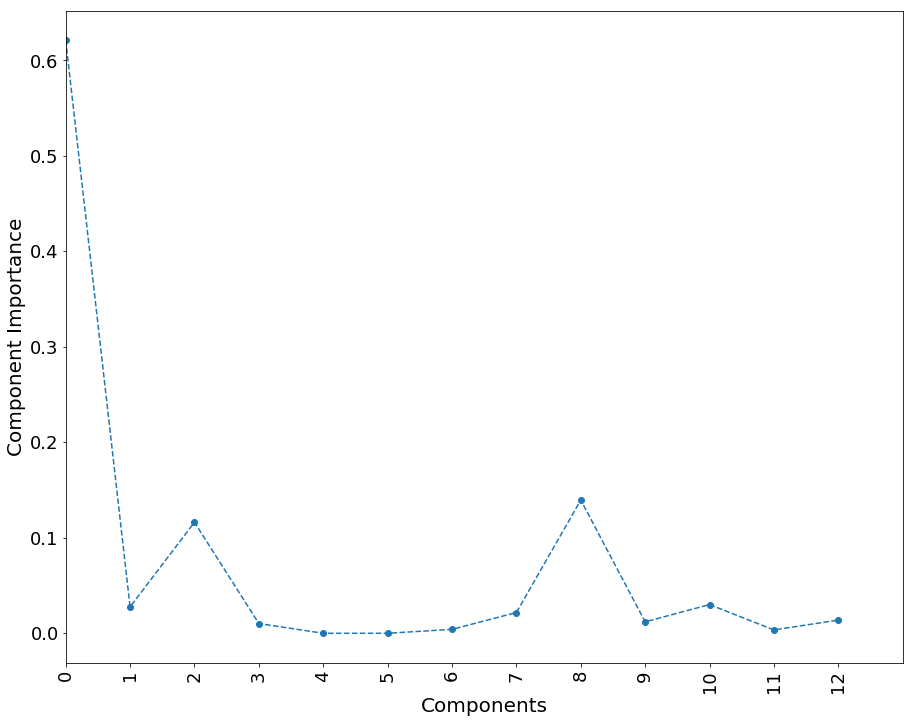

In [454]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [455]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.03  exponential                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           100             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.80823495537

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1326   372     1698
1           294  1481     1775
__all__    1620  1853     3473

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.775016789792

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          588  195      783
1          140  566      706
__all__    728  761     1489

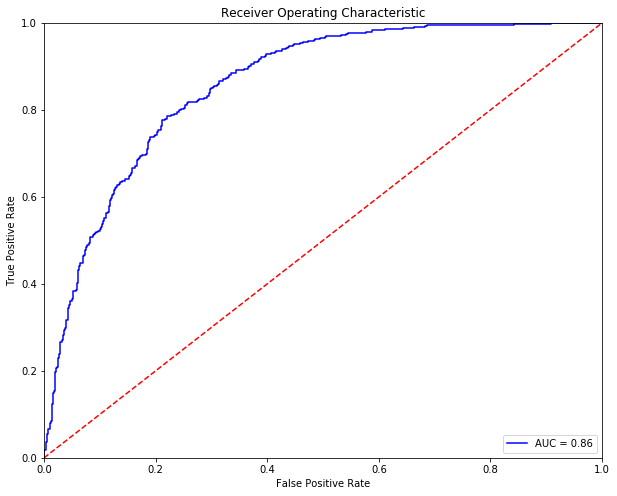

Optimal Threshold is 0.56917474834
Accuracy of Logistic Model on training data is: 0.78038952317


Predicted  0.0  1.0  __all__
Actual                      
0.0        612  171      783
1.0        156  550      706
__all__    768  721     1489

In [456]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [457]:
table_70_50_PCA_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

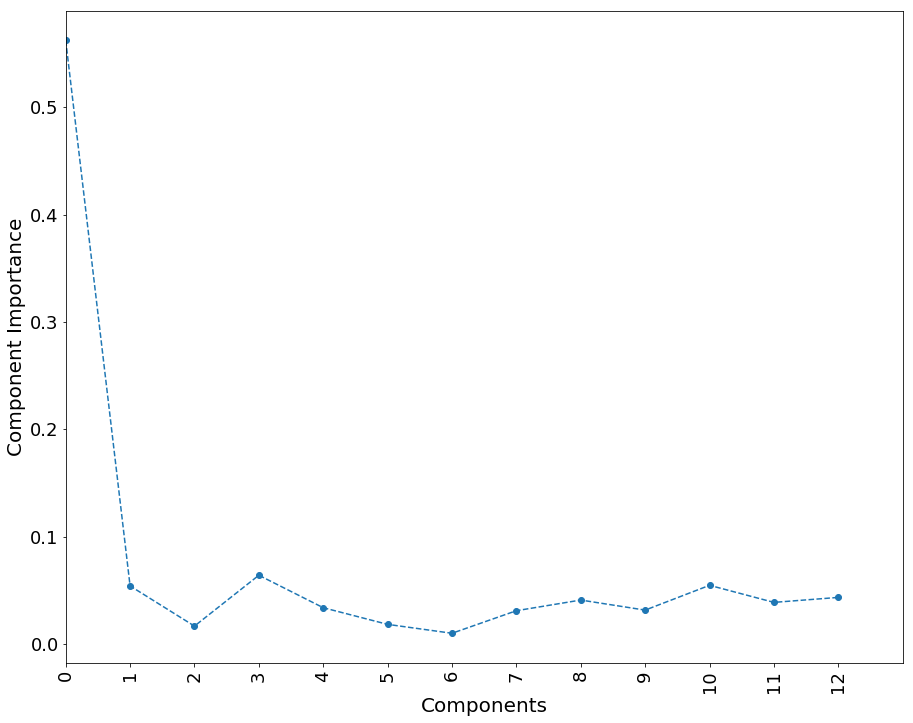

In [458]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [459]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         20          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     3                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.805355600346

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1368   330     1698
1           346  1429     1775
__all__    1714  1759     3473

Accuracy of the  Extra Decision Tree  model for test data is: 0.755540631296

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          593  190      783
1          174  532      706
__all__    767  722     1489

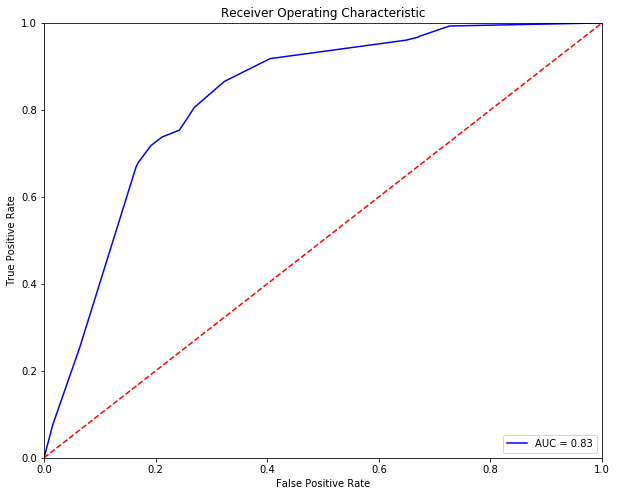

Optimal Threshold is 0.52
Accuracy of Logistic Model on training data is: 0.764271323036


Predicted  0.0  1.0  __all__
Actual                      
0.0        617  166      783
1.0        185  521      706
__all__    802  687     1489

In [460]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [461]:
table_70_50_PCA_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [462]:
%%capture
table_70_50_PCA_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

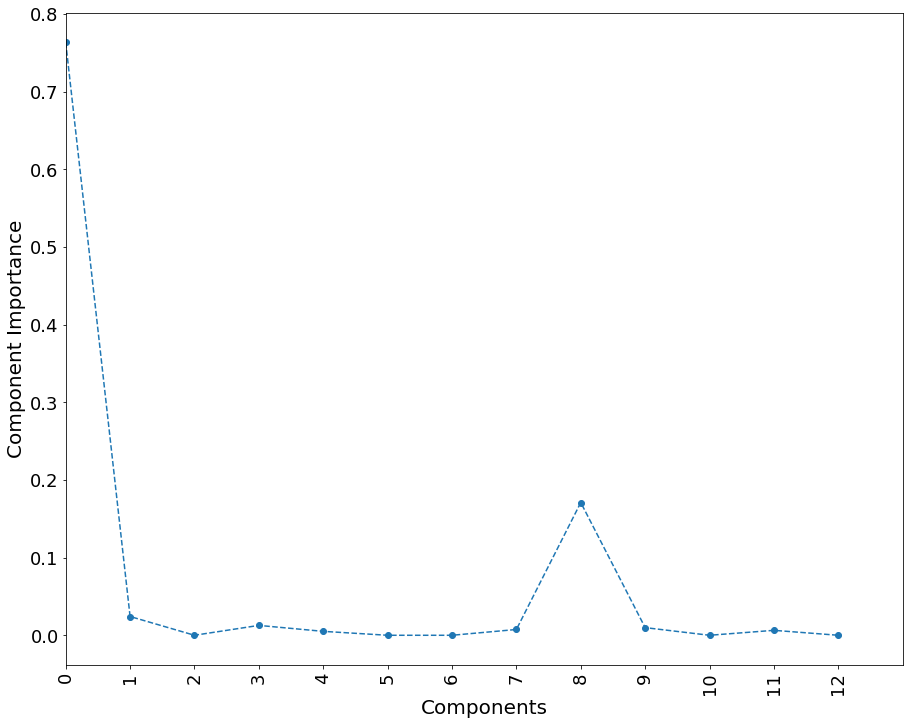

In [463]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [464]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.6          1000   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.996832709473

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          1697     1     1698
1            10  1765     1775
__all__    1707  1766     3473

Accuracy of the  Bagging  model for test data is: 0.77165883143

Confusion Matrix for test data is:


Predicted    0    1  __all__
Actual                      
0          571  212      783
1          128  578      706
__all__    699  790     1489

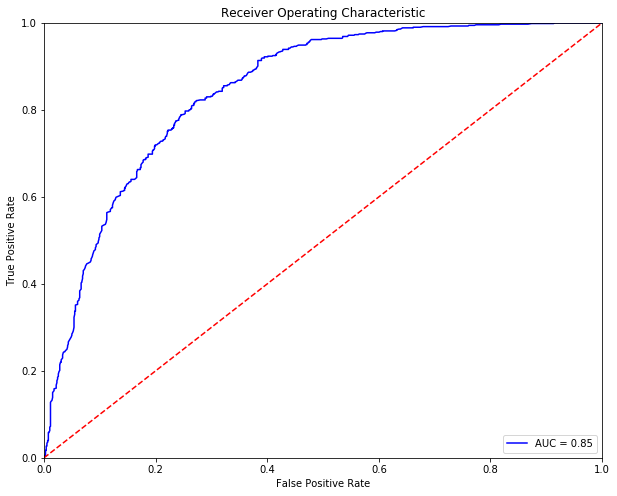

Optimal Threshold is 0.559
Accuracy of Logistic Model on training data is: 0.76561450638


Predicted  0.0  1.0  __all__
Actual                      
0.0        600  183      783
1.0        166  540      706
__all__    766  723     1489

In [465]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [466]:
table_70_50_PCA_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [467]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.930319608408


Predicted     0     1  __all__
Actual                        
0          1552   146     1698
1            96  1679     1775
__all__    1648  1825     3473

The test accuracy is: 0.764271323036


Predicted    0    1  __all__
Actual                      
0          575  208      783
1          143  563      706
__all__    718  771     1489

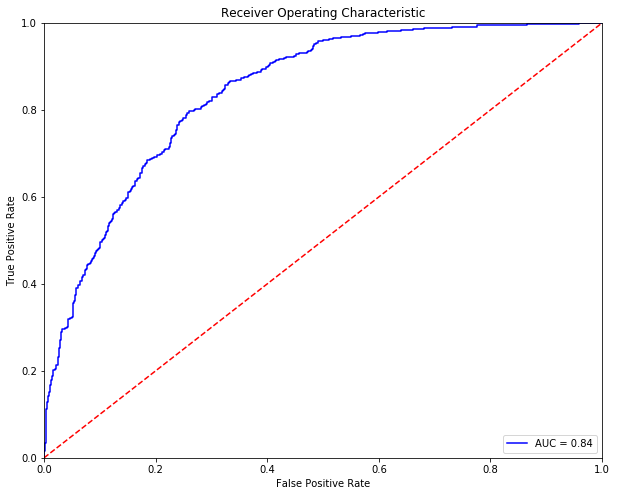

Optimal Threshold is 0.534356046356
Accuracy of Logistic Model on training data is: 0.762928139691


Predicted  0.0  1.0  __all__
Actual                      
0.0        597  186      783
1.0        167  539      706
__all__    764  725     1489

In [468]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [469]:
table_70_50_PCA_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [470]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.852001151776


Predicted     0     1  __all__
Actual                        
0          1504   194     1698
1           320  1455     1775
__all__    1824  1649     3473

The accuracy of the model on test data is: 0.764271323036


Predicted    0    1  __all__
Actual                      
0          608  175      783
1          176  530      706
__all__    784  705     1489

1216/1489 [=======================>......] - ETA: 0s

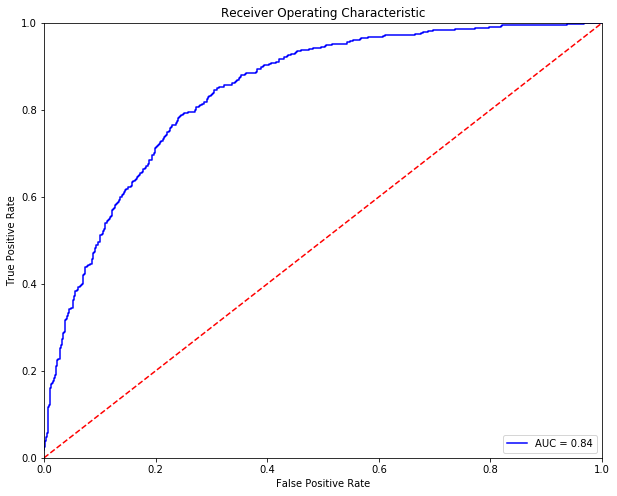

Optimal Threshold is 0.473594
Accuracy of Logistic Model on training data is: 0.76561450638


Predicted  0.0  1.0  __all__
Actual                      
0.0        600  183      783
1.0        166  540      706
__all__    766  723     1489

In [471]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [472]:
table_70_50_PCA_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [473]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.5min finished


The accuracy of the model on training data is: 0.803052116326


Predicted     0     1  __all__
Actual                        
0          1452   246     1698
1           438  1337     1775
__all__    1890  1583     3473

The accuracy of the model on test data is: 0.767629281397


Predicted    0    1  __all__
Actual                      
0          629  154      783
1          192  514      706
__all__    821  668     1489

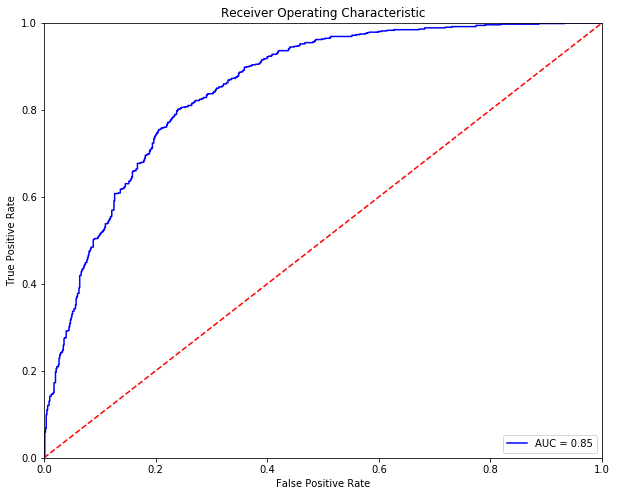

Optimal Threshold is 0.459713
Accuracy of Logistic Model on training data is: 0.773673606447


Predicted  0.0  1.0  __all__
Actual                      
0.0        607  176      783
1.0        161  545      706
__all__    768  721     1489

In [474]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [475]:
table_70_50_PCA_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_50_PCA_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_50_PCA_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [476]:
table_70_50_PCA_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_PCA_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_50_PCA_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_50_PCA_20_test.set_index(['index'],drop=True,inplace=True)
table_70_50_PCA_20_train.set_index(['index'],drop=True,inplace=True)
table_70_50_PCA_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_50_PCA_20_train)

print("Comparision Table for Test Accuracies:")
display(table_70_50_PCA_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_50_PCA_20_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1775.0  1698.0    0.0    0.0  0.000000   
LogisticRegression          0.787216  1393.0  1341.0  357.0  382.0  0.210247   
RandomForestClassifier      0.790959  1519.0  1228.0  470.0  256.0  0.276796   
AdaBoostClassifier          0.800461  1509.0  1271.0  427.0  266.0  0.251472   
GradientBoostingClassifier  0.808235  1481.0  1326.0  372.0  294.0  0.219081   
ExtraTreeClassifier         0.805356  1429.0  1368.0  330.0  346.0  0.194346   
BaggingClassifier           0.996833  1765.0  1697.0    1.0   10.0  0.000589   
VotingClassifier            0.930320  1679.0  1552.0  146.0   96.0  0.085984   
Neural Network-1            0.852001  1455.0  1504.0  194.0  320.0  0.114252   
Neural-Network-2            0.803052  1337.0  1452.0  246.0  438.0  0.144876   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.215211  
RandomForestClassifier      0.144225  
AdaBoostClassifier          0.149859  
GradientBoostingClassifier  0.165634  
ExtraTreeClassifier         0.194930  
BaggingClassifier           0.005634  
VotingClassifier            0.054085  
Neural Network-1            0.180282  
Neural-Network-2            0.246761

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.760242  539.0  593.0  190.0  167.0  0.242656   
LogisticRegression          0.767629  552.0  591.0  192.0  154.0  0.245211   
RandomForestClassifier      0.773002  597.0  554.0  229.0  109.0  0.292465   
AdaBoostClassifier          0.779718  586.0  575.0  208.0  120.0  0.265645   
GradientBoostingClassifier  0.775017  566.0  588.0  195.0  140.0  0.249042   
ExtraTreeClassifier         0.755541  532.0  593.0  190.0  174.0  0.242656   
BaggingClassifier           0.771659  578.0  571.0  212.0  128.0  0.270754   
VotingClassifier            0.764271  563.0  575.0  208.0  143.0  0.265645   
Neural Network-1            0.764271  530.0  608.0  175.0  176.0  0.223499   
Neural-Network-2            0.767629  514.0  629.0  154.0  192.0  0.196679   

                                 FNR  
index                                 
KNeighborsClassifier        0.236544  
LogisticRegression          0.218130  
RandomForestClassifier      0.154391  
AdaBoostClassifier          0.169972  
GradientBoostingClassifier  0.198300  
ExtraTreeClassifier         0.246459  
BaggingClassifier           0.181303  
VotingClassifier            0.202550  
Neural Network-1            0.249292  
Neural-Network-2            0.271955

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.760242  536.0  596.0  187.0  170.0  0.238825   
LogisticRegression          0.764943  540.0  599.0  184.0  166.0  0.234994   
RandomForestClassifier      0.773002  545.0  606.0  177.0  161.0  0.226054   
AdaBoostClassifier          0.774345  546.0  607.0  176.0  160.0  0.224777   
GradientBoostingClassifier  0.780390  550.0  612.0  171.0  156.0  0.218391   
ExtraTreeClassifier         0.764271  521.0  617.0  166.0  185.0  0.212005   
BaggingClassifier           0.765615  540.0  600.0  183.0  166.0  0.233716   
VotingClassifier            0.762928  539.0  597.0  186.0  167.0  0.237548   
Neural Network-1            0.765615  540.0  600.0  183.0  166.0  0.233716   
Neural-Network-2            0.773674  545.0  607.0  176.0  161.0  0.224777   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.240793   0.502844  0.844963  
LogisticRegression          0.235127   0.511918  0.847970  
RandomForestClassifier      0.228045   0.537981  0.814847  
AdaBoostClassifier          0.226629   0.506526  0.854457  
GradientBoostingClassifier  0.220963   0.569175  0.857304  
ExtraTreeClassifier         0.262040   0.520000  0.827501  
BaggingClassifier           0.235127   0.559000  0.847287  
VotingClassifier            0.236544   0.534356  0.842791  
Neural Network-1            0.235127   0.473594  0.842429  
Neural-Network-2            0.228045   0.459713  0.851940

In [3]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')